# A Simple Autoencoder (Linear Autoencoder)



We'll start off by building a simple autoencoder to compress the FossilNET dataset.

Autoencoders are neural networks that learn to compress data by passing it through two stages: an encoder and a decoder. The encoder takes the input data and compresses it into a lower-dimensional representation. The decoder then takes this representation and reconstructs the original input data.

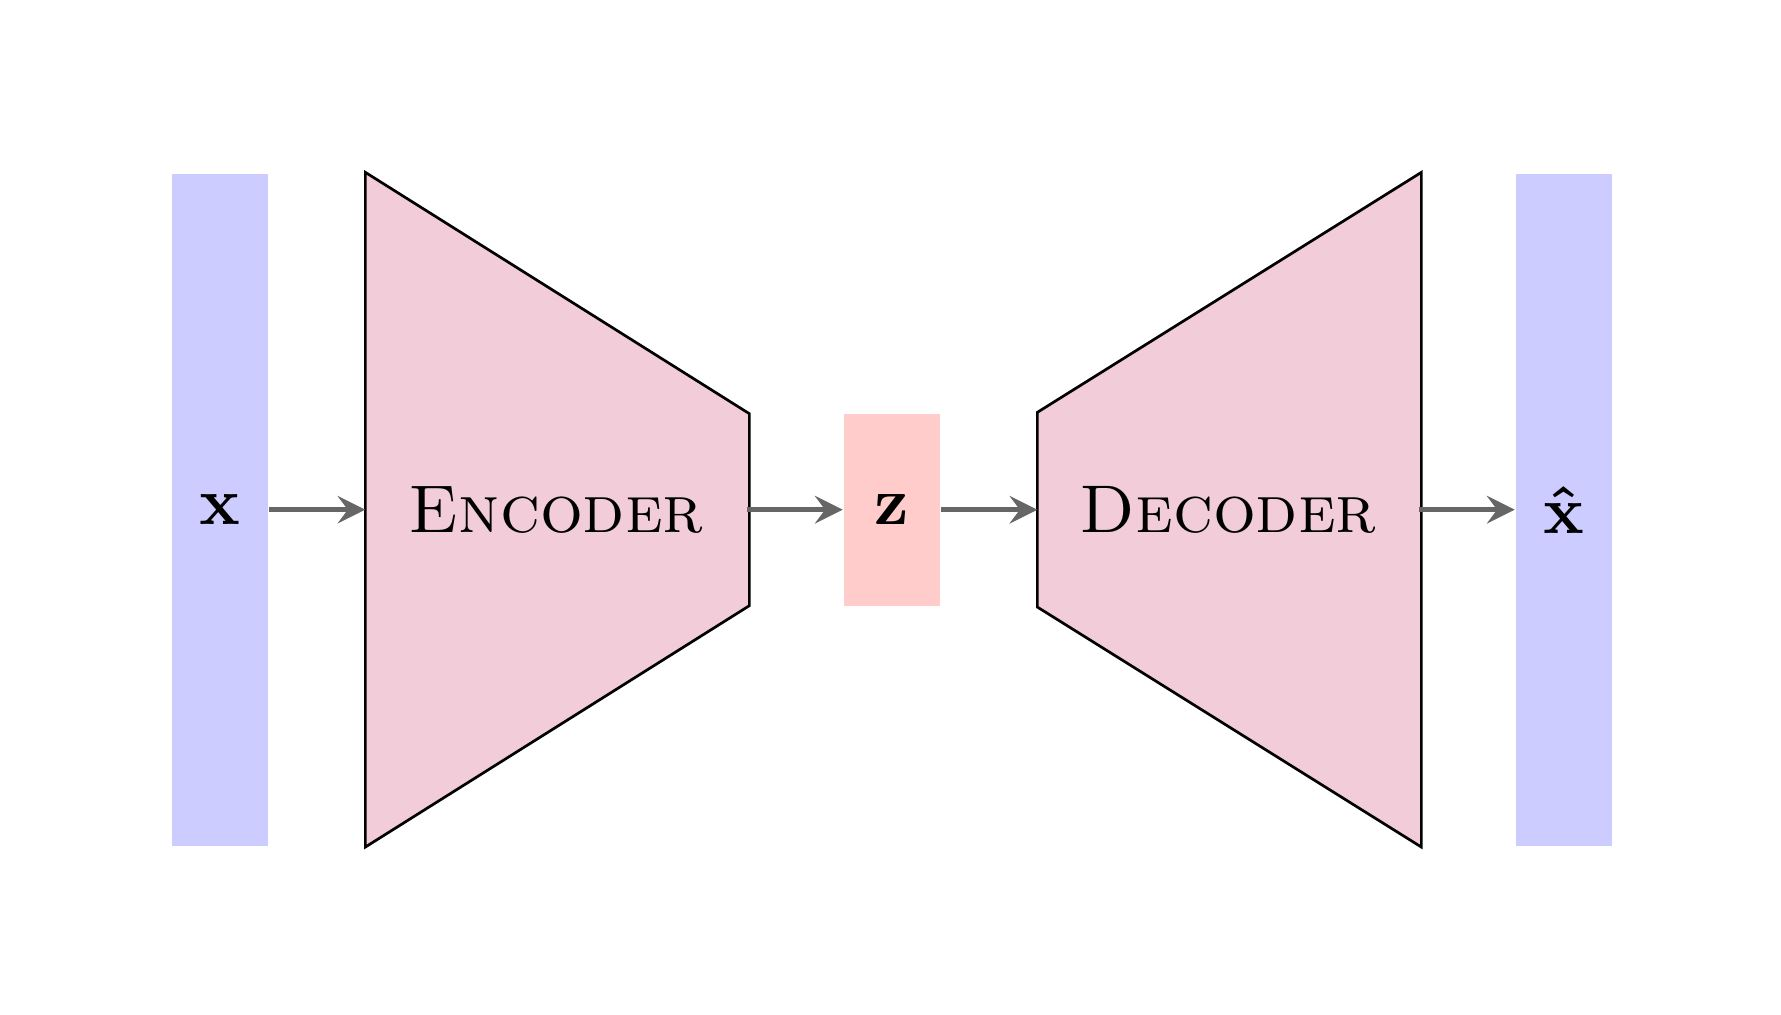
<p align = "center">
Fig.1 - Autoencoder Architecture  
(<a href="https://github.com/JamesAllingham/LaTeX-TikZ-Diagrams">
source
</a>)
</p>

We will try to visualize the generative power of autoencoders in this tutorial by generating new samples based on input images. Some other use cases of autoencoders include the following:
 - Image Denoising (the input is noisy image and output is denoised image)
 - Image completion (the input is an image with a patch missing and the output is completed image)
 - Data encoding and dimenensionality reduction.

In [ ]:
# Load fossil data
from google.colab import files
src = list(files.upload().values())[0]
open('dataloader_fossilnet.py','wb').write(src)

Saving dataloader_fossilnet.py to dataloader_fossilnet.py


3570

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
from dataloader_fossilnet import FossilNET

In [ ]:
#Model-Hyperparameters
EPOCHS = 100
LEARNING_RATE = 5e-4
BATCH_SIZE = 64
Z = 256

In [ ]:
# We will be using the Fossil dataset

transform = transforms.Compose([
        transforms.Resize(75),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
])

# Get the training, validation and test data
training_data = FossilNET('dataset', 'train', transform=transform, download=True)
print(f'Training samples {len(training_data)}')

# Randomly select a small subset of samples
# training_data = torch.utils.data.Subset(training_data, np.random.choice(len(training_data), 600, replace=False))

Training samples 2000


In [ ]:
# Initializing pytorch dataloader
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

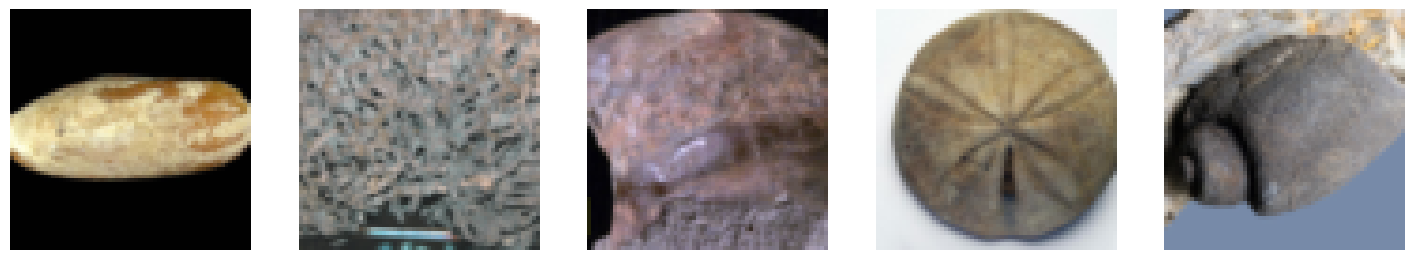

In [ ]:
# Visualizing some sample images
figure = plt.figure(figsize=(18, 14))
cols, rows = 5, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, _ = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), interpolation='none')
plt.show()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

We'll train an autoencoder with these images by flattening them into 64 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of one linear layer. The units that connect the encoder and decoder will be the compressed representation.

Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

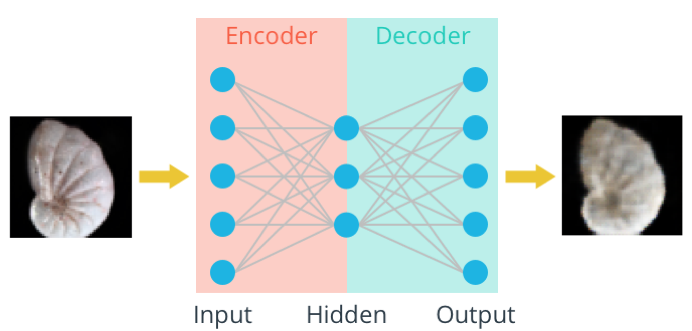

In [ ]:
import torch.nn.functional as F
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (64 -> encoding_dim)
        self.fc1 = nn.Linear(8 * 8, encoding_dim)

        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 8 * 8)


    def forward(self, x):
        print(x.shape)
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
model = model.to(device)
print(model)

Autoencoder(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
)


Typically, mean squared is used as the loss function for autoencoders. The  objective is to minimize the following:
$$ L(x,\hat{x}) = \frac{1}{N} \sum^{N}_{i=1} ||x_{i}-\hat{x}_{i}||^{2} $$

In [ ]:
# Defining the optimizer and loss function here
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss()

In [ ]:
# Training loop
loss_history = []
for i in range(1,EPOCHS+1):
    running_loss = 0
    pbar = tqdm(train_dataloader)
    for b, data in enumerate(pbar):
        # Every data instance is an input + label pair. We don't need the label
        inputs, _ = data
        inputs = inputs.to(device)

        # Zero the gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, inputs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Update Progress
        running_loss += loss.item()
        pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
        pbar.set_postfix({"loss": loss.item(), "avloss": running_loss/(b+1)})
    loss_history.append(running_loss)

Epoch 1/100: :   3%|▎         | 1/32 [00:00<00:09,  3.27it/s, loss=0.0636, avloss=0.0636]

torch.Size([64, 3, 64, 64])


Epoch 1/100: :   6%|▋         | 2/32 [00:00<00:08,  3.73it/s, loss=0.0648, avloss=0.0642]

torch.Size([64, 3, 64, 64])


Epoch 1/100: :   9%|▉         | 3/32 [00:00<00:07,  3.91it/s, loss=0.0607, avloss=0.063]

torch.Size([64, 3, 64, 64])


Epoch 1/100: :  12%|█▎        | 4/32 [00:01<00:06,  4.01it/s, loss=0.0624, avloss=0.0629]

torch.Size([64, 3, 64, 64])


Epoch 1/100: :  16%|█▌        | 5/32 [00:01<00:06,  3.91it/s, loss=0.0552, avloss=0.0613]

torch.Size([64, 3, 64, 64])


Epoch 1/100: :  19%|█▉        | 6/32 [00:01<00:06,  4.03it/s, loss=0.052, avloss=0.0598]

torch.Size([64, 3, 64, 64])


Epoch 1/100: :  22%|██▏       | 7/32 [00:01<00:06,  4.02it/s, loss=0.06, avloss=0.0598]

torch.Size([64, 3, 64, 64])


Epoch 1/100: :  25%|██▌       | 8/32 [00:02<00:05,  4.03it/s, loss=0.0522, avloss=0.0589]

torch.Size([64, 3, 64, 64])


Epoch 1/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.42it/s, loss=0.0577, avloss=0.0588]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.16it/s, loss=0.0636, avloss=0.0598]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: :  44%|████▍     | 14/32 [00:03<00:03,  5.53it/s, loss=0.055, avloss=0.0594]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: :  50%|█████     | 16/32 [00:03<00:02,  5.80it/s, loss=0.0579, avloss=0.0588]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.92it/s, loss=0.0674, avloss=0.0594]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: :  62%|██████▎   | 20/32 [00:04<00:01,  6.03it/s, loss=0.0517, avloss=0.0595]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.96it/s, loss=0.0553, avloss=0.0594]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.88it/s, loss=0.0577, avloss=0.0596]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.92it/s, loss=0.0564, avloss=0.0595]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.87it/s, loss=0.0691, avloss=0.06]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.99it/s, loss=0.0597, avloss=0.0599]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 1/100: : 100%|██████████| 32/32 [00:06<00:00,  5.32it/s, loss=0.0497, avloss=0.0592]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 2/100: :   6%|▋         | 2/32 [00:00<00:04,  6.12it/s, loss=0.0644, avloss=0.0646]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.97it/s, loss=0.0602, avloss=0.0622]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.89it/s, loss=0.061, avloss=0.0618]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.96it/s, loss=0.0505, avloss=0.06]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  31%|███▏      | 10/32 [00:01<00:03,  6.03it/s, loss=0.0603, avloss=0.0593]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.97it/s, loss=0.061, avloss=0.0598]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.93it/s, loss=0.0517, avloss=0.0588]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  50%|█████     | 16/32 [00:02<00:02,  6.04it/s, loss=0.0509, avloss=0.0587]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.96it/s, loss=0.0559, avloss=0.0585]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  62%|██████▎   | 20/32 [00:03<00:01,  6.00it/s, loss=0.0539, avloss=0.0584]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  69%|██████▉   | 22/32 [00:03<00:01,  6.09it/s, loss=0.0537, avloss=0.0581]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.96it/s, loss=0.0595, avloss=0.058]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  81%|████████▏ | 26/32 [00:04<00:00,  6.04it/s, loss=0.0556, avloss=0.0579]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  88%|████████▊ | 28/32 [00:04<00:00,  6.11it/s, loss=0.0594, avloss=0.0579]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: :  94%|█████████▍| 30/32 [00:05<00:00,  6.04it/s, loss=0.0438, avloss=0.0576]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 2/100: : 100%|██████████| 32/32 [00:05<00:00,  6.14it/s, loss=0.0604, avloss=0.0576]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 3/100: :   6%|▋         | 2/32 [00:00<00:04,  6.17it/s, loss=0.0589, avloss=0.0589]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 3/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.99it/s, loss=0.0491, avloss=0.0551]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 3/100: :  19%|█▉        | 6/32 [00:00<00:04,  6.07it/s, loss=0.0502, avloss=0.0557]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 3/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.60it/s, loss=0.0533, avloss=0.0554]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.04it/s, loss=0.0547, avloss=0.0553]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  28%|██▊       | 9/32 [00:01<00:04,  4.65it/s, loss=0.0552, avloss=0.0553]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  31%|███▏      | 10/32 [00:01<00:04,  4.44it/s, loss=0.0583, avloss=0.0556]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.35it/s, loss=0.062, avloss=0.0561]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.35it/s, loss=0.056, avloss=0.0561]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  41%|████      | 13/32 [00:02<00:04,  4.34it/s, loss=0.0645, avloss=0.0568]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  44%|████▍     | 14/32 [00:02<00:04,  4.04it/s, loss=0.044, avloss=0.0559]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.09it/s, loss=0.0519, avloss=0.0556]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  50%|█████     | 16/32 [00:03<00:03,  4.12it/s, loss=0.057, avloss=0.0557]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.15it/s, loss=0.052, avloss=0.0555]

torch.Size([64, 3, 64, 64])


Epoch 3/100: :  59%|█████▉    | 19/32 [00:04<00:02,  4.66it/s, loss=0.054, avloss=0.0549]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 3/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.32it/s, loss=0.0541, avloss=0.0549]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 3/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.70it/s, loss=0.0542, avloss=0.0551]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 3/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.91it/s, loss=0.0513, avloss=0.0548]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 3/100: :  84%|████████▍ | 27/32 [00:05<00:00,  6.01it/s, loss=0.055, avloss=0.0548]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 3/100: :  91%|█████████ | 29/32 [00:05<00:00,  6.06it/s, loss=0.0528, avloss=0.0545]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 3/100: :  97%|█████████▋| 31/32 [00:06<00:00,  6.05it/s, loss=0.0543, avloss=0.0542]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 3/100: : 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, loss=0.0497, avloss=0.054]


torch.Size([16, 3, 64, 64])


Epoch 4/100: :   3%|▎         | 1/32 [00:00<00:05,  5.96it/s, loss=0.0479, avloss=0.0479]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :   6%|▋         | 2/32 [00:00<00:04,  6.08it/s, loss=0.0534, avloss=0.0507]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :   9%|▉         | 3/32 [00:00<00:04,  6.13it/s, loss=0.0531, avloss=0.0515]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  12%|█▎        | 4/32 [00:00<00:04,  6.07it/s, loss=0.0493, avloss=0.0509]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  16%|█▌        | 5/32 [00:00<00:04,  6.07it/s, loss=0.0551, avloss=0.0517]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  19%|█▉        | 6/32 [00:00<00:04,  6.02it/s, loss=0.0506, avloss=0.0516]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  22%|██▏       | 7/32 [00:01<00:04,  6.02it/s, loss=0.0502, avloss=0.0514]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  25%|██▌       | 8/32 [00:01<00:03,  6.01it/s, loss=0.048, avloss=0.0509]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  28%|██▊       | 9/32 [00:01<00:03,  6.03it/s, loss=0.0471, avloss=0.0505]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  31%|███▏      | 10/32 [00:01<00:03,  6.01it/s, loss=0.0516, avloss=0.0506]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  34%|███▍      | 11/32 [00:01<00:03,  5.90it/s, loss=0.0427, avloss=0.0499]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.84it/s, loss=0.0486, avloss=0.0498]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  41%|████      | 13/32 [00:02<00:03,  5.93it/s, loss=0.0489, avloss=0.0497]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.97it/s, loss=0.0546, avloss=0.0501]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  47%|████▋     | 15/32 [00:02<00:02,  5.83it/s, loss=0.045, avloss=0.0497]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  50%|█████     | 16/32 [00:02<00:02,  5.91it/s, loss=0.0501, avloss=0.0498]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  53%|█████▎    | 17/32 [00:02<00:02,  5.88it/s, loss=0.0471, avloss=0.0496]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.88it/s, loss=0.0463, avloss=0.0494]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.98it/s, loss=0.0488, avloss=0.0494]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  62%|██████▎   | 20/32 [00:03<00:01,  6.01it/s, loss=0.0489, avloss=0.0494]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  66%|██████▌   | 21/32 [00:03<00:01,  5.96it/s, loss=0.0481, avloss=0.0493]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.92it/s, loss=0.0515, avloss=0.0494]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  72%|███████▏  | 23/32 [00:03<00:01,  5.97it/s, loss=0.0533, avloss=0.0496]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  75%|███████▌  | 24/32 [00:04<00:01,  6.00it/s, loss=0.0468, avloss=0.0495]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  78%|███████▊  | 25/32 [00:04<00:01,  6.05it/s, loss=0.0526, avloss=0.0496]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  81%|████████▏ | 26/32 [00:04<00:00,  6.03it/s, loss=0.0506, avloss=0.0496]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  84%|████████▍ | 27/32 [00:04<00:00,  6.00it/s, loss=0.0395, avloss=0.0492]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.97it/s, loss=0.0472, avloss=0.0492]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  91%|█████████ | 29/32 [00:04<00:00,  6.01it/s, loss=0.0441, avloss=0.049]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.97it/s, loss=0.0437, avloss=0.0488]

torch.Size([64, 3, 64, 64])


Epoch 4/100: :  97%|█████████▋| 31/32 [00:05<00:00,  5.99it/s, loss=0.0449, avloss=0.0487]

torch.Size([64, 3, 64, 64])


Epoch 4/100: : 100%|██████████| 32/32 [00:05<00:00,  6.11it/s, loss=0.0408, avloss=0.0484]


torch.Size([16, 3, 64, 64])


Epoch 5/100: :   3%|▎         | 1/32 [00:00<00:05,  6.06it/s, loss=0.0431, avloss=0.0431]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :   6%|▋         | 2/32 [00:00<00:05,  5.86it/s, loss=0.0423, avloss=0.0427]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :   9%|▉         | 3/32 [00:00<00:05,  5.72it/s, loss=0.0506, avloss=0.0453]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.86it/s, loss=0.0509, avloss=0.0467]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.86it/s, loss=0.0427, avloss=0.0459]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.92it/s, loss=0.05, avloss=0.0466]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  22%|██▏       | 7/32 [00:01<00:04,  6.03it/s, loss=0.048, avloss=0.0468]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.96it/s, loss=0.0425, avloss=0.0463]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  28%|██▊       | 9/32 [00:01<00:03,  5.92it/s, loss=0.0428, avloss=0.0459]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.82it/s, loss=0.0437, avloss=0.0457]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  34%|███▍      | 11/32 [00:01<00:03,  5.84it/s, loss=0.0387, avloss=0.045]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.89it/s, loss=0.0426, avloss=0.0448]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  41%|████      | 13/32 [00:02<00:03,  5.96it/s, loss=0.0474, avloss=0.045]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.90it/s, loss=0.0394, avloss=0.0446]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.90it/s, loss=0.0452, avloss=0.0446]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  50%|█████     | 16/32 [00:02<00:03,  4.98it/s, loss=0.042, avloss=0.0445]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.71it/s, loss=0.0433, avloss=0.0444]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  56%|█████▋    | 18/32 [00:03<00:03,  4.57it/s, loss=0.0383, avloss=0.0441]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  59%|█████▉    | 19/32 [00:03<00:02,  4.46it/s, loss=0.0388, avloss=0.0438]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  62%|██████▎   | 20/32 [00:03<00:02,  4.32it/s, loss=0.0375, avloss=0.0435]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.27it/s, loss=0.0455, avloss=0.0436]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.27it/s, loss=0.0408, avloss=0.0435]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  72%|███████▏  | 23/32 [00:04<00:02,  4.21it/s, loss=0.0359, avloss=0.0431]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  75%|███████▌  | 24/32 [00:04<00:01,  4.21it/s, loss=0.0406, avloss=0.043]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  78%|███████▊  | 25/32 [00:04<00:01,  4.13it/s, loss=0.0387, avloss=0.0429]

torch.Size([64, 3, 64, 64])


Epoch 5/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.42it/s, loss=0.0417, avloss=0.0427]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 5/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.17it/s, loss=0.0475, avloss=0.0431]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 5/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.46it/s, loss=0.0354, avloss=0.0426]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 5/100: : 100%|██████████| 32/32 [00:06<00:00,  5.20it/s, loss=0.0311, avloss=0.0423]


torch.Size([16, 3, 64, 64])


Epoch 6/100: :   3%|▎         | 1/32 [00:00<00:05,  5.89it/s, loss=0.0393, avloss=0.0393]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :   6%|▋         | 2/32 [00:00<00:05,  5.74it/s, loss=0.0405, avloss=0.0399]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :   9%|▉         | 3/32 [00:00<00:04,  5.84it/s, loss=0.0351, avloss=0.0383]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.94it/s, loss=0.0431, avloss=0.0395]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.96it/s, loss=0.0389, avloss=0.0394]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.95it/s, loss=0.0401, avloss=0.0395]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.91it/s, loss=0.0406, avloss=0.0397]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.89it/s, loss=0.0334, avloss=0.0389]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  28%|██▊       | 9/32 [00:01<00:03,  6.00it/s, loss=0.0368, avloss=0.0387]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  31%|███▏      | 10/32 [00:01<00:03,  6.00it/s, loss=0.0378, avloss=0.0386]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  34%|███▍      | 11/32 [00:01<00:03,  5.93it/s, loss=0.0419, avloss=0.0389]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.81it/s, loss=0.0356, avloss=0.0386]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  41%|████      | 13/32 [00:02<00:03,  5.85it/s, loss=0.0389, avloss=0.0386]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.74it/s, loss=0.0368, avloss=0.0385]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  47%|████▋     | 15/32 [00:02<00:02,  5.84it/s, loss=0.036, avloss=0.0383]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  50%|█████     | 16/32 [00:02<00:02,  5.84it/s, loss=0.0339, avloss=0.0381]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  53%|█████▎    | 17/32 [00:02<00:02,  5.71it/s, loss=0.0386, avloss=0.0381]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.82it/s, loss=0.0381, avloss=0.0381]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.89it/s, loss=0.042, avloss=0.0383]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.94it/s, loss=0.0414, avloss=0.0385]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  66%|██████▌   | 21/32 [00:03<00:01,  5.98it/s, loss=0.0395, avloss=0.0385]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.92it/s, loss=0.0319, avloss=0.0382]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  72%|███████▏  | 23/32 [00:03<00:01,  5.70it/s, loss=0.0356, avloss=0.0381]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.70it/s, loss=0.0341, avloss=0.0379]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.86it/s, loss=0.0394, avloss=0.038]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.93it/s, loss=0.035, avloss=0.0379]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  84%|████████▍ | 27/32 [00:04<00:00,  5.91it/s, loss=0.0352, avloss=0.0378]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.97it/s, loss=0.0299, avloss=0.0375]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  91%|█████████ | 29/32 [00:04<00:00,  5.93it/s, loss=0.0371, avloss=0.0375]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.96it/s, loss=0.031, avloss=0.0373]

torch.Size([64, 3, 64, 64])


Epoch 6/100: :  97%|█████████▋| 31/32 [00:05<00:00,  5.97it/s, loss=0.0351, avloss=0.0372]

torch.Size([64, 3, 64, 64])


Epoch 6/100: : 100%|██████████| 32/32 [00:05<00:00,  6.01it/s, loss=0.0395, avloss=0.0373]


torch.Size([16, 3, 64, 64])


Epoch 7/100: :   3%|▎         | 1/32 [00:00<00:05,  5.97it/s, loss=0.0333, avloss=0.0333]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :   6%|▋         | 2/32 [00:00<00:05,  5.80it/s, loss=0.0349, avloss=0.0341]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :   9%|▉         | 3/32 [00:00<00:04,  5.82it/s, loss=0.0353, avloss=0.0345]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.78it/s, loss=0.0331, avloss=0.0342]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.85it/s, loss=0.0347, avloss=0.0343]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.80it/s, loss=0.0346, avloss=0.0343]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  22%|██▏       | 7/32 [00:01<00:04,  6.00it/s, loss=0.0373, avloss=0.0347]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.88it/s, loss=0.035, avloss=0.0348]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.71it/s, loss=0.0348, avloss=0.0348]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.75it/s, loss=0.0322, avloss=0.0345]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  34%|███▍      | 11/32 [00:01<00:03,  5.81it/s, loss=0.0317, avloss=0.0343]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.79it/s, loss=0.0387, avloss=0.0346]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  41%|████      | 13/32 [00:02<00:03,  5.65it/s, loss=0.0334, avloss=0.0345]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.70it/s, loss=0.0347, avloss=0.0346]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  47%|████▋     | 15/32 [00:02<00:03,  5.66it/s, loss=0.031, avloss=0.0343]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  50%|█████     | 16/32 [00:02<00:02,  5.69it/s, loss=0.0294, avloss=0.034]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  53%|█████▎    | 17/32 [00:02<00:02,  5.82it/s, loss=0.0355, avloss=0.0341]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.77it/s, loss=0.028, avloss=0.0338]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.84it/s, loss=0.0285, avloss=0.0335]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.90it/s, loss=0.0354, avloss=0.0336]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  66%|██████▌   | 21/32 [00:03<00:01,  5.93it/s, loss=0.0312, avloss=0.0335]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.99it/s, loss=0.0345, avloss=0.0335]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  72%|███████▏  | 23/32 [00:03<00:01,  5.45it/s, loss=0.0286, avloss=0.0333]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  75%|███████▌  | 24/32 [00:04<00:01,  4.89it/s, loss=0.031, avloss=0.0332]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  78%|███████▊  | 25/32 [00:04<00:01,  4.61it/s, loss=0.03, avloss=0.0331]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  81%|████████▏ | 26/32 [00:04<00:01,  4.46it/s, loss=0.0287, avloss=0.0329]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  84%|████████▍ | 27/32 [00:04<00:01,  4.36it/s, loss=0.0315, avloss=0.0329]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.38it/s, loss=0.0328, avloss=0.0328]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.29it/s, loss=0.0324, avloss=0.0328]

torch.Size([64, 3, 64, 64])


Epoch 7/100: :  94%|█████████▍| 30/32 [00:05<00:00,  4.12it/s, loss=0.031, avloss=0.0328]

torch.Size([64, 3, 64, 64])


Epoch 7/100: : 100%|██████████| 32/32 [00:06<00:00,  5.29it/s, loss=0.0437, avloss=0.0331]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 8/100: :   3%|▎         | 1/32 [00:00<00:07,  4.26it/s, loss=0.0316, avloss=0.0316]

torch.Size([64, 3, 64, 64])


Epoch 8/100: :   6%|▋         | 2/32 [00:00<00:07,  4.20it/s, loss=0.0323, avloss=0.032]

torch.Size([64, 3, 64, 64])


Epoch 8/100: :  12%|█▎        | 4/32 [00:00<00:05,  4.87it/s, loss=0.0272, avloss=0.0295]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.39it/s, loss=0.0328, avloss=0.03]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.65it/s, loss=0.0311, avloss=0.0303]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.81it/s, loss=0.0313, avloss=0.0304]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  38%|███▊      | 12/32 [00:02<00:03,  6.01it/s, loss=0.0305, avloss=0.0306]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.96it/s, loss=0.0293, avloss=0.0306]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  50%|█████     | 16/32 [00:02<00:02,  5.84it/s, loss=0.0262, avloss=0.03]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.95it/s, loss=0.0294, avloss=0.0299]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  62%|██████▎   | 20/32 [00:03<00:01,  6.01it/s, loss=0.0279, avloss=0.0297]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.88it/s, loss=0.0286, avloss=0.0296]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.82it/s, loss=0.0272, avloss=0.0296]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.76it/s, loss=0.0276, avloss=0.0295]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.82it/s, loss=0.0291, avloss=0.0295]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.98it/s, loss=0.0282, avloss=0.0293]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 8/100: : 100%|██████████| 32/32 [00:05<00:00,  5.82it/s, loss=0.0295, avloss=0.0293]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 9/100: :   6%|▋         | 2/32 [00:00<00:05,  5.72it/s, loss=0.0284, avloss=0.0272]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.88it/s, loss=0.0246, avloss=0.0265]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.86it/s, loss=0.0245, avloss=0.0264]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.87it/s, loss=0.0295, avloss=0.0271]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.91it/s, loss=0.0262, avloss=0.0268]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  38%|███▊      | 12/32 [00:02<00:03,  6.00it/s, loss=0.0271, avloss=0.0268]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.91it/s, loss=0.0286, avloss=0.0268]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  50%|█████     | 16/32 [00:02<00:02,  5.94it/s, loss=0.0256, avloss=0.0269]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.88it/s, loss=0.026, avloss=0.0267]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.88it/s, loss=0.0291, avloss=0.0267]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.95it/s, loss=0.0265, avloss=0.0266]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.97it/s, loss=0.0254, avloss=0.0265]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.92it/s, loss=0.0238, avloss=0.0264]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.85it/s, loss=0.0251, avloss=0.0263]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: :  94%|█████████▍| 30/32 [00:05<00:00,  6.05it/s, loss=0.0267, avloss=0.0263]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 9/100: : 100%|██████████| 32/32 [00:05<00:00,  5.95it/s, loss=0.0252, avloss=0.0261]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 10/100: :   3%|▎         | 1/32 [00:00<00:07,  4.00it/s, loss=0.0258, avloss=0.0258]

torch.Size([64, 3, 64, 64])


Epoch 10/100: :   6%|▋         | 2/32 [00:00<00:07,  4.06it/s, loss=0.0245, avloss=0.0251]

torch.Size([64, 3, 64, 64])


Epoch 10/100: :   9%|▉         | 3/32 [00:00<00:07,  4.02it/s, loss=0.0238, avloss=0.0247]

torch.Size([64, 3, 64, 64])


Epoch 10/100: :  12%|█▎        | 4/32 [00:00<00:07,  4.00it/s, loss=0.0239, avloss=0.0245]

torch.Size([64, 3, 64, 64])


Epoch 10/100: :  16%|█▌        | 5/32 [00:01<00:06,  4.00it/s, loss=0.0223, avloss=0.0241]

torch.Size([64, 3, 64, 64])


Epoch 10/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.99it/s, loss=0.0254, avloss=0.0243]

torch.Size([64, 3, 64, 64])


Epoch 10/100: :  22%|██▏       | 7/32 [00:01<00:06,  4.03it/s, loss=0.0236, avloss=0.0242]

torch.Size([64, 3, 64, 64])


Epoch 10/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.03it/s, loss=0.0253, avloss=0.0243]

torch.Size([64, 3, 64, 64])


Epoch 10/100: :  28%|██▊       | 9/32 [00:02<00:05,  3.95it/s, loss=0.0255, avloss=0.0244]

torch.Size([64, 3, 64, 64])


Epoch 10/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.42it/s, loss=0.0229, avloss=0.0243]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: :  41%|████      | 13/32 [00:03<00:03,  5.07it/s, loss=0.0237, avloss=0.024]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.48it/s, loss=0.0228, avloss=0.0241]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.70it/s, loss=0.0234, avloss=0.0239]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: :  59%|█████▉    | 19/32 [00:04<00:02,  5.81it/s, loss=0.0223, avloss=0.0237]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: :  66%|██████▌   | 21/32 [00:04<00:01,  5.74it/s, loss=0.0234, avloss=0.0238]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.90it/s, loss=0.0215, avloss=0.0236]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.95it/s, loss=0.0254, avloss=0.0237]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.87it/s, loss=0.0217, avloss=0.0236]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.93it/s, loss=0.025, avloss=0.0236]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.86it/s, loss=0.0202, avloss=0.0234]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 10/100: : 100%|██████████| 32/32 [00:06<00:00,  5.22it/s, loss=0.0199, avloss=0.0233]


torch.Size([16, 3, 64, 64])


Epoch 11/100: :   3%|▎         | 1/32 [00:00<00:05,  5.66it/s, loss=0.0213, avloss=0.0213]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :   6%|▋         | 2/32 [00:00<00:05,  5.93it/s, loss=0.0219, avloss=0.0216]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :   9%|▉         | 3/32 [00:00<00:04,  5.82it/s, loss=0.0198, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.77it/s, loss=0.0209, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.62it/s, loss=0.0223, avloss=0.0212]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.72it/s, loss=0.0214, avloss=0.0213]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.74it/s, loss=0.019, avloss=0.0209]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.72it/s, loss=0.0238, avloss=0.0213]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  28%|██▊       | 9/32 [00:01<00:03,  5.80it/s, loss=0.0198, avloss=0.0211]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.88it/s, loss=0.02, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  34%|███▍      | 11/32 [00:01<00:03,  5.88it/s, loss=0.0217, avloss=0.0211]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.77it/s, loss=0.0229, avloss=0.0212]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  41%|████      | 13/32 [00:02<00:03,  5.68it/s, loss=0.0185, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.69it/s, loss=0.0202, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  47%|████▋     | 15/32 [00:02<00:02,  5.74it/s, loss=0.019, avloss=0.0208]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  50%|█████     | 16/32 [00:02<00:02,  5.71it/s, loss=0.0216, avloss=0.0209]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  53%|█████▎    | 17/32 [00:02<00:02,  5.77it/s, loss=0.0221, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.75it/s, loss=0.0205, avloss=0.0209]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.83it/s, loss=0.0231, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.86it/s, loss=0.0214, avloss=0.0211]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  66%|██████▌   | 21/32 [00:03<00:01,  5.92it/s, loss=0.0204, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.81it/s, loss=0.0223, avloss=0.0211]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  72%|███████▏  | 23/32 [00:03<00:01,  5.86it/s, loss=0.0213, avloss=0.0211]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.79it/s, loss=0.0191, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.76it/s, loss=0.0231, avloss=0.0211]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.73it/s, loss=0.018, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  84%|████████▍ | 27/32 [00:04<00:00,  5.75it/s, loss=0.0206, avloss=0.021]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.80it/s, loss=0.0206, avloss=0.0209]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.79it/s, loss=0.0197, avloss=0.0209]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.75it/s, loss=0.0198, avloss=0.0209]

torch.Size([64, 3, 64, 64])


Epoch 11/100: :  97%|█████████▋| 31/32 [00:05<00:00,  5.81it/s, loss=0.0191, avloss=0.0208]

torch.Size([64, 3, 64, 64])


Epoch 11/100: : 100%|██████████| 32/32 [00:05<00:00,  5.91it/s, loss=0.0196, avloss=0.0208]


torch.Size([16, 3, 64, 64])


Epoch 12/100: :   3%|▎         | 1/32 [00:00<00:05,  5.74it/s, loss=0.0194, avloss=0.0194]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :   6%|▋         | 2/32 [00:00<00:05,  5.72it/s, loss=0.0187, avloss=0.0191]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :   9%|▉         | 3/32 [00:00<00:05,  5.74it/s, loss=0.019, avloss=0.019]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.76it/s, loss=0.0172, avloss=0.0186]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.72it/s, loss=0.0195, avloss=0.0188]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.59it/s, loss=0.0168, avloss=0.0184]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.06it/s, loss=0.0194, avloss=0.0186]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.73it/s, loss=0.0211, avloss=0.0189]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  28%|██▊       | 9/32 [00:01<00:05,  4.50it/s, loss=0.0208, avloss=0.0191]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.32it/s, loss=0.0227, avloss=0.0195]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.34it/s, loss=0.0201, avloss=0.0195]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.30it/s, loss=0.017, avloss=0.0193]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  41%|████      | 13/32 [00:02<00:04,  4.26it/s, loss=0.0185, avloss=0.0192]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  44%|████▍     | 14/32 [00:02<00:04,  4.27it/s, loss=0.0185, avloss=0.0192]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  47%|████▋     | 15/32 [00:03<00:03,  4.27it/s, loss=0.0174, avloss=0.0191]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  50%|█████     | 16/32 [00:03<00:03,  4.29it/s, loss=0.0184, avloss=0.019]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.22it/s, loss=0.0183, avloss=0.019]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  56%|█████▋    | 18/32 [00:03<00:03,  4.26it/s, loss=0.0192, avloss=0.019]

torch.Size([64, 3, 64, 64])


Epoch 12/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.62it/s, loss=0.0171, avloss=0.0189]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 12/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.12it/s, loss=0.0175, avloss=0.0189]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 12/100: :  75%|███████▌  | 24/32 [00:05<00:01,  5.29it/s, loss=0.0186, avloss=0.0188]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 12/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.52it/s, loss=0.0172, avloss=0.0187]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 12/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.74it/s, loss=0.0196, avloss=0.0187]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 12/100: :  94%|█████████▍| 30/32 [00:06<00:00,  5.74it/s, loss=0.0177, avloss=0.0186]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 12/100: : 100%|██████████| 32/32 [00:06<00:00,  5.08it/s, loss=0.0182, avloss=0.0185]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 13/100: :   6%|▋         | 2/32 [00:00<00:05,  5.95it/s, loss=0.0179, avloss=0.0178]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.89it/s, loss=0.0158, avloss=0.0178]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.88it/s, loss=0.0191, avloss=0.0178]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.85it/s, loss=0.0163, avloss=0.0175]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.94it/s, loss=0.0183, avloss=0.0176]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.83it/s, loss=0.017, avloss=0.0175]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.88it/s, loss=0.015, avloss=0.0172]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  50%|█████     | 16/32 [00:02<00:02,  5.85it/s, loss=0.0188, avloss=0.0173]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.87it/s, loss=0.0152, avloss=0.0171]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.88it/s, loss=0.0157, avloss=0.017]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.82it/s, loss=0.0157, avloss=0.0168]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.75it/s, loss=0.0149, avloss=0.0167]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.88it/s, loss=0.0172, avloss=0.0166]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.80it/s, loss=0.0181, avloss=0.0166]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.74it/s, loss=0.0163, avloss=0.0165]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 13/100: : 100%|██████████| 32/32 [00:05<00:00,  5.98it/s, loss=0.0163, avloss=0.0165]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 14/100: :   6%|▋         | 2/32 [00:00<00:04,  6.03it/s, loss=0.0165, avloss=0.0162]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 14/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.94it/s, loss=0.0148, avloss=0.0157]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 14/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.87it/s, loss=0.0151, avloss=0.0156]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 14/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.97it/s, loss=0.0159, avloss=0.0156]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 14/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.91it/s, loss=0.0146, avloss=0.0154]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 14/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.78it/s, loss=0.0142, avloss=0.0154]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 14/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.91it/s, loss=0.0144, avloss=0.0153]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 14/100: :  47%|████▋     | 15/32 [00:02<00:03,  5.65it/s, loss=0.015, avloss=0.0153]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  50%|█████     | 16/32 [00:02<00:03,  5.02it/s, loss=0.0155, avloss=0.0153]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.60it/s, loss=0.0158, avloss=0.0153]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  56%|█████▋    | 18/32 [00:03<00:03,  4.46it/s, loss=0.0129, avloss=0.0152]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  59%|█████▉    | 19/32 [00:03<00:02,  4.37it/s, loss=0.0132, avloss=0.0151]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  62%|██████▎   | 20/32 [00:03<00:02,  4.33it/s, loss=0.0152, avloss=0.0151]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.27it/s, loss=0.0156, avloss=0.0151]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.28it/s, loss=0.015, avloss=0.0151]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  72%|███████▏  | 23/32 [00:04<00:02,  4.26it/s, loss=0.0154, avloss=0.0151]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  75%|███████▌  | 24/32 [00:04<00:01,  4.25it/s, loss=0.0142, avloss=0.0151]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.13it/s, loss=0.0128, avloss=0.015]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.13it/s, loss=0.0146, avloss=0.015]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.18it/s, loss=0.0142, avloss=0.0149]

torch.Size([64, 3, 64, 64])


Epoch 14/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.78it/s, loss=0.0125, avloss=0.0148]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 14/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.21it/s, loss=0.0119, avloss=0.0147]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 14/100: : 100%|██████████| 32/32 [00:06<00:00,  5.12it/s, loss=0.013, avloss=0.0147]


torch.Size([16, 3, 64, 64])


Epoch 15/100: :   3%|▎         | 1/32 [00:00<00:05,  5.95it/s, loss=0.0155, avloss=0.0155]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :   6%|▋         | 2/32 [00:00<00:05,  5.78it/s, loss=0.0147, avloss=0.0151]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :   9%|▉         | 3/32 [00:00<00:04,  5.82it/s, loss=0.0127, avloss=0.0143]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.80it/s, loss=0.014, avloss=0.0142]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.82it/s, loss=0.0127, avloss=0.0139]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.81it/s, loss=0.0131, avloss=0.0138]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.74it/s, loss=0.0132, avloss=0.0137]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.63it/s, loss=0.0119, avloss=0.0135]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  28%|██▊       | 9/32 [00:01<00:03,  5.77it/s, loss=0.0128, avloss=0.0134]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.81it/s, loss=0.0131, avloss=0.0134]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  34%|███▍      | 11/32 [00:01<00:03,  5.65it/s, loss=0.0129, avloss=0.0133]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.71it/s, loss=0.0122, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  41%|████      | 13/32 [00:02<00:03,  5.70it/s, loss=0.0121, avloss=0.0131]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.75it/s, loss=0.0133, avloss=0.0131]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  47%|████▋     | 15/32 [00:02<00:02,  5.85it/s, loss=0.0149, avloss=0.0133]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  50%|█████     | 16/32 [00:02<00:02,  5.84it/s, loss=0.0151, avloss=0.0134]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  53%|█████▎    | 17/32 [00:02<00:02,  5.82it/s, loss=0.0128, avloss=0.0133]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.78it/s, loss=0.0127, avloss=0.0133]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.75it/s, loss=0.0137, avloss=0.0133]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.69it/s, loss=0.0115, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  66%|██████▌   | 21/32 [00:03<00:01,  5.75it/s, loss=0.0129, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.64it/s, loss=0.0137, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.62it/s, loss=0.0125, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.62it/s, loss=0.0133, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.66it/s, loss=0.0119, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.62it/s, loss=0.0142, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  84%|████████▍ | 27/32 [00:04<00:00,  5.73it/s, loss=0.0136, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.70it/s, loss=0.0126, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.84it/s, loss=0.0147, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.83it/s, loss=0.0129, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: :  97%|█████████▋| 31/32 [00:05<00:00,  5.78it/s, loss=0.0121, avloss=0.0132]

torch.Size([64, 3, 64, 64])


Epoch 15/100: : 100%|██████████| 32/32 [00:05<00:00,  5.86it/s, loss=0.0142, avloss=0.0132]


torch.Size([16, 3, 64, 64])


Epoch 16/100: :   3%|▎         | 1/32 [00:00<00:05,  5.92it/s, loss=0.0124, avloss=0.0124]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :   6%|▋         | 2/32 [00:00<00:05,  5.71it/s, loss=0.0121, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :   9%|▉         | 3/32 [00:00<00:05,  5.73it/s, loss=0.0135, avloss=0.0127]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.82it/s, loss=0.0113, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.87it/s, loss=0.0121, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.71it/s, loss=0.0123, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.73it/s, loss=0.0139, avloss=0.0125]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.65it/s, loss=0.0126, avloss=0.0125]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.69it/s, loss=0.0123, avloss=0.0125]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.70it/s, loss=0.0111, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  34%|███▍      | 11/32 [00:01<00:03,  5.66it/s, loss=0.0122, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  34%|███▍      | 11/32 [00:02<00:03,  5.66it/s, loss=0.0122, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  41%|████      | 13/32 [00:02<00:03,  5.62it/s, loss=0.0124, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.72it/s, loss=0.0126, avloss=0.0124]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  47%|████▋     | 15/32 [00:02<00:02,  5.73it/s, loss=0.0119, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  50%|█████     | 16/32 [00:02<00:02,  5.77it/s, loss=0.012, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  53%|█████▎    | 17/32 [00:02<00:02,  5.72it/s, loss=0.0116, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.74it/s, loss=0.0122, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.74it/s, loss=0.0126, avloss=0.0123]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.71it/s, loss=0.0105, avloss=0.0122]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  66%|██████▌   | 21/32 [00:03<00:01,  5.75it/s, loss=0.0107, avloss=0.0121]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.73it/s, loss=0.0106, avloss=0.012]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.15it/s, loss=0.0142, avloss=0.0121]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  75%|███████▌  | 24/32 [00:04<00:01,  4.84it/s, loss=0.0117, avloss=0.0121]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  78%|███████▊  | 25/32 [00:04<00:01,  4.62it/s, loss=0.011, avloss=0.0121]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  81%|████████▏ | 26/32 [00:04<00:01,  4.48it/s, loss=0.0117, avloss=0.0121]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.44it/s, loss=0.0121, avloss=0.0121]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.30it/s, loss=0.0116, avloss=0.012]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.30it/s, loss=0.0114, avloss=0.012]

torch.Size([64, 3, 64, 64])


Epoch 16/100: :  94%|█████████▍| 30/32 [00:05<00:00,  4.31it/s, loss=0.0114, avloss=0.012]

torch.Size([64, 3, 64, 64])


Epoch 16/100: : 100%|██████████| 32/32 [00:06<00:00,  5.29it/s, loss=0.0101, avloss=0.0119]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 17/100: :   3%|▎         | 1/32 [00:00<00:07,  4.07it/s, loss=0.00956, avloss=0.00956]

torch.Size([64, 3, 64, 64])


Epoch 17/100: :   6%|▋         | 2/32 [00:00<00:07,  4.20it/s, loss=0.00977, avloss=0.00966]

torch.Size([64, 3, 64, 64])


Epoch 17/100: :   9%|▉         | 3/32 [00:00<00:07,  4.07it/s, loss=0.0106, avloss=0.00997]

torch.Size([64, 3, 64, 64])


Epoch 17/100: :  16%|█▌        | 5/32 [00:01<00:06,  4.45it/s, loss=0.0116, avloss=0.0107]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.14it/s, loss=0.0108, avloss=0.0107]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.42it/s, loss=0.0109, avloss=0.0109]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  34%|███▍      | 11/32 [00:02<00:03,  5.53it/s, loss=0.0103, avloss=0.0108]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  41%|████      | 13/32 [00:02<00:03,  5.72it/s, loss=0.0111, avloss=0.0109]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  47%|████▋     | 15/32 [00:02<00:02,  5.71it/s, loss=0.0104, avloss=0.0109]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.59it/s, loss=0.0114, avloss=0.0109]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.62it/s, loss=0.0111, avloss=0.0109]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  66%|██████▌   | 21/32 [00:03<00:01,  5.75it/s, loss=0.0111, avloss=0.0109]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.73it/s, loss=0.0125, avloss=0.0109]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.87it/s, loss=0.0107, avloss=0.011]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  84%|████████▍ | 27/32 [00:04<00:00,  5.83it/s, loss=0.0118, avloss=0.011]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.75it/s, loss=0.0105, avloss=0.011]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: :  97%|█████████▋| 31/32 [00:05<00:00,  5.76it/s, loss=0.0105, avloss=0.0109]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 17/100: : 100%|██████████| 32/32 [00:05<00:00,  5.56it/s, loss=0.0108, avloss=0.0109]


torch.Size([16, 3, 64, 64])


Epoch 18/100: :   6%|▋         | 2/32 [00:00<00:05,  5.52it/s, loss=0.00873, avloss=0.00937]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.51it/s, loss=0.0103, avloss=0.00986]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.67it/s, loss=0.0107, avloss=0.0102]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.69it/s, loss=0.00889, avloss=0.00997]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.73it/s, loss=0.0109, avloss=0.0101]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.70it/s, loss=0.0102, avloss=0.0102]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.77it/s, loss=0.0104, avloss=0.0102]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  50%|█████     | 16/32 [00:02<00:02,  5.73it/s, loss=0.0109, avloss=0.0103]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.73it/s, loss=0.00997, avloss=0.0104]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.80it/s, loss=0.0108, avloss=0.0104]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.70it/s, loss=0.00943, avloss=0.0102]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.69it/s, loss=0.0103, avloss=0.0102]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.77it/s, loss=0.00934, avloss=0.0102]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.79it/s, loss=0.00921, avloss=0.0101]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.86it/s, loss=0.00916, avloss=0.0101]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 18/100: : 100%|██████████| 32/32 [00:05<00:00,  5.76it/s, loss=0.0113, avloss=0.0101]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 19/100: :   3%|▎         | 1/32 [00:00<00:07,  3.95it/s, loss=0.00915, avloss=0.00915]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :   6%|▋         | 2/32 [00:00<00:07,  4.04it/s, loss=0.00964, avloss=0.0094]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :   9%|▉         | 3/32 [00:00<00:07,  4.09it/s, loss=0.00769, avloss=0.00883]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :  12%|█▎        | 4/32 [00:00<00:06,  4.15it/s, loss=0.0108, avloss=0.00933]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :  16%|█▌        | 5/32 [00:01<00:06,  3.98it/s, loss=0.0108, avloss=0.00963]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.99it/s, loss=0.0103, avloss=0.00974]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :  22%|██▏       | 7/32 [00:01<00:06,  3.97it/s, loss=0.00968, avloss=0.00973]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :  25%|██▌       | 8/32 [00:01<00:06,  4.00it/s, loss=0.00855, avloss=0.00959]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s, loss=0.0102, avloss=0.00966]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.98it/s, loss=0.00941, avloss=0.00963]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :  34%|███▍      | 11/32 [00:02<00:05,  4.03it/s, loss=0.0101, avloss=0.00968]

torch.Size([64, 3, 64, 64])


Epoch 19/100: :  41%|████      | 13/32 [00:03<00:04,  4.51it/s, loss=0.0102, avloss=0.00968]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 19/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.02it/s, loss=0.00893, avloss=0.00963]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 19/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.39it/s, loss=0.00894, avloss=0.00955]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 19/100: :  59%|█████▉    | 19/32 [00:04<00:02,  5.56it/s, loss=0.00973, avloss=0.00955]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 19/100: :  66%|██████▌   | 21/32 [00:04<00:01,  5.58it/s, loss=0.00864, avloss=0.0095]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 19/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.74it/s, loss=0.0101, avloss=0.00957]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 19/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.74it/s, loss=0.00904, avloss=0.00947]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 19/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.64it/s, loss=0.01, avloss=0.00947]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 19/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.59it/s, loss=0.00886, avloss=0.00944]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 19/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.69it/s, loss=0.00948, avloss=0.00941]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 19/100: : 100%|██████████| 32/32 [00:06<00:00,  5.01it/s, loss=0.00921, avloss=0.00941]


torch.Size([16, 3, 64, 64])


Epoch 20/100: :   3%|▎         | 1/32 [00:00<00:05,  5.74it/s, loss=0.00968, avloss=0.00968]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :   6%|▋         | 2/32 [00:00<00:05,  5.65it/s, loss=0.0088, avloss=0.00924]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :   9%|▉         | 3/32 [00:00<00:05,  5.69it/s, loss=0.00945, avloss=0.00931]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.69it/s, loss=0.00905, avloss=0.00925]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.57it/s, loss=0.00881, avloss=0.00916]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.57it/s, loss=0.00896, avloss=0.00913]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.59it/s, loss=0.00883, avloss=0.00908]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.69it/s, loss=0.00925, avloss=0.0091]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.63it/s, loss=0.0109, avloss=0.00931]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.68it/s, loss=0.00877, avloss=0.00925]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  34%|███▍      | 11/32 [00:01<00:03,  5.69it/s, loss=0.00909, avloss=0.00924]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.61it/s, loss=0.00945, avloss=0.00926]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  41%|████      | 13/32 [00:02<00:03,  5.64it/s, loss=0.00945, avloss=0.00927]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.57it/s, loss=0.00827, avloss=0.0092]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  47%|████▋     | 15/32 [00:02<00:03,  5.64it/s, loss=0.00839, avloss=0.00915]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  50%|█████     | 16/32 [00:02<00:02,  5.68it/s, loss=0.0102, avloss=0.00921]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  50%|█████     | 16/32 [00:03<00:02,  5.68it/s, loss=0.00789, avloss=0.00913]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.62it/s, loss=0.00752, avloss=0.00904]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.59it/s, loss=0.00865, avloss=0.00902]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.54it/s, loss=0.00923, avloss=0.00903]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  66%|██████▌   | 21/32 [00:03<00:01,  5.64it/s, loss=0.00855, avloss=0.00901]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.61it/s, loss=0.00891, avloss=0.00901]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.54it/s, loss=0.00746, avloss=0.00894]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.59it/s, loss=0.0072, avloss=0.00887]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.65it/s, loss=0.0093, avloss=0.00888]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.54it/s, loss=0.00876, avloss=0.00888]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  84%|████████▍ | 27/32 [00:04<00:00,  5.56it/s, loss=0.0096, avloss=0.00891]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.67it/s, loss=0.00886, avloss=0.0089]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.60it/s, loss=0.00845, avloss=0.00889]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.64it/s, loss=0.00779, avloss=0.00885]

torch.Size([64, 3, 64, 64])


Epoch 20/100: :  97%|█████████▋| 31/32 [00:05<00:00,  5.58it/s, loss=0.0092, avloss=0.00886]

torch.Size([64, 3, 64, 64])


Epoch 20/100: : 100%|██████████| 32/32 [00:05<00:00,  5.73it/s, loss=0.00957, avloss=0.00889]


torch.Size([16, 3, 64, 64])


Epoch 21/100: :   3%|▎         | 1/32 [00:00<00:05,  5.74it/s, loss=0.00887, avloss=0.00887]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :   6%|▋         | 2/32 [00:00<00:05,  5.59it/s, loss=0.0081, avloss=0.00848]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :   9%|▉         | 3/32 [00:00<00:05,  5.54it/s, loss=0.00871, avloss=0.00856]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.57it/s, loss=0.00838, avloss=0.00852]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.56it/s, loss=0.00778, avloss=0.00837]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.99it/s, loss=0.00852, avloss=0.00839]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.67it/s, loss=0.00801, avloss=0.00834]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.42it/s, loss=0.00881, avloss=0.0084]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  28%|██▊       | 9/32 [00:01<00:05,  4.37it/s, loss=0.00882, avloss=0.00845]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.22it/s, loss=0.00743, avloss=0.00834]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.21it/s, loss=0.00903, avloss=0.00841]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.17it/s, loss=0.00969, avloss=0.00851]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  41%|████      | 13/32 [00:02<00:04,  4.14it/s, loss=0.00807, avloss=0.00848]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.05it/s, loss=0.00738, avloss=0.0084]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.13it/s, loss=0.00787, avloss=0.00837]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  50%|█████     | 16/32 [00:03<00:03,  4.12it/s, loss=0.00798, avloss=0.00834]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.06it/s, loss=0.00865, avloss=0.00836]

torch.Size([64, 3, 64, 64])


Epoch 21/100: :  59%|█████▉    | 19/32 [00:04<00:02,  4.52it/s, loss=0.00886, avloss=0.00839]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 21/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.98it/s, loss=0.00855, avloss=0.00845]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 21/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.30it/s, loss=0.00762, avloss=0.00839]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 21/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.34it/s, loss=0.00927, avloss=0.00838]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 21/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.56it/s, loss=0.00826, avloss=0.0084]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 21/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.61it/s, loss=0.00841, avloss=0.00837]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 21/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.62it/s, loss=0.00937, avloss=0.00841]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 21/100: : 100%|██████████| 32/32 [00:06<00:00,  4.95it/s, loss=0.00766, avloss=0.00839]


torch.Size([16, 3, 64, 64])


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :   6%|▋         | 2/32 [00:00<00:05,  5.42it/s, loss=0.00763, avloss=0.00816]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :   9%|▉         | 3/32 [00:00<00:05,  5.55it/s, loss=0.00869, avloss=0.00833]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.51it/s, loss=0.00757, avloss=0.00814]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.62it/s, loss=0.00826, avloss=0.00817]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.56it/s, loss=0.00775, avloss=0.0081]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.54it/s, loss=0.00828, avloss=0.00812]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.54it/s, loss=0.00719, avloss=0.00801]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.50it/s, loss=0.00812, avloss=0.00802]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.55it/s, loss=0.00803, avloss=0.00802]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  34%|███▍      | 11/32 [00:01<00:03,  5.63it/s, loss=0.00744, avloss=0.00797]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.69it/s, loss=0.00928, avloss=0.00808]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  41%|████      | 13/32 [00:02<00:03,  5.59it/s, loss=0.00786, avloss=0.00806]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.62it/s, loss=0.00856, avloss=0.0081]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  47%|████▋     | 15/32 [00:02<00:03,  5.63it/s, loss=0.00737, avloss=0.00805]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  50%|█████     | 16/32 [00:02<00:02,  5.67it/s, loss=0.00809, avloss=0.00805]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.68it/s, loss=0.00717, avloss=0.008]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.59it/s, loss=0.00765, avloss=0.00798]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.54it/s, loss=0.00761, avloss=0.00796]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.59it/s, loss=0.00742, avloss=0.00793]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  66%|██████▌   | 21/32 [00:03<00:01,  5.59it/s, loss=0.00786, avloss=0.00793]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.59it/s, loss=0.00761, avloss=0.00791]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.61it/s, loss=0.00806, avloss=0.00792]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.68it/s, loss=0.00969, avloss=0.00799]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.61it/s, loss=0.00837, avloss=0.00801]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.69it/s, loss=0.00825, avloss=0.00802]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  84%|████████▍ | 27/32 [00:04<00:00,  5.66it/s, loss=0.00874, avloss=0.00805]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.67it/s, loss=0.0077, avloss=0.00803]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.69it/s, loss=0.00831, avloss=0.00804]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.67it/s, loss=0.00797, avloss=0.00804]

torch.Size([64, 3, 64, 64])


Epoch 22/100: :  97%|█████████▋| 31/32 [00:05<00:00,  5.62it/s, loss=0.00867, avloss=0.00806]

torch.Size([64, 3, 64, 64])


Epoch 22/100: : 100%|██████████| 32/32 [00:05<00:00,  5.72it/s, loss=0.00713, avloss=0.00803]


torch.Size([16, 3, 64, 64])


Epoch 23/100: :   3%|▎         | 1/32 [00:00<00:05,  5.54it/s, loss=0.00851, avloss=0.00851]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :   6%|▋         | 2/32 [00:00<00:05,  5.64it/s, loss=0.00767, avloss=0.00809]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :   9%|▉         | 3/32 [00:00<00:05,  5.62it/s, loss=0.0086, avloss=0.00826]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.41it/s, loss=0.00827, avloss=0.00821]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 23/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.62it/s, loss=0.00856, avloss=0.00807]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 23/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.66it/s, loss=0.00814, avloss=0.00804]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 23/100: :  34%|███▍      | 11/32 [00:01<00:03,  5.60it/s, loss=0.00737, avloss=0.00791]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 23/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.15it/s, loss=0.00772, avloss=0.0079]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  41%|████      | 13/32 [00:02<00:03,  4.79it/s, loss=0.00748, avloss=0.00787]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  44%|████▍     | 14/32 [00:02<00:03,  4.52it/s, loss=0.00796, avloss=0.00787]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  47%|████▋     | 15/32 [00:02<00:03,  4.41it/s, loss=0.00724, avloss=0.00783]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  50%|█████     | 16/32 [00:03<00:03,  4.32it/s, loss=0.0078, avloss=0.00783]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.17it/s, loss=0.00824, avloss=0.00785]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  56%|█████▋    | 18/32 [00:03<00:03,  4.12it/s, loss=0.00724, avloss=0.00782]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  59%|█████▉    | 19/32 [00:03<00:03,  4.05it/s, loss=0.00822, avloss=0.00784]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  62%|██████▎   | 20/32 [00:04<00:03,  3.98it/s, loss=0.0081, avloss=0.00785]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  66%|██████▌   | 21/32 [00:04<00:02,  3.94it/s, loss=0.00784, avloss=0.00785]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  69%|██████▉   | 22/32 [00:04<00:02,  3.92it/s, loss=0.00809, avloss=0.00786]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  72%|███████▏  | 23/32 [00:04<00:02,  3.91it/s, loss=0.00747, avloss=0.00785]

torch.Size([64, 3, 64, 64])


Epoch 23/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.39it/s, loss=0.00774, avloss=0.00782]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 23/100: :  84%|████████▍ | 27/32 [00:05<00:01,  5.00it/s, loss=0.00688, avloss=0.00777]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 23/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.29it/s, loss=0.00756, avloss=0.00776]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 23/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.56it/s, loss=0.00811, avloss=0.00775]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 23/100: : 100%|██████████| 32/32 [00:06<00:00,  4.92it/s, loss=0.00654, avloss=0.00771]


torch.Size([16, 3, 64, 64])


Epoch 24/100: :   6%|▋         | 2/32 [00:00<00:05,  5.51it/s, loss=0.00686, avloss=0.00715]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.48it/s, loss=0.00819, avloss=0.00773]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.51it/s, loss=0.00871, avloss=0.00762]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.60it/s, loss=0.00871, avloss=0.00773]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.59it/s, loss=0.00747, avloss=0.0078]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.67it/s, loss=0.00821, avloss=0.00778]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.67it/s, loss=0.00715, avloss=0.00775]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  50%|█████     | 16/32 [00:02<00:02,  5.72it/s, loss=0.007, avloss=0.00769]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.65it/s, loss=0.00674, avloss=0.00764]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.62it/s, loss=0.0071, avloss=0.00755]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.59it/s, loss=0.00808, avloss=0.0076]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.64it/s, loss=0.00669, avloss=0.00756]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.60it/s, loss=0.00705, avloss=0.00754]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.55it/s, loss=0.00733, avloss=0.00753]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.58it/s, loss=0.00702, avloss=0.00748]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 24/100: : 100%|██████████| 32/32 [00:05<00:00,  5.70it/s, loss=0.0085, avloss=0.00751]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 25/100: :   6%|▋         | 2/32 [00:00<00:05,  5.47it/s, loss=0.00829, avloss=0.00736]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 25/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.60it/s, loss=0.00757, avloss=0.00745]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 25/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.69it/s, loss=0.00778, avloss=0.00762]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 25/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.73it/s, loss=0.0074, avloss=0.00771]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 25/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.55it/s, loss=0.00637, avloss=0.00754]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 25/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.51it/s, loss=0.00707, avloss=0.00752]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 25/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.49it/s, loss=0.00599, avloss=0.00746]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 25/100: :  50%|█████     | 16/32 [00:02<00:02,  5.57it/s, loss=0.00656, avloss=0.00737]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 25/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.59it/s, loss=0.00829, avloss=0.00742]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.11it/s, loss=0.00715, avloss=0.00741]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  59%|█████▉    | 19/32 [00:03<00:02,  4.73it/s, loss=0.00678, avloss=0.00737]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  62%|██████▎   | 20/32 [00:03<00:02,  4.52it/s, loss=0.00691, avloss=0.00735]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.29it/s, loss=0.00764, avloss=0.00736]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.14it/s, loss=0.00723, avloss=0.00736]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  72%|███████▏  | 23/32 [00:04<00:02,  4.10it/s, loss=0.00642, avloss=0.00732]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  75%|███████▌  | 24/32 [00:04<00:01,  4.04it/s, loss=0.00622, avloss=0.00727]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.09it/s, loss=0.00681, avloss=0.00725]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.15it/s, loss=0.00772, avloss=0.00727]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.15it/s, loss=0.00725, avloss=0.00727]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.21it/s, loss=0.00744, avloss=0.00728]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.12it/s, loss=0.00723, avloss=0.00727]

torch.Size([64, 3, 64, 64])


Epoch 25/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.07it/s, loss=0.00808, avloss=0.0073]

torch.Size([64, 3, 64, 64])


Epoch 25/100: : 100%|██████████| 32/32 [00:06<00:00,  4.89it/s, loss=0.00613, avloss=0.00724]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 26/100: :   6%|▋         | 2/32 [00:00<00:05,  5.49it/s, loss=0.00777, avloss=0.00738]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.70it/s, loss=0.00686, avloss=0.00706]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.58it/s, loss=0.00661, avloss=0.00693]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.58it/s, loss=0.00727, avloss=0.00705]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.53it/s, loss=0.00834, avloss=0.00727]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.63it/s, loss=0.00765, avloss=0.00719]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.68it/s, loss=0.0066, avloss=0.00712]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  50%|█████     | 16/32 [00:02<00:02,  5.64it/s, loss=0.00662, avloss=0.00708]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.59it/s, loss=0.00774, avloss=0.0071]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.60it/s, loss=0.00758, avloss=0.00716]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.57it/s, loss=0.00727, avloss=0.00717]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.71it/s, loss=0.00698, avloss=0.00714]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.76it/s, loss=0.00748, avloss=0.00713]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  88%|████████▊ | 28/32 [00:04<00:00,  5.65it/s, loss=0.00671, avloss=0.00711]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.77it/s, loss=0.00633, avloss=0.00707]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 26/100: : 100%|██████████| 32/32 [00:05<00:00,  5.75it/s, loss=0.00696, avloss=0.00707]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 27/100: :   6%|▋         | 2/32 [00:00<00:05,  5.61it/s, loss=0.00655, avloss=0.00644]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.56it/s, loss=0.00805, avloss=0.00679]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.57it/s, loss=0.00617, avloss=0.00678]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.58it/s, loss=0.00672, avloss=0.00679]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.64it/s, loss=0.00767, avloss=0.00699]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.61it/s, loss=0.00667, avloss=0.00693]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.49it/s, loss=0.00698, avloss=0.00699]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  50%|█████     | 16/32 [00:02<00:02,  5.49it/s, loss=0.00703, avloss=0.00696]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.65it/s, loss=0.00695, avloss=0.00697]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.65it/s, loss=0.00742, avloss=0.00701]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  69%|██████▉   | 22/32 [00:03<00:01,  5.56it/s, loss=0.00631, avloss=0.00693]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.60it/s, loss=0.0062, avloss=0.00689]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 27/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.01it/s, loss=0.00659, avloss=0.00687]

torch.Size([64, 3, 64, 64])


Epoch 27/100: :  81%|████████▏ | 26/32 [00:04<00:01,  4.66it/s, loss=0.00656, avloss=0.00686]

torch.Size([64, 3, 64, 64])


Epoch 27/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.54it/s, loss=0.00711, avloss=0.00687]

torch.Size([64, 3, 64, 64])


Epoch 27/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.47it/s, loss=0.00757, avloss=0.0069]

torch.Size([64, 3, 64, 64])


Epoch 27/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.36it/s, loss=0.00684, avloss=0.00689]

torch.Size([64, 3, 64, 64])


Epoch 27/100: :  94%|█████████▍| 30/32 [00:05<00:00,  4.28it/s, loss=0.00715, avloss=0.0069]

torch.Size([64, 3, 64, 64])


Epoch 27/100: : 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, loss=0.00668, avloss=0.00689]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 28/100: :   3%|▎         | 1/32 [00:00<00:08,  3.45it/s, loss=0.00754, avloss=0.00754]

torch.Size([64, 3, 64, 64])


Epoch 28/100: :   6%|▋         | 2/32 [00:00<00:08,  3.42it/s, loss=0.00731, avloss=0.00743]

torch.Size([64, 3, 64, 64])


Epoch 28/100: :   9%|▉         | 3/32 [00:00<00:08,  3.48it/s, loss=0.0071, avloss=0.00732]

torch.Size([64, 3, 64, 64])


Epoch 28/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.66it/s, loss=0.00709, avloss=0.00726]

torch.Size([64, 3, 64, 64])


Epoch 28/100: :  16%|█▌        | 5/32 [00:01<00:07,  3.72it/s, loss=0.00746, avloss=0.0073]

torch.Size([64, 3, 64, 64])


Epoch 28/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.22it/s, loss=0.00661, avloss=0.0071]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  28%|██▊       | 9/32 [00:02<00:04,  4.92it/s, loss=0.00646, avloss=0.00701]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  34%|███▍      | 11/32 [00:02<00:03,  5.27it/s, loss=0.00752, avloss=0.00704]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  41%|████      | 13/32 [00:02<00:03,  5.48it/s, loss=0.0067, avloss=0.007]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.60it/s, loss=0.00661, avloss=0.00698]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.66it/s, loss=0.00703, avloss=0.0069]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.65it/s, loss=0.00638, avloss=0.00683]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  66%|██████▌   | 21/32 [00:04<00:01,  5.75it/s, loss=0.00723, avloss=0.00684]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.61it/s, loss=0.00593, avloss=0.0068]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.61it/s, loss=0.00583, avloss=0.00672]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.42it/s, loss=0.0079, avloss=0.00677]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.50it/s, loss=0.00619, avloss=0.00674]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.52it/s, loss=0.00646, avloss=0.00673]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 28/100: : 100%|██████████| 32/32 [00:06<00:00,  5.20it/s, loss=0.00768, avloss=0.00676]


torch.Size([16, 3, 64, 64])


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :   6%|▋         | 2/32 [00:00<00:05,  5.19it/s, loss=0.0067, avloss=0.00667]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :   9%|▉         | 3/32 [00:00<00:05,  5.38it/s, loss=0.0059, avloss=0.00641]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.39it/s, loss=0.00652, avloss=0.00644]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  16%|█▌        | 5/32 [00:00<00:04,  5.51it/s, loss=0.00657, avloss=0.00647]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.54it/s, loss=0.00698, avloss=0.00655]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.54it/s, loss=0.00731, avloss=0.00666]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.42it/s, loss=0.00499, avloss=0.00645]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.53it/s, loss=0.00695, avloss=0.00651]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.45it/s, loss=0.00651, avloss=0.00651]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  34%|███▍      | 11/32 [00:02<00:03,  5.45it/s, loss=0.00665, avloss=0.00652]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.52it/s, loss=0.0066, avloss=0.00653]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  41%|████      | 13/32 [00:02<00:03,  5.52it/s, loss=0.00754, avloss=0.0066]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.43it/s, loss=0.00662, avloss=0.00661]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  47%|████▋     | 15/32 [00:02<00:03,  5.52it/s, loss=0.00575, avloss=0.00655]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  50%|█████     | 16/32 [00:02<00:02,  5.59it/s, loss=0.0063, avloss=0.00653]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.49it/s, loss=0.00622, avloss=0.00651]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.45it/s, loss=0.00628, avloss=0.0065]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.37it/s, loss=0.00746, avloss=0.00655]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.34it/s, loss=0.00679, avloss=0.00656]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  66%|██████▌   | 21/32 [00:03<00:02,  5.46it/s, loss=0.00671, avloss=0.00657]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.48it/s, loss=0.00601, avloss=0.00655]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.43it/s, loss=0.00709, avloss=0.00657]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.47it/s, loss=0.00581, avloss=0.00654]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.39it/s, loss=0.00663, avloss=0.00654]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.41it/s, loss=0.00653, avloss=0.00654]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  84%|████████▍ | 27/32 [00:04<00:00,  5.34it/s, loss=0.00657, avloss=0.00654]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.34it/s, loss=0.00701, avloss=0.00656]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.39it/s, loss=0.00676, avloss=0.00656]

torch.Size([64, 3, 64, 64])


Epoch 29/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.14it/s, loss=0.00659, avloss=0.00657]

torch.Size([64, 3, 64, 64])


Epoch 29/100: : 100%|██████████| 32/32 [00:05<00:00,  5.43it/s, loss=0.00691, avloss=0.0066]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 30/100: :   3%|▎         | 1/32 [00:00<00:07,  4.07it/s, loss=0.0066, avloss=0.0066]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :   6%|▋         | 2/32 [00:00<00:07,  3.97it/s, loss=0.00607, avloss=0.00634]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :   9%|▉         | 3/32 [00:00<00:07,  3.79it/s, loss=0.00606, avloss=0.00625]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.94it/s, loss=0.00654, avloss=0.00632]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :  16%|█▌        | 5/32 [00:01<00:06,  4.03it/s, loss=0.00466, avloss=0.00599]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.97it/s, loss=0.00736, avloss=0.00622]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :  22%|██▏       | 7/32 [00:01<00:06,  4.01it/s, loss=0.00635, avloss=0.00624]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.09it/s, loss=0.00622, avloss=0.00623]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.13it/s, loss=0.00688, avloss=0.00631]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.03it/s, loss=0.00684, avloss=0.00636]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.92it/s, loss=0.00668, avloss=0.00639]

torch.Size([64, 3, 64, 64])


Epoch 30/100: :  41%|████      | 13/32 [00:03<00:04,  4.30it/s, loss=0.00647, avloss=0.00633]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 30/100: :  47%|████▋     | 15/32 [00:03<00:03,  4.82it/s, loss=0.00726, avloss=0.00641]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 30/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.14it/s, loss=0.00709, avloss=0.00641]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 30/100: :  59%|█████▉    | 19/32 [00:04<00:02,  5.41it/s, loss=0.00663, avloss=0.00638]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 30/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.43it/s, loss=0.00719, avloss=0.00642]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 30/100: :  72%|███████▏  | 23/32 [00:05<00:01,  5.37it/s, loss=0.00581, avloss=0.00645]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 30/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.47it/s, loss=0.0064, avloss=0.0065]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 30/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.49it/s, loss=0.00621, avloss=0.00649]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 30/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.50it/s, loss=0.00621, avloss=0.00648]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 30/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.55it/s, loss=0.00593, avloss=0.00647]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 30/100: : 100%|██████████| 32/32 [00:06<00:00,  4.89it/s, loss=0.00657, avloss=0.00647]


torch.Size([16, 3, 64, 64])


Epoch 31/100: :   6%|▋         | 2/32 [00:00<00:05,  5.57it/s, loss=0.00694, avloss=0.00675]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.47it/s, loss=0.00554, avloss=0.00619]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.59it/s, loss=0.00673, avloss=0.00647]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.51it/s, loss=0.00693, avloss=0.00657]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.51it/s, loss=0.00734, avloss=0.00654]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.61it/s, loss=0.00588, avloss=0.00649]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.49it/s, loss=0.00651, avloss=0.00643]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  50%|█████     | 16/32 [00:02<00:02,  5.59it/s, loss=0.00718, avloss=0.00646]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.56it/s, loss=0.00558, avloss=0.00639]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.51it/s, loss=0.00634, avloss=0.00637]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.50it/s, loss=0.00696, avloss=0.00635]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.70it/s, loss=0.00672, avloss=0.00638]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.45it/s, loss=0.00605, avloss=0.00634]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.49it/s, loss=0.00641, avloss=0.00633]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.59it/s, loss=0.00622, avloss=0.00634]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 31/100: : 100%|██████████| 32/32 [00:05<00:00,  5.61it/s, loss=0.00852, avloss=0.0064]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 32/100: :   6%|▋         | 2/32 [00:00<00:05,  5.45it/s, loss=0.00725, avloss=0.00639]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 32/100: :  12%|█▎        | 4/32 [00:00<00:04,  5.61it/s, loss=0.00612, avloss=0.00646]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 32/100: :  16%|█▌        | 5/32 [00:00<00:05,  5.02it/s, loss=0.0068, avloss=0.00653]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.73it/s, loss=0.00631, avloss=0.00649]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.41it/s, loss=0.00594, avloss=0.00641]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.30it/s, loss=0.006, avloss=0.00636]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  28%|██▊       | 9/32 [00:01<00:05,  4.17it/s, loss=0.00676, avloss=0.0064]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.14it/s, loss=0.00591, avloss=0.00635]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  34%|███▍      | 11/32 [00:02<00:05,  4.03it/s, loss=0.00548, avloss=0.00627]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.11it/s, loss=0.00737, avloss=0.00637]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  41%|████      | 13/32 [00:02<00:04,  4.07it/s, loss=0.00646, avloss=0.00637]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.09it/s, loss=0.00609, avloss=0.00635]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.16it/s, loss=0.00543, avloss=0.00629]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  50%|█████     | 16/32 [00:03<00:03,  4.12it/s, loss=0.00662, avloss=0.00631]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.14it/s, loss=0.0069, avloss=0.00635]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  56%|█████▋    | 18/32 [00:04<00:03,  4.16it/s, loss=0.00624, avloss=0.00634]

torch.Size([64, 3, 64, 64])


Epoch 32/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.57it/s, loss=0.00641, avloss=0.00636]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 32/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.09it/s, loss=0.00587, avloss=0.00633]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 32/100: :  75%|███████▌  | 24/32 [00:05<00:01,  5.40it/s, loss=0.00623, avloss=0.00631]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 32/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.49it/s, loss=0.00668, avloss=0.00631]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 32/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.46it/s, loss=0.00624, avloss=0.00627]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 32/100: :  94%|█████████▍| 30/32 [00:06<00:00,  5.37it/s, loss=0.00604, avloss=0.00625]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 32/100: : 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, loss=0.00566, avloss=0.00623]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 33/100: :   6%|▋         | 2/32 [00:00<00:05,  5.28it/s, loss=0.00555, avloss=0.00557]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.27it/s, loss=0.00621, avloss=0.00573]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.39it/s, loss=0.00622, avloss=0.00596]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.38it/s, loss=0.00549, avloss=0.00602]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.46it/s, loss=0.0067, avloss=0.00612]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.51it/s, loss=0.00622, avloss=0.00612]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.43it/s, loss=0.00637, avloss=0.00612]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  50%|█████     | 16/32 [00:02<00:02,  5.47it/s, loss=0.00661, avloss=0.00616]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.53it/s, loss=0.00709, avloss=0.0062]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.48it/s, loss=0.00496, avloss=0.00616]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.57it/s, loss=0.00637, avloss=0.00614]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.49it/s, loss=0.00702, avloss=0.00616]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.54it/s, loss=0.00618, avloss=0.00618]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.47it/s, loss=0.00544, avloss=0.00618]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.52it/s, loss=0.0059, avloss=0.00618]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 33/100: : 100%|██████████| 32/32 [00:05<00:00,  5.55it/s, loss=0.00467, avloss=0.0061]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 34/100: :   6%|▋         | 2/32 [00:00<00:05,  5.58it/s, loss=0.00671, avloss=0.00633]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 34/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.58it/s, loss=0.00696, avloss=0.00631]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 34/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.40it/s, loss=0.00539, avloss=0.00618]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 34/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.46it/s, loss=0.00646, avloss=0.00637]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 34/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.60it/s, loss=0.0061, avloss=0.00638]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 34/100: :  34%|███▍      | 11/32 [00:02<00:03,  5.37it/s, loss=0.00603, avloss=0.00635]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.98it/s, loss=0.00682, avloss=0.00639]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  41%|████      | 13/32 [00:02<00:04,  4.65it/s, loss=0.00536, avloss=0.00631]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  44%|████▍     | 14/32 [00:02<00:04,  4.37it/s, loss=0.00599, avloss=0.00628]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.21it/s, loss=0.00596, avloss=0.00626]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  50%|█████     | 16/32 [00:03<00:03,  4.11it/s, loss=0.00647, avloss=0.00628]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  53%|█████▎    | 17/32 [00:03<00:03,  3.98it/s, loss=0.00655, avloss=0.00629]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  56%|█████▋    | 18/32 [00:03<00:03,  3.90it/s, loss=0.00574, avloss=0.00626]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  59%|█████▉    | 19/32 [00:04<00:03,  3.88it/s, loss=0.00622, avloss=0.00626]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  62%|██████▎   | 20/32 [00:04<00:03,  3.96it/s, loss=0.00557, avloss=0.00622]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  66%|██████▌   | 21/32 [00:04<00:02,  3.96it/s, loss=0.00532, avloss=0.00618]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  69%|██████▉   | 22/32 [00:04<00:02,  3.87it/s, loss=0.00587, avloss=0.00617]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  72%|███████▏  | 23/32 [00:05<00:02,  3.85it/s, loss=0.00539, avloss=0.00613]

torch.Size([64, 3, 64, 64])


Epoch 34/100: :  75%|███████▌  | 24/32 [00:05<00:02,  3.94it/s, loss=0.00525, avloss=0.00604]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 34/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.88it/s, loss=0.00633, avloss=0.00606]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 34/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.10it/s, loss=0.00673, avloss=0.00607]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 34/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.26it/s, loss=0.0055, avloss=0.00605]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 34/100: : 100%|██████████| 32/32 [00:06<00:00,  4.78it/s, loss=0.00501, avloss=0.00602]


torch.Size([16, 3, 64, 64])


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :   6%|▋         | 2/32 [00:00<00:05,  5.36it/s, loss=0.00636, avloss=0.00642]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :   6%|▋         | 2/32 [00:00<00:05,  5.36it/s, loss=0.00663, avloss=0.00649]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :   9%|▉         | 3/32 [00:00<00:05,  5.30it/s, loss=0.00663, avloss=0.00649]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  16%|█▌        | 5/32 [00:00<00:05,  5.34it/s, loss=0.00613, avloss=0.00619]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.40it/s, loss=0.00547, avloss=0.00607]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.43it/s, loss=0.00542, avloss=0.00598]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.39it/s, loss=0.0052, avloss=0.00588]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.44it/s, loss=0.00641, avloss=0.00594]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.42it/s, loss=0.00529, avloss=0.00587]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  34%|███▍      | 11/32 [00:02<00:03,  5.41it/s, loss=0.00538, avloss=0.00583]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.43it/s, loss=0.00575, avloss=0.00582]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  41%|████      | 13/32 [00:02<00:03,  5.39it/s, loss=0.00651, avloss=0.00587]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.38it/s, loss=0.00626, avloss=0.0059]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  47%|████▋     | 15/32 [00:02<00:03,  5.39it/s, loss=0.00644, avloss=0.00594]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  50%|█████     | 16/32 [00:02<00:02,  5.41it/s, loss=0.00557, avloss=0.00592]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.42it/s, loss=0.00664, avloss=0.00596]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.42it/s, loss=0.00541, avloss=0.00593]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.31it/s, loss=0.00588, avloss=0.00592]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.39it/s, loss=0.00725, avloss=0.00599]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  66%|██████▌   | 21/32 [00:03<00:02,  5.45it/s, loss=0.00581, avloss=0.00598]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.40it/s, loss=0.00663, avloss=0.00601]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.45it/s, loss=0.00617, avloss=0.00602]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.45it/s, loss=0.00617, avloss=0.00602]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.35it/s, loss=0.00551, avloss=0.006]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.36it/s, loss=0.00545, avloss=0.00598]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.36it/s, loss=0.00508, avloss=0.00594]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.41it/s, loss=0.00651, avloss=0.00596]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.40it/s, loss=0.00599, avloss=0.00596]

torch.Size([64, 3, 64, 64])


Epoch 35/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.36it/s, loss=0.00568, avloss=0.00595]

torch.Size([64, 3, 64, 64])


Epoch 35/100: : 100%|██████████| 32/32 [00:05<00:00,  5.47it/s, loss=0.00515, avloss=0.00594]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 36/100: :   6%|▋         | 2/32 [00:00<00:05,  5.48it/s, loss=0.0062, avloss=0.00627]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 36/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.41it/s, loss=0.00521, avloss=0.00574]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 36/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.40it/s, loss=0.00522, avloss=0.00581]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 36/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.42it/s, loss=0.00536, avloss=0.00575]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 36/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.45it/s, loss=0.00577, avloss=0.00577]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 36/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.44it/s, loss=0.00496, avloss=0.0058]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 36/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.48it/s, loss=0.00656, avloss=0.00593]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 36/100: :  47%|████▋     | 15/32 [00:02<00:03,  5.40it/s, loss=0.00601, avloss=0.00593]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  50%|█████     | 16/32 [00:03<00:03,  4.95it/s, loss=0.00559, avloss=0.00591]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.58it/s, loss=0.00594, avloss=0.00591]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  56%|█████▋    | 18/32 [00:03<00:03,  4.29it/s, loss=0.00597, avloss=0.00591]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  59%|█████▉    | 19/32 [00:03<00:03,  4.33it/s, loss=0.00619, avloss=0.00593]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.24it/s, loss=0.00596, avloss=0.00593]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.23it/s, loss=0.00562, avloss=0.00592]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.22it/s, loss=0.00486, avloss=0.00587]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  72%|███████▏  | 23/32 [00:04<00:02,  4.22it/s, loss=0.00548, avloss=0.00585]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  75%|███████▌  | 24/32 [00:04<00:01,  4.21it/s, loss=0.00586, avloss=0.00585]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.18it/s, loss=0.00567, avloss=0.00584]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.03it/s, loss=0.00603, avloss=0.00585]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.11it/s, loss=0.00658, avloss=0.00588]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  88%|████████▊ | 28/32 [00:05<00:01,  3.98it/s, loss=0.006, avloss=0.00588]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  91%|█████████ | 29/32 [00:06<00:00,  3.87it/s, loss=0.00574, avloss=0.00588]

torch.Size([64, 3, 64, 64])


Epoch 36/100: :  97%|█████████▋| 31/32 [00:06<00:00,  4.31it/s, loss=0.00562, avloss=0.00587]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 36/100: : 100%|██████████| 32/32 [00:06<00:00,  4.74it/s, loss=0.00641, avloss=0.00588]


torch.Size([16, 3, 64, 64])


Epoch 37/100: :   6%|▋         | 2/32 [00:00<00:05,  5.14it/s, loss=0.00587, avloss=0.00581]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.45it/s, loss=0.00559, avloss=0.00588]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.50it/s, loss=0.00587, avloss=0.00596]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.37it/s, loss=0.00552, avloss=0.00596]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  31%|███▏      | 10/32 [00:01<00:03,  5.54it/s, loss=0.00589, avloss=0.00599]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.52it/s, loss=0.00514, avloss=0.00594]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.45it/s, loss=0.0055, avloss=0.00592]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  50%|█████     | 16/32 [00:02<00:02,  5.43it/s, loss=0.00551, avloss=0.0059]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.59it/s, loss=0.00549, avloss=0.00592]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.55it/s, loss=0.00575, avloss=0.0059]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.36it/s, loss=0.0051, avloss=0.00584]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.40it/s, loss=0.006, avloss=0.00586]  

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.28it/s, loss=0.00526, avloss=0.0058]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.29it/s, loss=0.00572, avloss=0.00578]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.24it/s, loss=0.00641, avloss=0.0058]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 37/100: : 100%|██████████| 32/32 [00:05<00:00,  5.48it/s, loss=0.00649, avloss=0.0058]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 38/100: :   6%|▋         | 2/32 [00:00<00:05,  5.31it/s, loss=0.0056, avloss=0.00564]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 38/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.39it/s, loss=0.005, avloss=0.0054]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 38/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.43it/s, loss=0.00581, avloss=0.00564]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 38/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.41it/s, loss=0.0056, avloss=0.00561]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 38/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.41it/s, loss=0.00563, avloss=0.00565]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 38/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.48it/s, loss=0.00588, avloss=0.00571]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 38/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.38it/s, loss=0.00591, avloss=0.00577]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 38/100: :  50%|█████     | 16/32 [00:02<00:02,  5.44it/s, loss=0.00614, avloss=0.00577]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 38/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.42it/s, loss=0.00592, avloss=0.00577]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 38/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.43it/s, loss=0.00565, avloss=0.00574]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 38/100: :  66%|██████▌   | 21/32 [00:03<00:02,  5.14it/s, loss=0.00625, avloss=0.00577]

torch.Size([64, 3, 64, 64])


Epoch 38/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.66it/s, loss=0.00585, avloss=0.00577]

torch.Size([64, 3, 64, 64])


Epoch 38/100: :  72%|███████▏  | 23/32 [00:04<00:02,  4.31it/s, loss=0.00475, avloss=0.00572]

torch.Size([64, 3, 64, 64])


Epoch 38/100: :  75%|███████▌  | 24/32 [00:04<00:01,  4.22it/s, loss=0.00556, avloss=0.00572]

torch.Size([64, 3, 64, 64])


Epoch 38/100: :  78%|███████▊  | 25/32 [00:04<00:01,  4.20it/s, loss=0.00506, avloss=0.00569]

torch.Size([64, 3, 64, 64])


Epoch 38/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.20it/s, loss=0.00613, avloss=0.00571]

torch.Size([64, 3, 64, 64])


Epoch 38/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.17it/s, loss=0.00628, avloss=0.00573]

torch.Size([64, 3, 64, 64])


Epoch 38/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.17it/s, loss=0.00509, avloss=0.00571]

torch.Size([64, 3, 64, 64])


Epoch 38/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.08it/s, loss=0.00572, avloss=0.00571]

torch.Size([64, 3, 64, 64])


Epoch 38/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.14it/s, loss=0.00508, avloss=0.00569]

torch.Size([64, 3, 64, 64])


Epoch 38/100: : 100%|██████████| 32/32 [00:06<00:00,  4.94it/s, loss=0.0073, avloss=0.00574]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 39/100: :   3%|▎         | 1/32 [00:00<00:07,  4.07it/s, loss=0.00662, avloss=0.00662]

torch.Size([64, 3, 64, 64])


Epoch 39/100: :   6%|▋         | 2/32 [00:00<00:07,  4.14it/s, loss=0.00547, avloss=0.00604]

torch.Size([64, 3, 64, 64])


Epoch 39/100: :   9%|▉         | 3/32 [00:00<00:07,  4.05it/s, loss=0.00641, avloss=0.00617]

torch.Size([64, 3, 64, 64])


Epoch 39/100: :  12%|█▎        | 4/32 [00:00<00:06,  4.03it/s, loss=0.0055, avloss=0.006]

torch.Size([64, 3, 64, 64])


Epoch 39/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.50it/s, loss=0.00594, avloss=0.00599]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  25%|██▌       | 8/32 [00:01<00:04,  4.95it/s, loss=0.0053, avloss=0.00583]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  31%|███▏      | 10/32 [00:02<00:04,  5.17it/s, loss=0.00512, avloss=0.00577]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.26it/s, loss=0.00495, avloss=0.00567]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.27it/s, loss=0.00617, avloss=0.00572]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.26it/s, loss=0.00576, avloss=0.0057]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.39it/s, loss=0.00578, avloss=0.00571]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.38it/s, loss=0.0058, avloss=0.00571]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.33it/s, loss=0.00525, avloss=0.00568]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.34it/s, loss=0.00543, avloss=0.00572]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.39it/s, loss=0.005, avloss=0.00568]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.37it/s, loss=0.00631, avloss=0.00567]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.42it/s, loss=0.00553, avloss=0.00566]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 39/100: : 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, loss=0.00544, avloss=0.00563]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 40/100: :   3%|▎         | 1/32 [00:00<00:06,  4.95it/s, loss=0.00546, avloss=0.00541]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.30it/s, loss=0.00568, avloss=0.00545]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.39it/s, loss=0.00487, avloss=0.0054]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.47it/s, loss=0.00532, avloss=0.00532]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.39it/s, loss=0.00551, avloss=0.00544]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  34%|███▍      | 11/32 [00:02<00:03,  5.37it/s, loss=0.00565, avloss=0.00546]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.39it/s, loss=0.00469, avloss=0.00544]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  50%|█████     | 16/32 [00:02<00:02,  5.51it/s, loss=0.00551, avloss=0.00545]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.39it/s, loss=0.00537, avloss=0.00547]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.47it/s, loss=0.00628, avloss=0.00552]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.37it/s, loss=0.00569, avloss=0.00552]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.38it/s, loss=0.00553, avloss=0.00552]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.37it/s, loss=0.00559, avloss=0.0055]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 40/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.35it/s, loss=0.00612, avloss=0.00553]

torch.Size([64, 3, 64, 64])


Epoch 40/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.98it/s, loss=0.0056, avloss=0.00553]

torch.Size([64, 3, 64, 64])


Epoch 40/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.51it/s, loss=0.00615, avloss=0.00555]

torch.Size([64, 3, 64, 64])


Epoch 40/100: :  94%|█████████▍| 30/32 [00:05<00:00,  4.41it/s, loss=0.00597, avloss=0.00557]

torch.Size([64, 3, 64, 64])


Epoch 40/100: : 100%|██████████| 32/32 [00:06<00:00,  5.27it/s, loss=0.00513, avloss=0.00554]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 41/100: :   3%|▎         | 1/32 [00:00<00:08,  3.84it/s, loss=0.00567, avloss=0.00567]

torch.Size([64, 3, 64, 64])


Epoch 41/100: :   6%|▋         | 2/32 [00:00<00:07,  3.90it/s, loss=0.00507, avloss=0.00537]

torch.Size([64, 3, 64, 64])


Epoch 41/100: :   9%|▉         | 3/32 [00:00<00:07,  3.91it/s, loss=0.00579, avloss=0.00551]

torch.Size([64, 3, 64, 64])


Epoch 41/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.92it/s, loss=0.00531, avloss=0.00546]

torch.Size([64, 3, 64, 64])


Epoch 41/100: :  16%|█▌        | 5/32 [00:01<00:06,  3.99it/s, loss=0.00531, avloss=0.00543]

torch.Size([64, 3, 64, 64])


Epoch 41/100: :  19%|█▉        | 6/32 [00:01<00:06,  4.00it/s, loss=0.00517, avloss=0.00539]

torch.Size([64, 3, 64, 64])


Epoch 41/100: :  22%|██▏       | 7/32 [00:01<00:06,  4.01it/s, loss=0.00468, avloss=0.00529]

torch.Size([64, 3, 64, 64])


Epoch 41/100: :  25%|██▌       | 8/32 [00:02<00:06,  3.89it/s, loss=0.00544, avloss=0.00531]

torch.Size([64, 3, 64, 64])


Epoch 41/100: :  28%|██▊       | 9/32 [00:02<00:06,  3.78it/s, loss=0.00509, avloss=0.00528]

torch.Size([64, 3, 64, 64])


Epoch 41/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.77it/s, loss=0.00505, avloss=0.00526]

torch.Size([64, 3, 64, 64])


Epoch 41/100: :  38%|███▊      | 12/32 [00:03<00:04,  4.20it/s, loss=0.00605, avloss=0.00533]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 41/100: :  44%|████▍     | 14/32 [00:03<00:03,  4.74it/s, loss=0.00568, avloss=0.00543]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 41/100: :  50%|█████     | 16/32 [00:03<00:03,  4.94it/s, loss=0.0055, avloss=0.00545]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 41/100: :  56%|█████▋    | 18/32 [00:04<00:02,  5.17it/s, loss=0.00549, avloss=0.00546]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 41/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.22it/s, loss=0.00588, avloss=0.00548]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 41/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.23it/s, loss=0.00582, avloss=0.00548]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 41/100: :  75%|███████▌  | 24/32 [00:05<00:01,  5.38it/s, loss=0.0054, avloss=0.00549]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 41/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.31it/s, loss=0.00518, avloss=0.00549]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 41/100: :  88%|████████▊ | 28/32 [00:06<00:00,  5.29it/s, loss=0.00583, avloss=0.0055]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 41/100: :  94%|█████████▍| 30/32 [00:06<00:00,  5.41it/s, loss=0.00509, avloss=0.0055]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 41/100: : 100%|██████████| 32/32 [00:06<00:00,  4.79it/s, loss=0.00398, avloss=0.00544]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 42/100: :   6%|▋         | 2/32 [00:00<00:05,  5.29it/s, loss=0.005, avloss=0.0053]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.41it/s, loss=0.00476, avloss=0.0053]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.36it/s, loss=0.00595, avloss=0.00546]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.35it/s, loss=0.00509, avloss=0.00546]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.42it/s, loss=0.00495, avloss=0.00537]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.40it/s, loss=0.00546, avloss=0.00537]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.44it/s, loss=0.00536, avloss=0.00539]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  50%|█████     | 16/32 [00:02<00:02,  5.36it/s, loss=0.00523, avloss=0.00539]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.23it/s, loss=0.00496, avloss=0.00536]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.24it/s, loss=0.00611, avloss=0.00539]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  66%|██████▌   | 21/32 [00:03<00:02,  5.27it/s, loss=0.00547, avloss=0.00539]

torch.Size([64, 3, 64, 64])


Epoch 42/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.17it/s, loss=0.00556, avloss=0.00543]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.31it/s, loss=0.0047, avloss=0.00541]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.40it/s, loss=0.00563, avloss=0.00544]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.31it/s, loss=0.00541, avloss=0.00543]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: :  97%|█████████▋| 31/32 [00:05<00:00,  5.39it/s, loss=0.00552, avloss=0.00542]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 42/100: : 100%|██████████| 32/32 [00:05<00:00,  5.43it/s, loss=0.00491, avloss=0.0054]


torch.Size([16, 3, 64, 64])


Epoch 43/100: :   3%|▎         | 1/32 [00:00<00:06,  4.73it/s, loss=0.00493, avloss=0.00493]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :   6%|▋         | 2/32 [00:00<00:06,  4.34it/s, loss=0.00579, avloss=0.00536]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :   9%|▉         | 3/32 [00:00<00:07,  4.13it/s, loss=0.00534, avloss=0.00535]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  12%|█▎        | 4/32 [00:00<00:06,  4.01it/s, loss=0.00541, avloss=0.00537]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  16%|█▌        | 5/32 [00:01<00:06,  3.95it/s, loss=0.00493, avloss=0.00528]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.99it/s, loss=0.00575, avloss=0.00536]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  22%|██▏       | 7/32 [00:01<00:06,  3.96it/s, loss=0.00514, avloss=0.00533]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  25%|██▌       | 8/32 [00:01<00:06,  3.99it/s, loss=0.00612, avloss=0.00542]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  28%|██▊       | 9/32 [00:02<00:05,  3.95it/s, loss=0.0053, avloss=0.00541]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.92it/s, loss=0.00514, avloss=0.00538]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.96it/s, loss=0.00536, avloss=0.00538]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.03it/s, loss=0.00553, avloss=0.00539]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  41%|████      | 13/32 [00:03<00:04,  3.95it/s, loss=0.00497, avloss=0.00536]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  44%|████▍     | 14/32 [00:03<00:04,  3.80it/s, loss=0.00562, avloss=0.00538]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  47%|████▋     | 15/32 [00:03<00:04,  3.78it/s, loss=0.00599, avloss=0.00542]

torch.Size([64, 3, 64, 64])


Epoch 43/100: :  50%|█████     | 16/32 [00:04<00:04,  3.93it/s, loss=0.00661, avloss=0.00547]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 43/100: :  59%|█████▉    | 19/32 [00:04<00:02,  4.77it/s, loss=0.00572, avloss=0.00551]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 43/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.14it/s, loss=0.00517, avloss=0.00544]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 43/100: :  72%|███████▏  | 23/32 [00:05<00:01,  5.16it/s, loss=0.00492, avloss=0.0054]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 43/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.24it/s, loss=0.00506, avloss=0.00537]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 43/100: :  84%|████████▍ | 27/32 [00:06<00:00,  5.28it/s, loss=0.00517, avloss=0.00533]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 43/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.27it/s, loss=0.00551, avloss=0.00532]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 43/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.31it/s, loss=0.00621, avloss=0.00534]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 43/100: : 100%|██████████| 32/32 [00:06<00:00,  4.62it/s, loss=0.00485, avloss=0.00533]


torch.Size([16, 3, 64, 64])


Epoch 44/100: :   6%|▋         | 2/32 [00:00<00:05,  5.17it/s, loss=0.00485, avloss=0.0054]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.29it/s, loss=0.00538, avloss=0.0053]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.39it/s, loss=0.00472, avloss=0.00511]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.33it/s, loss=0.00584, avloss=0.00521]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.29it/s, loss=0.00553, avloss=0.00522]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.34it/s, loss=0.005, avloss=0.00521]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  41%|████      | 13/32 [00:02<00:03,  5.34it/s, loss=0.00436, avloss=0.00515]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  50%|█████     | 16/32 [00:03<00:03,  5.25it/s, loss=0.00552, avloss=0.00519]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.29it/s, loss=0.00641, avloss=0.00526]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.23it/s, loss=0.00489, avloss=0.00524]

torch.Size([64, 3, 64, 64])


Epoch 44/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.22it/s, loss=0.00571, avloss=0.00528]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.33it/s, loss=0.00426, avloss=0.00522]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.27it/s, loss=0.00503, avloss=0.0052]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.34it/s, loss=0.00496, avloss=0.0052]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.36it/s, loss=0.00585, avloss=0.00524]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: :  97%|█████████▋| 31/32 [00:05<00:00,  5.38it/s, loss=0.0065, avloss=0.00527]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 44/100: : 100%|██████████| 32/32 [00:05<00:00,  5.40it/s, loss=0.00478, avloss=0.00526]


torch.Size([16, 3, 64, 64])


Epoch 45/100: :   6%|▋         | 2/32 [00:00<00:05,  5.25it/s, loss=0.00541, avloss=0.00535]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 45/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.26it/s, loss=0.0053, avloss=0.00529]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 45/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.24it/s, loss=0.00576, avloss=0.00529]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 45/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.90it/s, loss=0.00489, avloss=0.00523]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.51it/s, loss=0.00516, avloss=0.00522]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  28%|██▊       | 9/32 [00:01<00:05,  4.22it/s, loss=0.00516, avloss=0.00522]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.25it/s, loss=0.00572, avloss=0.00527]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.31it/s, loss=0.00506, avloss=0.00525]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.26it/s, loss=0.00557, avloss=0.00527]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  41%|████      | 13/32 [00:02<00:04,  4.16it/s, loss=0.00625, avloss=0.00535]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  44%|████▍     | 14/32 [00:03<00:04,  3.95it/s, loss=0.00515, avloss=0.00534]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  47%|████▋     | 15/32 [00:03<00:04,  3.86it/s, loss=0.00488, avloss=0.00531]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  50%|█████     | 16/32 [00:03<00:04,  3.95it/s, loss=0.00569, avloss=0.00533]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.01it/s, loss=0.00514, avloss=0.00532]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  56%|█████▋    | 18/32 [00:04<00:03,  3.98it/s, loss=0.00496, avloss=0.0053]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  59%|█████▉    | 19/32 [00:04<00:03,  3.99it/s, loss=0.00495, avloss=0.00528]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.08it/s, loss=0.00482, avloss=0.00526]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  66%|██████▌   | 21/32 [00:04<00:02,  3.99it/s, loss=0.00497, avloss=0.00524]

torch.Size([64, 3, 64, 64])


Epoch 45/100: :  72%|███████▏  | 23/32 [00:05<00:02,  4.40it/s, loss=0.00501, avloss=0.00521]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 45/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.81it/s, loss=0.00483, avloss=0.00522]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 45/100: :  84%|████████▍ | 27/32 [00:06<00:00,  5.05it/s, loss=0.00514, avloss=0.00522]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 45/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.17it/s, loss=0.00527, avloss=0.00522]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 45/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.24it/s, loss=0.00498, avloss=0.0052]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 45/100: : 100%|██████████| 32/32 [00:06<00:00,  4.64it/s, loss=0.00528, avloss=0.0052]


torch.Size([16, 3, 64, 64])


Epoch 46/100: :   6%|▋         | 2/32 [00:00<00:06,  4.90it/s, loss=0.00455, avloss=0.00452]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.13it/s, loss=0.00543, avloss=0.00526]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.29it/s, loss=0.00473, avloss=0.00519]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.40it/s, loss=0.00498, avloss=0.00511]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.37it/s, loss=0.00536, avloss=0.00514]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.32it/s, loss=0.00545, avloss=0.00514]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.40it/s, loss=0.00501, avloss=0.00511]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  50%|█████     | 16/32 [00:03<00:02,  5.42it/s, loss=0.00461, avloss=0.00508]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.44it/s, loss=0.00468, avloss=0.00505]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.34it/s, loss=0.00552, avloss=0.00507]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.46it/s, loss=0.00582, avloss=0.00513]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.41it/s, loss=0.00507, avloss=0.00511]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.42it/s, loss=0.00539, avloss=0.00513]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.42it/s, loss=0.00484, avloss=0.00513]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.47it/s, loss=0.00492, avloss=0.00512]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 46/100: : 100%|██████████| 32/32 [00:05<00:00,  5.44it/s, loss=0.00585, avloss=0.00515]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 47/100: :   6%|▋         | 2/32 [00:00<00:05,  5.34it/s, loss=0.00598, avloss=0.00543]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 47/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.39it/s, loss=0.00528, avloss=0.00541]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 47/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.44it/s, loss=0.00531, avloss=0.0054]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 47/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.34it/s, loss=0.0048, avloss=0.00529]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 47/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.43it/s, loss=0.00491, avloss=0.00527]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 47/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.44it/s, loss=0.00433, avloss=0.00515]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 47/100: :  41%|████      | 13/32 [00:02<00:03,  5.07it/s, loss=0.00548, avloss=0.00518]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  44%|████▍     | 14/32 [00:02<00:03,  4.60it/s, loss=0.00521, avloss=0.00518]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  47%|████▋     | 15/32 [00:02<00:03,  4.38it/s, loss=0.00478, avloss=0.00515]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  50%|█████     | 16/32 [00:03<00:03,  4.25it/s, loss=0.00513, avloss=0.00515]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.22it/s, loss=0.00539, avloss=0.00516]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  56%|█████▋    | 18/32 [00:03<00:03,  4.14it/s, loss=0.00553, avloss=0.00518]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  59%|█████▉    | 19/32 [00:03<00:03,  4.15it/s, loss=0.00514, avloss=0.00518]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.13it/s, loss=0.00486, avloss=0.00517]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.14it/s, loss=0.00464, avloss=0.00514]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.08it/s, loss=0.00501, avloss=0.00514]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  72%|███████▏  | 23/32 [00:04<00:02,  3.93it/s, loss=0.00514, avloss=0.00514]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  75%|███████▌  | 24/32 [00:05<00:02,  3.96it/s, loss=0.00566, avloss=0.00516]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  78%|███████▊  | 25/32 [00:05<00:01,  3.81it/s, loss=0.00419, avloss=0.00512]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  81%|████████▏ | 26/32 [00:05<00:01,  3.72it/s, loss=0.00516, avloss=0.00512]

torch.Size([64, 3, 64, 64])


Epoch 47/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.20it/s, loss=0.00539, avloss=0.00511]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 47/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.75it/s, loss=0.00441, avloss=0.00507]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 47/100: : 100%|██████████| 32/32 [00:06<00:00,  4.67it/s, loss=0.00315, avloss=0.00502]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 48/100: :   6%|▋         | 2/32 [00:00<00:05,  5.17it/s, loss=0.00425, avloss=0.00456]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.33it/s, loss=0.00477, avloss=0.00471]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.24it/s, loss=0.00487, avloss=0.00482]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.27it/s, loss=0.00509, avloss=0.0049]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.23it/s, loss=0.00548, avloss=0.00487]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.34it/s, loss=0.00501, avloss=0.0049]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.37it/s, loss=0.00477, avloss=0.00495]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  50%|█████     | 16/32 [00:03<00:02,  5.42it/s, loss=0.00454, avloss=0.00491]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.41it/s, loss=0.00526, avloss=0.00497]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.42it/s, loss=0.00472, avloss=0.00497]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.41it/s, loss=0.00518, avloss=0.00496]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.43it/s, loss=0.00551, avloss=0.00498]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.38it/s, loss=0.00543, avloss=0.00501]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.36it/s, loss=0.0051, avloss=0.00501]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.39it/s, loss=0.0051, avloss=0.00502]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 48/100: : 100%|██████████| 32/32 [00:05<00:00,  5.44it/s, loss=0.00409, avloss=0.00498]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 49/100: :   6%|▋         | 2/32 [00:00<00:05,  5.17it/s, loss=0.00454, avloss=0.00454]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 49/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.30it/s, loss=0.00524, avloss=0.00477]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 49/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.39it/s, loss=0.00568, avloss=0.00496]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 49/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.35it/s, loss=0.00481, avloss=0.00493]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 49/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.37it/s, loss=0.00539, avloss=0.00502]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 49/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.31it/s, loss=0.00557, avloss=0.00509]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 49/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.25it/s, loss=0.00466, avloss=0.00507]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 49/100: :  50%|█████     | 16/32 [00:03<00:03,  5.33it/s, loss=0.00489, avloss=0.00506]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 49/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.24it/s, loss=0.00468, avloss=0.00504]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  56%|█████▋    | 18/32 [00:03<00:02,  4.92it/s, loss=0.00498, avloss=0.00503]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  59%|█████▉    | 19/32 [00:03<00:02,  4.59it/s, loss=0.00476, avloss=0.00502]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  62%|██████▎   | 20/32 [00:03<00:02,  4.47it/s, loss=0.00515, avloss=0.00502]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.29it/s, loss=0.00486, avloss=0.00502]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.15it/s, loss=0.00512, avloss=0.00502]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  72%|███████▏  | 23/32 [00:04<00:02,  4.09it/s, loss=0.00473, avloss=0.00501]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  75%|███████▌  | 24/32 [00:04<00:01,  4.11it/s, loss=0.00447, avloss=0.00499]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.02it/s, loss=0.00521, avloss=0.005]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.04it/s, loss=0.00505, avloss=0.005]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.09it/s, loss=0.00471, avloss=0.00499]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.10it/s, loss=0.00482, avloss=0.00498]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.12it/s, loss=0.00512, avloss=0.00499]

torch.Size([64, 3, 64, 64])


Epoch 49/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.21it/s, loss=0.00459, avloss=0.00497]

torch.Size([64, 3, 64, 64])


Epoch 49/100: : 100%|██████████| 32/32 [00:06<00:00,  4.76it/s, loss=0.00429, avloss=0.00492]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 50/100: :   3%|▎         | 1/32 [00:00<00:07,  4.08it/s, loss=0.00453, avloss=0.00453]

torch.Size([64, 3, 64, 64])


Epoch 50/100: :   6%|▋         | 2/32 [00:00<00:07,  4.10it/s, loss=0.00576, avloss=0.00514]

torch.Size([64, 3, 64, 64])


Epoch 50/100: :   9%|▉         | 3/32 [00:00<00:07,  4.10it/s, loss=0.00518, avloss=0.00515]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.96it/s, loss=0.00514, avloss=0.00502]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.01it/s, loss=0.00482, avloss=0.00498]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  28%|██▊       | 9/32 [00:02<00:04,  5.02it/s, loss=0.00523, avloss=0.00501]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.21it/s, loss=0.00499, avloss=0.00497]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  41%|████      | 13/32 [00:02<00:03,  5.24it/s, loss=0.00496, avloss=0.00497]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  50%|█████     | 16/32 [00:03<00:03,  5.26it/s, loss=0.00481, avloss=0.00496]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.30it/s, loss=0.00454, avloss=0.00494]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.28it/s, loss=0.00458, avloss=0.0049]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.32it/s, loss=0.00503, avloss=0.00493]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.39it/s, loss=0.00476, avloss=0.00492]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.29it/s, loss=0.00459, avloss=0.0049]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.37it/s, loss=0.00521, avloss=0.00489]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.36it/s, loss=0.00525, avloss=0.00487]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 50/100: : 100%|██████████| 32/32 [00:06<00:00,  5.25it/s, loss=0.00664, avloss=0.00492]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 51/100: :   3%|▎         | 1/32 [00:00<00:06,  5.03it/s, loss=0.00519, avloss=0.00519]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.28it/s, loss=0.0046, avloss=0.00498]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.31it/s, loss=0.00516, avloss=0.00495]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.37it/s, loss=0.00472, avloss=0.00499]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.37it/s, loss=0.00492, avloss=0.00498]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.33it/s, loss=0.00482, avloss=0.00492]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.28it/s, loss=0.00445, avloss=0.00484]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  50%|█████     | 16/32 [00:03<00:03,  5.29it/s, loss=0.00478, avloss=0.00483]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.39it/s, loss=0.00566, avloss=0.00487]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.45it/s, loss=0.00476, avloss=0.00486]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.39it/s, loss=0.00465, avloss=0.00485]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.52it/s, loss=0.00496, avloss=0.00487]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 51/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.43it/s, loss=0.00469, avloss=0.00486]

torch.Size([64, 3, 64, 64])


Epoch 51/100: :  81%|████████▏ | 26/32 [00:04<00:01,  4.83it/s, loss=0.00448, avloss=0.00485]

torch.Size([64, 3, 64, 64])


Epoch 51/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.53it/s, loss=0.00495, avloss=0.00485]

torch.Size([64, 3, 64, 64])


Epoch 51/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.48it/s, loss=0.00427, avloss=0.00483]

torch.Size([64, 3, 64, 64])


Epoch 51/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.39it/s, loss=0.00443, avloss=0.00482]

torch.Size([64, 3, 64, 64])


Epoch 51/100: :  94%|█████████▍| 30/32 [00:05<00:00,  4.36it/s, loss=0.005, avloss=0.00482]

torch.Size([64, 3, 64, 64])


Epoch 51/100: : 100%|██████████| 32/32 [00:06<00:00,  5.16it/s, loss=0.00595, avloss=0.00485]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 52/100: :   3%|▎         | 1/32 [00:00<00:07,  4.33it/s, loss=0.00467, avloss=0.00467]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :   6%|▋         | 2/32 [00:00<00:06,  4.42it/s, loss=0.00541, avloss=0.00504]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :   9%|▉         | 3/32 [00:00<00:06,  4.27it/s, loss=0.00506, avloss=0.00505]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :  12%|█▎        | 4/32 [00:00<00:06,  4.17it/s, loss=0.0046, avloss=0.00494]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :  16%|█▌        | 5/32 [00:01<00:06,  4.21it/s, loss=0.00513, avloss=0.00497]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :  19%|█▉        | 6/32 [00:01<00:06,  4.31it/s, loss=0.00504, avloss=0.00499]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.32it/s, loss=0.0047, avloss=0.00494]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.22it/s, loss=0.00398, avloss=0.00482]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.18it/s, loss=0.00384, avloss=0.00472]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.96it/s, loss=0.00504, avloss=0.00475]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.89it/s, loss=0.00456, avloss=0.00473]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :  38%|███▊      | 12/32 [00:02<00:05,  3.98it/s, loss=0.00489, avloss=0.00474]

torch.Size([64, 3, 64, 64])


Epoch 52/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.47it/s, loss=0.00513, avloss=0.00477]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 52/100: :  50%|█████     | 16/32 [00:03<00:03,  4.89it/s, loss=0.00523, avloss=0.00476]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 52/100: :  56%|█████▋    | 18/32 [00:04<00:02,  5.09it/s, loss=0.00449, avloss=0.00477]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 52/100: :  59%|█████▉    | 19/32 [00:04<00:02,  5.01it/s, loss=0.00423, avloss=0.00474]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 52/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.07it/s, loss=0.00529, avloss=0.00477]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 52/100: :  75%|███████▌  | 24/32 [00:05<00:01,  5.12it/s, loss=0.00458, avloss=0.00474]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 52/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.26it/s, loss=0.00499, avloss=0.00476]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 52/100: :  88%|████████▊ | 28/32 [00:06<00:00,  5.22it/s, loss=0.00484, avloss=0.00477]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 52/100: :  94%|█████████▍| 30/32 [00:06<00:00,  5.34it/s, loss=0.00473, avloss=0.00476]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 52/100: : 100%|██████████| 32/32 [00:06<00:00,  4.82it/s, loss=0.00439, avloss=0.00475]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 53/100: :   6%|▋         | 2/32 [00:00<00:05,  5.26it/s, loss=0.00449, avloss=0.00442]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.35it/s, loss=0.00476, avloss=0.00461]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.40it/s, loss=0.00429, avloss=0.00455]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.30it/s, loss=0.00505, avloss=0.00463]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.27it/s, loss=0.00442, avloss=0.00462]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.27it/s, loss=0.00495, avloss=0.0047]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.25it/s, loss=0.00444, avloss=0.00468]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.23it/s, loss=0.00484, avloss=0.00469]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.32it/s, loss=0.00457, avloss=0.00467]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.35it/s, loss=0.0047, avloss=0.00469]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.39it/s, loss=0.00566, avloss=0.00473]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.35it/s, loss=0.00431, avloss=0.00473]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.31it/s, loss=0.00485, avloss=0.00471]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.36it/s, loss=0.00414, avloss=0.00469]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.42it/s, loss=0.00591, avloss=0.0047]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 53/100: : 100%|██████████| 32/32 [00:05<00:00,  5.39it/s, loss=0.00444, avloss=0.00469]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 54/100: :   6%|▋         | 2/32 [00:00<00:05,  5.29it/s, loss=0.0046, avloss=0.00454]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 54/100: :   9%|▉         | 3/32 [00:00<00:06,  4.81it/s, loss=0.00432, avloss=0.00447]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  12%|█▎        | 4/32 [00:00<00:06,  4.48it/s, loss=0.00468, avloss=0.00452]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  16%|█▌        | 5/32 [00:01<00:06,  4.16it/s, loss=0.00425, avloss=0.00447]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  19%|█▉        | 6/32 [00:01<00:06,  4.20it/s, loss=0.00408, avloss=0.0044]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.22it/s, loss=0.00482, avloss=0.00446]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.13it/s, loss=0.00477, avloss=0.0045]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.20it/s, loss=0.0047, avloss=0.00452]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.25it/s, loss=0.00432, avloss=0.0045]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  34%|███▍      | 11/32 [00:02<00:05,  4.08it/s, loss=0.00472, avloss=0.00452]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.10it/s, loss=0.0043, avloss=0.0045]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  41%|████      | 13/32 [00:03<00:04,  4.09it/s, loss=0.00521, avloss=0.00456]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.14it/s, loss=0.00462, avloss=0.00456]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.01it/s, loss=0.00534, avloss=0.00461]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  50%|█████     | 16/32 [00:03<00:03,  4.09it/s, loss=0.00501, avloss=0.00464]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  53%|█████▎    | 17/32 [00:04<00:03,  4.11it/s, loss=0.00481, avloss=0.00465]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  56%|█████▋    | 18/32 [00:04<00:03,  4.03it/s, loss=0.00496, avloss=0.00467]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  59%|█████▉    | 19/32 [00:04<00:03,  3.99it/s, loss=0.00407, avloss=0.00464]

torch.Size([64, 3, 64, 64])


Epoch 54/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.08it/s, loss=0.00455, avloss=0.00465]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 54/100: :  72%|███████▏  | 23/32 [00:05<00:01,  4.84it/s, loss=0.00453, avloss=0.00462]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 54/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.16it/s, loss=0.00487, avloss=0.00464]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 54/100: :  84%|████████▍ | 27/32 [00:06<00:00,  5.24it/s, loss=0.00487, avloss=0.00463]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 54/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.26it/s, loss=0.00609, avloss=0.00465]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 54/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.30it/s, loss=0.00464, avloss=0.00464]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 54/100: : 100%|██████████| 32/32 [00:06<00:00,  4.62it/s, loss=0.00484, avloss=0.00464]


torch.Size([16, 3, 64, 64])


Epoch 55/100: :   6%|▋         | 2/32 [00:00<00:05,  5.04it/s, loss=0.00418, avloss=0.00416]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.39it/s, loss=0.0051, avloss=0.00449]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.32it/s, loss=0.00463, avloss=0.00448]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.30it/s, loss=0.00502, avloss=0.00456]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.33it/s, loss=0.00491, avloss=0.00461]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.33it/s, loss=0.00458, avloss=0.0046]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.47it/s, loss=0.00476, avloss=0.00464]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  50%|█████     | 16/32 [00:03<00:02,  5.36it/s, loss=0.00405, avloss=0.00463]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.34it/s, loss=0.00397, avloss=0.00458]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.37it/s, loss=0.0051, avloss=0.00458]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.36it/s, loss=0.00431, avloss=0.00457]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.31it/s, loss=0.00472, avloss=0.00455]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  81%|████████▏ | 26/32 [00:04<00:01,  5.33it/s, loss=0.00434, avloss=0.00454]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.33it/s, loss=0.0045, avloss=0.00454]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.31it/s, loss=0.00445, avloss=0.00456]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 55/100: : 100%|██████████| 32/32 [00:05<00:00,  5.41it/s, loss=0.0065, avloss=0.00463]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 56/100: :   6%|▋         | 2/32 [00:00<00:05,  5.10it/s, loss=0.00464, avloss=0.00499]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 56/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.25it/s, loss=0.00395, avloss=0.00467]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 56/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.23it/s, loss=0.00474, avloss=0.00478]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 56/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.23it/s, loss=0.00483, avloss=0.00467]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 56/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.40it/s, loss=0.00396, avloss=0.00458]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 56/100: :  34%|███▍      | 11/32 [00:02<00:04,  5.15it/s, loss=0.00433, avloss=0.00456]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.55it/s, loss=0.00412, avloss=0.00452]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  41%|████      | 13/32 [00:02<00:04,  4.34it/s, loss=0.00459, avloss=0.00452]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  44%|████▍     | 14/32 [00:02<00:04,  4.25it/s, loss=0.00454, avloss=0.00453]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.19it/s, loss=0.00466, avloss=0.00453]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  50%|█████     | 16/32 [00:03<00:04,  3.45it/s, loss=0.00508, avloss=0.00457]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  53%|█████▎    | 17/32 [00:03<00:04,  3.59it/s, loss=0.00455, avloss=0.00457]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  56%|█████▋    | 18/32 [00:04<00:03,  3.65it/s, loss=0.00419, avloss=0.00455]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  59%|█████▉    | 19/32 [00:04<00:03,  3.73it/s, loss=0.00441, avloss=0.00454]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  62%|██████▎   | 20/32 [00:04<00:03,  3.74it/s, loss=0.00503, avloss=0.00456]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  66%|██████▌   | 21/32 [00:04<00:02,  3.88it/s, loss=0.00418, avloss=0.00455]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  69%|██████▉   | 22/32 [00:05<00:02,  4.02it/s, loss=0.00418, avloss=0.00453]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  72%|███████▏  | 23/32 [00:05<00:02,  4.03it/s, loss=0.00451, avloss=0.00453]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  75%|███████▌  | 24/32 [00:05<00:02,  4.00it/s, loss=0.00441, avloss=0.00452]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.04it/s, loss=0.00453, avloss=0.00452]

torch.Size([64, 3, 64, 64])


Epoch 56/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.45it/s, loss=0.00404, avloss=0.00451]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 56/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.68it/s, loss=0.00503, avloss=0.00453]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 56/100: :  97%|█████████▋| 31/32 [00:07<00:00,  4.92it/s, loss=0.00452, avloss=0.00453]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 56/100: : 100%|██████████| 32/32 [00:07<00:00,  4.53it/s, loss=0.00481, avloss=0.00453]


torch.Size([16, 3, 64, 64])


Epoch 57/100: :   6%|▋         | 2/32 [00:00<00:06,  4.96it/s, loss=0.00499, avloss=0.00477]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.08it/s, loss=0.00459, avloss=0.00459]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.28it/s, loss=0.00445, avloss=0.00451]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.20it/s, loss=0.00452, avloss=0.00459]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.28it/s, loss=0.00498, avloss=0.00465]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.32it/s, loss=0.00427, avloss=0.00465]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.27it/s, loss=0.00421, avloss=0.0046]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  50%|█████     | 16/32 [00:03<00:03,  5.26it/s, loss=0.00413, avloss=0.00454]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.38it/s, loss=0.00419, avloss=0.00453]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.25it/s, loss=0.00455, avloss=0.00451]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.28it/s, loss=0.00484, avloss=0.00449]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.14it/s, loss=0.00446, avloss=0.00448]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.18it/s, loss=0.00455, avloss=0.00448]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.35it/s, loss=0.00449, avloss=0.0045]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.28it/s, loss=0.00466, avloss=0.0045]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 57/100: : 100%|██████████| 32/32 [00:06<00:00,  5.31it/s, loss=0.00517, avloss=0.00449]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 58/100: :   6%|▋         | 2/32 [00:00<00:05,  5.08it/s, loss=0.00487, avloss=0.00452]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 58/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.22it/s, loss=0.00432, avloss=0.00455]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 58/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.26it/s, loss=0.00407, avloss=0.00441]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 58/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.33it/s, loss=0.00441, avloss=0.00444]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 58/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.30it/s, loss=0.00441, avloss=0.00445]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 58/100: :  34%|███▍      | 11/32 [00:02<00:04,  5.16it/s, loss=0.00474, avloss=0.00448]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 58/100: :  41%|████      | 13/32 [00:02<00:03,  5.23it/s, loss=0.0048, avloss=0.0045]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.10it/s, loss=0.00489, avloss=0.0045] 

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 58/100: :  50%|█████     | 16/32 [00:03<00:03,  4.77it/s, loss=0.00421, avloss=0.00449]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.70it/s, loss=0.00421, avloss=0.00447]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  56%|█████▋    | 18/32 [00:03<00:03,  4.51it/s, loss=0.00452, avloss=0.00447]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  59%|█████▉    | 19/32 [00:03<00:02,  4.40it/s, loss=0.00452, avloss=0.00447]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.40it/s, loss=0.00465, avloss=0.00448]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.34it/s, loss=0.00395, avloss=0.00446]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.35it/s, loss=0.0036, avloss=0.00442]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  72%|███████▏  | 23/32 [00:04<00:02,  4.24it/s, loss=0.00387, avloss=0.00439]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.21it/s, loss=0.00462, avloss=0.0044]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.12it/s, loss=0.00412, avloss=0.00439]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.16it/s, loss=0.00453, avloss=0.0044]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.19it/s, loss=0.0043, avloss=0.00439]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.12it/s, loss=0.00406, avloss=0.00438]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.12it/s, loss=0.00428, avloss=0.00438]

torch.Size([64, 3, 64, 64])


Epoch 58/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.20it/s, loss=0.00507, avloss=0.0044]

torch.Size([64, 3, 64, 64])


Epoch 58/100: : 100%|██████████| 32/32 [00:06<00:00,  4.73it/s, loss=0.00477, avloss=0.00443]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 59/100: :   3%|▎         | 1/32 [00:00<00:07,  3.98it/s, loss=0.00451, avloss=0.00451]

torch.Size([64, 3, 64, 64])


Epoch 59/100: :   6%|▋         | 2/32 [00:00<00:07,  4.03it/s, loss=0.00448, avloss=0.00449]

torch.Size([64, 3, 64, 64])


Epoch 59/100: :   9%|▉         | 3/32 [00:00<00:07,  3.86it/s, loss=0.00364, avloss=0.00421]

torch.Size([64, 3, 64, 64])


Epoch 59/100: :  12%|█▎        | 4/32 [00:01<00:06,  4.03it/s, loss=0.00464, avloss=0.00426]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.86it/s, loss=0.00475, avloss=0.0044]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.13it/s, loss=0.00448, avloss=0.00438]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  31%|███▏      | 10/32 [00:02<00:04,  5.08it/s, loss=0.00434, avloss=0.00438]

torch.Size([64, 3, 64, 64])


Epoch 59/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.15it/s, loss=0.00448, avloss=0.0044]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.22it/s, loss=0.00481, avloss=0.00444]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  50%|█████     | 16/32 [00:03<00:03,  5.22it/s, loss=0.00474, avloss=0.00443]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.24it/s, loss=0.00424, avloss=0.00439]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.29it/s, loss=0.00469, avloss=0.00438]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.25it/s, loss=0.0038, avloss=0.00438]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.20it/s, loss=0.00413, avloss=0.00437]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.23it/s, loss=0.00438, avloss=0.00438]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.27it/s, loss=0.00452, avloss=0.00438]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.33it/s, loss=0.00446, avloss=0.00439]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 59/100: : 100%|██████████| 32/32 [00:06<00:00,  5.14it/s, loss=0.0034, avloss=0.00435]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 60/100: :   6%|▋         | 2/32 [00:00<00:05,  5.02it/s, loss=0.00405, avloss=0.00474]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.27it/s, loss=0.00419, avloss=0.00458]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  16%|█▌        | 5/32 [00:01<00:05,  5.19it/s, loss=0.0044, avloss=0.00455]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.23it/s, loss=0.00441, avloss=0.0044]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.24it/s, loss=0.00453, avloss=0.00429]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  34%|███▍      | 11/32 [00:02<00:04,  5.20it/s, loss=0.00421, avloss=0.00427]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.26it/s, loss=0.00407, avloss=0.00427]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  50%|█████     | 16/32 [00:03<00:03,  5.20it/s, loss=0.00424, avloss=0.00426]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.27it/s, loss=0.00396, avloss=0.00427]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.33it/s, loss=0.0041, avloss=0.00426]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.29it/s, loss=0.00449, avloss=0.00427]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.24it/s, loss=0.00465, avloss=0.00426]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 60/100: :  78%|███████▊  | 25/32 [00:04<00:01,  4.99it/s, loss=0.00514, avloss=0.0043]

torch.Size([64, 3, 64, 64])


Epoch 60/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.55it/s, loss=0.0039, avloss=0.00428]

torch.Size([64, 3, 64, 64])


Epoch 60/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.39it/s, loss=0.00458, avloss=0.00429]

torch.Size([64, 3, 64, 64])


Epoch 60/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.39it/s, loss=0.00489, avloss=0.00432]

torch.Size([64, 3, 64, 64])


Epoch 60/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.31it/s, loss=0.00432, avloss=0.00432]

torch.Size([64, 3, 64, 64])


Epoch 60/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.30it/s, loss=0.00449, avloss=0.00432]

torch.Size([64, 3, 64, 64])


Epoch 60/100: : 100%|██████████| 32/32 [00:06<00:00,  5.00it/s, loss=0.00458, avloss=0.00433]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 61/100: :   3%|▎         | 1/32 [00:00<00:07,  4.05it/s, loss=0.00446, avloss=0.00446]

torch.Size([64, 3, 64, 64])


Epoch 61/100: :   6%|▋         | 2/32 [00:00<00:08,  3.63it/s, loss=0.00415, avloss=0.0043]

torch.Size([64, 3, 64, 64])


Epoch 61/100: :   9%|▉         | 3/32 [00:00<00:07,  3.83it/s, loss=0.00419, avloss=0.00427]

torch.Size([64, 3, 64, 64])


Epoch 61/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.98it/s, loss=0.00472, avloss=0.00438]

torch.Size([64, 3, 64, 64])


Epoch 61/100: :  16%|█▌        | 5/32 [00:01<00:06,  4.16it/s, loss=0.00407, avloss=0.00432]

torch.Size([64, 3, 64, 64])


Epoch 61/100: :  19%|█▉        | 6/32 [00:01<00:06,  4.16it/s, loss=0.00452, avloss=0.00435]

torch.Size([64, 3, 64, 64])


Epoch 61/100: :  22%|██▏       | 7/32 [00:01<00:06,  4.10it/s, loss=0.00394, avloss=0.00429]

torch.Size([64, 3, 64, 64])


Epoch 61/100: :  25%|██▌       | 8/32 [00:02<00:06,  3.91it/s, loss=0.00455, avloss=0.00432]

torch.Size([64, 3, 64, 64])


Epoch 61/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.03it/s, loss=0.00403, avloss=0.00429]

torch.Size([64, 3, 64, 64])


Epoch 61/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.85it/s, loss=0.00407, avloss=0.00427]

torch.Size([64, 3, 64, 64])


Epoch 61/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.29it/s, loss=0.00447, avloss=0.00428]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 61/100: :  44%|████▍     | 14/32 [00:03<00:03,  4.74it/s, loss=0.00424, avloss=0.00426]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 61/100: :  50%|█████     | 16/32 [00:03<00:03,  4.99it/s, loss=0.00363, avloss=0.00422]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 61/100: :  56%|█████▋    | 18/32 [00:04<00:02,  5.22it/s, loss=0.00482, avloss=0.00429]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 61/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.24it/s, loss=0.00446, avloss=0.00429]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 61/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.25it/s, loss=0.00444, avloss=0.00428]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 61/100: :  75%|███████▌  | 24/32 [00:05<00:01,  5.23it/s, loss=0.00461, avloss=0.0043]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 61/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.21it/s, loss=0.00406, avloss=0.00428]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 61/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.26it/s, loss=0.00444, avloss=0.00428]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 61/100: :  94%|█████████▍| 30/32 [00:06<00:00,  5.12it/s, loss=0.00397, avloss=0.00427]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 61/100: : 100%|██████████| 32/32 [00:06<00:00,  4.80it/s, loss=0.0041, avloss=0.00427]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 62/100: :   6%|▋         | 2/32 [00:00<00:06,  4.99it/s, loss=0.00362, avloss=0.00372]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :   9%|▉         | 3/32 [00:00<00:05,  4.97it/s, loss=0.00414, avloss=0.00395]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.24it/s, loss=0.00447, avloss=0.00405]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.16it/s, loss=0.00368, avloss=0.004]

torch.Size([64, 3, 64, 64])


Epoch 62/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.18it/s, loss=0.00425, avloss=0.00402]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  34%|███▍      | 11/32 [00:02<00:03,  5.26it/s, loss=0.00478, avloss=0.0041]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.28it/s, loss=0.00449, avloss=0.00413]

torch.Size([64, 3, 64, 64])


Epoch 62/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.18it/s, loss=0.00458, avloss=0.00416]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.17it/s, loss=0.00426, avloss=0.00423]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.24it/s, loss=0.0038, avloss=0.00421]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.25it/s, loss=0.0048, avloss=0.00421]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.33it/s, loss=0.00384, avloss=0.00421]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.12it/s, loss=0.00384, avloss=0.00416]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.19it/s, loss=0.00469, avloss=0.00421]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.25it/s, loss=0.00468, avloss=0.00421]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.22it/s, loss=0.00384, avloss=0.00421]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 62/100: : 100%|██████████| 32/32 [00:06<00:00,  5.27it/s, loss=0.00468, avloss=0.00423]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 63/100: :   3%|▎         | 1/32 [00:00<00:08,  3.81it/s, loss=0.00415, avloss=0.00415]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :   6%|▋         | 2/32 [00:00<00:07,  4.00it/s, loss=0.00393, avloss=0.00404]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :   9%|▉         | 3/32 [00:00<00:07,  3.90it/s, loss=0.00425, avloss=0.00411]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.64it/s, loss=0.00393, avloss=0.00406]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  16%|█▌        | 5/32 [00:01<00:07,  3.78it/s, loss=0.00432, avloss=0.00411]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.83it/s, loss=0.00457, avloss=0.00419]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  22%|██▏       | 7/32 [00:01<00:06,  3.78it/s, loss=0.004, avloss=0.00416]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  25%|██▌       | 8/32 [00:02<00:06,  3.92it/s, loss=0.00425, avloss=0.00417]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  28%|██▊       | 9/32 [00:02<00:05,  3.86it/s, loss=0.00435, avloss=0.00419]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.83it/s, loss=0.00365, avloss=0.00414]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.91it/s, loss=0.00439, avloss=0.00416]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  38%|███▊      | 12/32 [00:03<00:04,  4.00it/s, loss=0.00438, avloss=0.00418]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  41%|████      | 13/32 [00:03<00:04,  4.07it/s, loss=0.00352, avloss=0.00413]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.16it/s, loss=0.00444, avloss=0.00415]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  47%|████▋     | 15/32 [00:03<00:04,  3.89it/s, loss=0.00426, avloss=0.00416]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  50%|█████     | 16/32 [00:04<00:04,  3.84it/s, loss=0.00442, avloss=0.00417]

torch.Size([64, 3, 64, 64])


Epoch 63/100: :  56%|█████▋    | 18/32 [00:04<00:03,  4.22it/s, loss=0.00418, avloss=0.00418]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 63/100: :  59%|█████▉    | 19/32 [00:04<00:02,  4.36it/s, loss=0.00448, avloss=0.00422]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 63/100: :  66%|██████▌   | 21/32 [00:05<00:02,  4.78it/s, loss=0.00369, avloss=0.0042] 

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 63/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.97it/s, loss=0.00429, avloss=0.00419]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 63/100: :  81%|████████▏ | 26/32 [00:06<00:01,  5.11it/s, loss=0.00454, avloss=0.0042]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 63/100: :  88%|████████▊ | 28/32 [00:06<00:00,  5.13it/s, loss=0.00366, avloss=0.00417]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 63/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.15it/s, loss=0.00431, avloss=0.00416]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 63/100: : 100%|██████████| 32/32 [00:07<00:00,  4.46it/s, loss=0.00334, avloss=0.00416]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 64/100: :   6%|▋         | 2/32 [00:00<00:05,  5.07it/s, loss=0.00422, avloss=0.00405]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :   9%|▉         | 3/32 [00:00<00:05,  5.03it/s, loss=0.00345, avloss=0.00385]

torch.Size([64, 3, 64, 64])


Epoch 64/100: :  16%|█▌        | 5/32 [00:00<00:05,  5.11it/s, loss=0.00412, avloss=0.00405]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.23it/s, loss=0.00413, avloss=0.00406]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.12it/s, loss=0.00365, avloss=0.00401]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  34%|███▍      | 11/32 [00:02<00:04,  5.17it/s, loss=0.00407, avloss=0.00403]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.05it/s, loss=0.00455, avloss=0.00407]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  47%|████▋     | 15/32 [00:02<00:03,  5.16it/s, loss=0.00431, avloss=0.00412]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.26it/s, loss=0.00378, avloss=0.00411]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.20it/s, loss=0.00376, avloss=0.00409]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.19it/s, loss=0.00416, avloss=0.00408]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.24it/s, loss=0.00395, avloss=0.00408]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.19it/s, loss=0.00399, avloss=0.00405]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.24it/s, loss=0.00391, avloss=0.00407]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.27it/s, loss=0.0045, avloss=0.0041]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.21it/s, loss=0.00422, avloss=0.00413]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 64/100: : 100%|██████████| 32/32 [00:06<00:00,  5.26it/s, loss=0.00412, avloss=0.00413]


torch.Size([16, 3, 64, 64])


Epoch 65/100: :   6%|▋         | 2/32 [00:00<00:06,  4.98it/s, loss=0.00447, avloss=0.0043]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 65/100: :   9%|▉         | 3/32 [00:00<00:05,  4.91it/s, loss=0.00401, avloss=0.00413]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 65/100: :  16%|█▌        | 5/32 [00:01<00:05,  5.03it/s, loss=0.00386, avloss=0.00407]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.87it/s, loss=0.00388, avloss=0.00404]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.63it/s, loss=0.00404, avloss=0.00404]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.42it/s, loss=0.00489, avloss=0.00415]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  28%|██▊       | 9/32 [00:01<00:05,  4.22it/s, loss=0.00396, avloss=0.00413]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.94it/s, loss=0.00407, avloss=0.00412]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.97it/s, loss=0.00414, avloss=0.00412]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  38%|███▊      | 12/32 [00:02<00:05,  3.98it/s, loss=0.00384, avloss=0.0041]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  41%|████      | 13/32 [00:03<00:04,  3.97it/s, loss=0.00381, avloss=0.00408]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.07it/s, loss=0.00393, avloss=0.00407]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.00it/s, loss=0.00433, avloss=0.00408]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  50%|█████     | 16/32 [00:03<00:03,  4.08it/s, loss=0.00406, avloss=0.00408]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.01it/s, loss=0.00442, avloss=0.0041]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  56%|█████▋    | 18/32 [00:04<00:03,  4.01it/s, loss=0.00384, avloss=0.00409]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  59%|█████▉    | 19/32 [00:04<00:03,  4.05it/s, loss=0.00404, avloss=0.00409]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.07it/s, loss=0.00399, avloss=0.00408]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  66%|██████▌   | 21/32 [00:05<00:02,  3.96it/s, loss=0.00409, avloss=0.00408]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  69%|██████▉   | 22/32 [00:05<00:02,  3.96it/s, loss=0.00443, avloss=0.0041]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  72%|███████▏  | 23/32 [00:05<00:02,  3.92it/s, loss=0.00397, avloss=0.00409]

torch.Size([64, 3, 64, 64])


Epoch 65/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.05it/s, loss=0.00387, avloss=0.0041] 

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 65/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.72it/s, loss=0.00432, avloss=0.0041]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 65/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.79it/s, loss=0.00377, avloss=0.00408]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 65/100: :  94%|█████████▍| 30/32 [00:07<00:00,  4.83it/s, loss=0.00393, avloss=0.00408]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 65/100: : 100%|██████████| 32/32 [00:07<00:00,  4.45it/s, loss=0.00552, avloss=0.00412]


torch.Size([16, 3, 64, 64])


Epoch 66/100: :   6%|▋         | 2/32 [00:00<00:06,  4.96it/s, loss=0.00428, avloss=0.00413]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.13it/s, loss=0.00391, avloss=0.00428]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  19%|█▉        | 6/32 [00:01<00:05,  5.15it/s, loss=0.00384, avloss=0.0042]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.16it/s, loss=0.00437, avloss=0.00436]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.09it/s, loss=0.00414, avloss=0.00433]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  34%|███▍      | 11/32 [00:02<00:04,  5.15it/s, loss=0.00439, avloss=0.00431]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.16it/s, loss=0.00378, avloss=0.00416]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  50%|█████     | 16/32 [00:03<00:03,  5.14it/s, loss=0.00427, avloss=0.00414]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.06it/s, loss=0.00344, avloss=0.00408]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.17it/s, loss=0.00438, avloss=0.00407]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.16it/s, loss=0.00386, avloss=0.00405]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.14it/s, loss=0.00388, avloss=0.00404]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.09it/s, loss=0.0044, avloss=0.00406]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.09it/s, loss=0.00435, avloss=0.00405]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: :  94%|█████████▍| 30/32 [00:05<00:00,  5.08it/s, loss=0.00379, avloss=0.00405]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 66/100: : 100%|██████████| 32/32 [00:06<00:00,  5.19it/s, loss=0.00428, avloss=0.00405]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 67/100: :   6%|▋         | 2/32 [00:00<00:06,  4.99it/s, loss=0.00456, avloss=0.0042]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 67/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.15it/s, loss=0.00474, avloss=0.0042]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 67/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.25it/s, loss=0.00425, avloss=0.00418]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 67/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.28it/s, loss=0.00364, avloss=0.00413]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 67/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.23it/s, loss=0.00362, avloss=0.00412]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 67/100: :  34%|███▍      | 11/32 [00:02<00:04,  5.18it/s, loss=0.00406, avloss=0.00411]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.09it/s, loss=0.0041, avloss=0.00411]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  41%|████      | 13/32 [00:02<00:03,  4.82it/s, loss=0.00432, avloss=0.00413]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  44%|████▍     | 14/32 [00:02<00:04,  4.43it/s, loss=0.00433, avloss=0.00414]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.01it/s, loss=0.00398, avloss=0.00413]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  50%|█████     | 16/32 [00:03<00:03,  4.02it/s, loss=0.00384, avloss=0.00411]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.12it/s, loss=0.00421, avloss=0.00412]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  56%|█████▋    | 18/32 [00:03<00:03,  4.16it/s, loss=0.00366, avloss=0.00409]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  59%|█████▉    | 19/32 [00:04<00:03,  4.09it/s, loss=0.00373, avloss=0.00407]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.11it/s, loss=0.00384, avloss=0.00406]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.13it/s, loss=0.00392, avloss=0.00405]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  69%|██████▉   | 22/32 [00:04<00:02,  3.97it/s, loss=0.0037, avloss=0.00404]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  72%|███████▏  | 23/32 [00:05<00:02,  3.78it/s, loss=0.00389, avloss=0.00403]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  75%|███████▌  | 24/32 [00:05<00:02,  3.83it/s, loss=0.00398, avloss=0.00403]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  78%|███████▊  | 25/32 [00:05<00:01,  3.93it/s, loss=0.00386, avloss=0.00402]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  81%|████████▏ | 26/32 [00:05<00:01,  3.97it/s, loss=0.00429, avloss=0.00403]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  84%|████████▍ | 27/32 [00:06<00:01,  3.83it/s, loss=0.00365, avloss=0.00402]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  88%|████████▊ | 28/32 [00:06<00:01,  3.81it/s, loss=0.00389, avloss=0.00401]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  91%|█████████ | 29/32 [00:06<00:00,  3.79it/s, loss=0.0039, avloss=0.00401]

torch.Size([64, 3, 64, 64])


Epoch 67/100: :  97%|█████████▋| 31/32 [00:07<00:00,  4.33it/s, loss=0.00373, avloss=0.004]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 67/100: : 100%|██████████| 32/32 [00:07<00:00,  4.46it/s, loss=0.00449, avloss=0.00401]


torch.Size([16, 3, 64, 64])


Epoch 68/100: :   6%|▋         | 2/32 [00:00<00:05,  5.04it/s, loss=0.00393, avloss=0.00399]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :   9%|▉         | 3/32 [00:00<00:05,  5.05it/s, loss=0.00368, avloss=0.00386]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  19%|█▉        | 6/32 [00:01<00:05,  5.17it/s, loss=0.00393, avloss=0.00384]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.05it/s, loss=0.00377, avloss=0.00383]

torch.Size([64, 3, 64, 64])


Epoch 68/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.04it/s, loss=0.00425, avloss=0.00388]

torch.Size([64, 3, 64, 64])


Epoch 68/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.03it/s, loss=0.0043, avloss=0.00393]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.02it/s, loss=0.00344, avloss=0.00392]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.16it/s, loss=0.00433, avloss=0.00395]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.04it/s, loss=0.00434, avloss=0.004]  

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.13it/s, loss=0.00387, avloss=0.00401]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.14it/s, loss=0.00387, avloss=0.00401]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.11it/s, loss=0.00373, avloss=0.00399]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.10it/s, loss=0.00404, avloss=0.00399]

torch.Size([64, 3, 64, 64])


Epoch 68/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.11it/s, loss=0.00358, avloss=0.00398]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.11it/s, loss=0.00375, avloss=0.00399]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.16it/s, loss=0.00351, avloss=0.00397]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.18it/s, loss=0.00401, avloss=0.00397]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 68/100: : 100%|██████████| 32/32 [00:06<00:00,  5.17it/s, loss=0.00385, avloss=0.00397]


torch.Size([16, 3, 64, 64])


Epoch 69/100: :   6%|▋         | 2/32 [00:00<00:06,  4.71it/s, loss=0.00363, avloss=0.00381]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 69/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.13it/s, loss=0.00395, avloss=0.00397]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 69/100: :  19%|█▉        | 6/32 [00:01<00:05,  5.06it/s, loss=0.00455, avloss=0.00406]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 69/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.13it/s, loss=0.00359, avloss=0.00399]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.10it/s, loss=0.00414, avloss=0.00398]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 69/100: :  34%|███▍      | 11/32 [00:02<00:04,  5.15it/s, loss=0.00348, avloss=0.00389]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 69/100: :  41%|████      | 13/32 [00:02<00:03,  5.16it/s, loss=0.00399, avloss=0.0039]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 69/100: :  47%|████▋     | 15/32 [00:02<00:03,  5.25it/s, loss=0.00422, avloss=0.00393]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 69/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.13it/s, loss=0.00401, avloss=0.00393]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 69/100: :  56%|█████▋    | 18/32 [00:03<00:02,  4.93it/s, loss=0.004, avloss=0.00394]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  59%|█████▉    | 19/32 [00:03<00:02,  4.34it/s, loss=0.0038, avloss=0.00393]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.33it/s, loss=0.00376, avloss=0.00392]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.25it/s, loss=0.00383, avloss=0.00392]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.02it/s, loss=0.00339, avloss=0.00389]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  72%|███████▏  | 23/32 [00:04<00:02,  3.96it/s, loss=0.00354, avloss=0.00388]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  75%|███████▌  | 24/32 [00:05<00:02,  3.97it/s, loss=0.00403, avloss=0.00389]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  78%|███████▊  | 25/32 [00:05<00:01,  3.89it/s, loss=0.00501, avloss=0.00393]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.00it/s, loss=0.00447, avloss=0.00395]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.01it/s, loss=0.00371, avloss=0.00394]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  88%|████████▊ | 28/32 [00:06<00:01,  4.00it/s, loss=0.00383, avloss=0.00394]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  91%|█████████ | 29/32 [00:06<00:00,  3.99it/s, loss=0.00369, avloss=0.00393]

torch.Size([64, 3, 64, 64])


Epoch 69/100: :  94%|█████████▍| 30/32 [00:06<00:00,  3.99it/s, loss=0.00424, avloss=0.00394]

torch.Size([64, 3, 64, 64])


Epoch 69/100: : 100%|██████████| 32/32 [00:06<00:00,  4.60it/s, loss=0.00357, avloss=0.00392]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 70/100: :   3%|▎         | 1/32 [00:00<00:08,  3.84it/s, loss=0.00457, avloss=0.00457]

torch.Size([64, 3, 64, 64])


Epoch 70/100: :   6%|▋         | 2/32 [00:00<00:07,  3.83it/s, loss=0.00401, avloss=0.00429]

torch.Size([64, 3, 64, 64])


Epoch 70/100: :   9%|▉         | 3/32 [00:00<00:07,  3.90it/s, loss=0.00405, avloss=0.00421]

torch.Size([64, 3, 64, 64])


Epoch 70/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.81it/s, loss=0.00385, avloss=0.00393]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.68it/s, loss=0.00392, avloss=0.0039]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  28%|██▊       | 9/32 [00:02<00:04,  4.95it/s, loss=0.0035, avloss=0.00393]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.94it/s, loss=0.00393, avloss=0.00393]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  41%|████      | 13/32 [00:02<00:03,  5.14it/s, loss=0.00386, avloss=0.0039]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.20it/s, loss=0.00382, avloss=0.00391]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  50%|█████     | 16/32 [00:03<00:03,  5.08it/s, loss=0.00444, avloss=0.00394]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.04it/s, loss=0.00375, avloss=0.00385]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.08it/s, loss=0.00391, avloss=0.00385]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.15it/s, loss=0.0038, avloss=0.00385]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.12it/s, loss=0.00399, avloss=0.00386]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.00it/s, loss=0.00392, avloss=0.00386]

torch.Size([64, 3, 64, 64])


Epoch 70/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.93it/s, loss=0.00394, avloss=0.00387]

torch.Size([64, 3, 64, 64])


Epoch 70/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.89it/s, loss=0.00364, avloss=0.00386]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.08it/s, loss=0.0042, avloss=0.00389]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 70/100: : 100%|██████████| 32/32 [00:06<00:00,  4.98it/s, loss=0.00333, avloss=0.00387]


torch.Size([16, 3, 64, 64])


Epoch 71/100: :   3%|▎         | 1/32 [00:00<00:07,  4.12it/s, loss=0.00405, avloss=0.00405]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  12%|█▎        | 4/32 [00:00<00:05,  4.86it/s, loss=0.00361, avloss=0.0038]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.89it/s, loss=0.00427, avloss=0.00393]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.11it/s, loss=0.0041, avloss=0.00392]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.03it/s, loss=0.00401, avloss=0.00393]

torch.Size([64, 3, 64, 64])


Epoch 71/100: :  31%|███▏      | 10/32 [00:02<00:04,  5.02it/s, loss=0.00414, avloss=0.00393]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.06it/s, loss=0.00368, avloss=0.00391]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.20it/s, loss=0.0038, avloss=0.00391]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.16it/s, loss=0.00405, avloss=0.00391]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.16it/s, loss=0.00367, avloss=0.00389]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.08it/s, loss=0.00344, avloss=0.00385]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.98it/s, loss=0.00442, avloss=0.00389]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 71/100: :  75%|███████▌  | 24/32 [00:04<00:01,  4.77it/s, loss=0.00345, avloss=0.00387]

torch.Size([64, 3, 64, 64])


Epoch 71/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.56it/s, loss=0.00417, avloss=0.00388]

torch.Size([64, 3, 64, 64])


Epoch 71/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.20it/s, loss=0.00347, avloss=0.00387]

torch.Size([64, 3, 64, 64])


Epoch 71/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.08it/s, loss=0.00408, avloss=0.00387]

torch.Size([64, 3, 64, 64])


Epoch 71/100: :  88%|████████▊ | 28/32 [00:05<00:01,  3.89it/s, loss=0.00336, avloss=0.00385]

torch.Size([64, 3, 64, 64])


Epoch 71/100: :  91%|█████████ | 29/32 [00:06<00:00,  3.91it/s, loss=0.00391, avloss=0.00386]

torch.Size([64, 3, 64, 64])


Epoch 71/100: :  94%|█████████▍| 30/32 [00:06<00:00,  3.86it/s, loss=0.00396, avloss=0.00386]

torch.Size([64, 3, 64, 64])


Epoch 71/100: : 100%|██████████| 32/32 [00:06<00:00,  4.74it/s, loss=0.0047, avloss=0.00387]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 72/100: :   3%|▎         | 1/32 [00:00<00:08,  3.66it/s, loss=0.00362, avloss=0.00362]

torch.Size([64, 3, 64, 64])


Epoch 72/100: :   6%|▋         | 2/32 [00:00<00:08,  3.72it/s, loss=0.00394, avloss=0.00378]

torch.Size([64, 3, 64, 64])


Epoch 72/100: :   9%|▉         | 3/32 [00:00<00:07,  3.76it/s, loss=0.0034, avloss=0.00365]

torch.Size([64, 3, 64, 64])


Epoch 72/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.80it/s, loss=0.00352, avloss=0.00362]

torch.Size([64, 3, 64, 64])


Epoch 72/100: :  16%|█▌        | 5/32 [00:01<00:07,  3.75it/s, loss=0.00324, avloss=0.00354]

torch.Size([64, 3, 64, 64])


Epoch 72/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.79it/s, loss=0.00396, avloss=0.00361]

torch.Size([64, 3, 64, 64])


Epoch 72/100: :  22%|██▏       | 7/32 [00:01<00:06,  3.74it/s, loss=0.0044, avloss=0.00373]

torch.Size([64, 3, 64, 64])


Epoch 72/100: :  25%|██▌       | 8/32 [00:02<00:06,  3.68it/s, loss=0.00362, avloss=0.00371]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.32it/s, loss=0.00397, avloss=0.00379]

torch.Size([64, 3, 64, 64])


Epoch 72/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.43it/s, loss=0.00387, avloss=0.0038]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: :  44%|████▍     | 14/32 [00:03<00:03,  4.93it/s, loss=0.00359, avloss=0.00381]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: :  50%|█████     | 16/32 [00:03<00:03,  5.10it/s, loss=0.00352, avloss=0.00382]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: :  56%|█████▋    | 18/32 [00:04<00:02,  5.18it/s, loss=0.00411, avloss=0.00383]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.20it/s, loss=0.00325, avloss=0.00379]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.14it/s, loss=0.00378, avloss=0.00379]

torch.Size([64, 3, 64, 64])


Epoch 72/100: :  69%|██████▉   | 22/32 [00:05<00:02,  4.97it/s, loss=0.0042, avloss=0.00382]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.07it/s, loss=0.00369, avloss=0.00382]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.95it/s, loss=0.00426, avloss=0.00385]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: :  88%|████████▊ | 28/32 [00:06<00:00,  5.00it/s, loss=0.00378, avloss=0.00382]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.03it/s, loss=0.00354, avloss=0.00381]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 72/100: : 100%|██████████| 32/32 [00:06<00:00,  4.74it/s, loss=0.0044, avloss=0.00383]


torch.Size([16, 3, 64, 64])


Epoch 73/100: :   6%|▋         | 2/32 [00:00<00:06,  4.76it/s, loss=0.00372, avloss=0.00388]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.08it/s, loss=0.00372, avloss=0.00388]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  16%|█▌        | 5/32 [00:01<00:05,  5.05it/s, loss=0.00391, avloss=0.00388]

torch.Size([64, 3, 64, 64])


Epoch 73/100: :  19%|█▉        | 6/32 [00:01<00:05,  5.06it/s, loss=0.00361, avloss=0.00384]

torch.Size([64, 3, 64, 64])


Epoch 73/100: :  22%|██▏       | 7/32 [00:01<00:04,  5.00it/s, loss=0.00367, avloss=0.0038] 

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.19it/s, loss=0.00422, avloss=0.00389]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.16it/s, loss=0.00346, avloss=0.00381]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.21it/s, loss=0.00378, avloss=0.00379]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.14it/s, loss=0.00348, avloss=0.00377]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.25it/s, loss=0.00377, avloss=0.00379]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  62%|██████▎   | 20/32 [00:03<00:02,  5.18it/s, loss=0.00377, avloss=0.00377]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.05it/s, loss=0.0037, avloss=0.00376] 

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.18it/s, loss=0.00359, avloss=0.00374]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.17it/s, loss=0.00353, avloss=0.00374]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.19it/s, loss=0.0037, avloss=0.00376]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 73/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.86it/s, loss=0.00361, avloss=0.00375]

torch.Size([64, 3, 64, 64])


Epoch 73/100: :  94%|█████████▍| 30/32 [00:05<00:00,  4.55it/s, loss=0.00402, avloss=0.00376]

torch.Size([64, 3, 64, 64])


Epoch 73/100: : 100%|██████████| 32/32 [00:06<00:00,  5.09it/s, loss=0.00438, avloss=0.00379]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 74/100: :   3%|▎         | 1/32 [00:00<00:08,  3.77it/s, loss=0.00363, avloss=0.00363]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :   6%|▋         | 2/32 [00:00<00:07,  4.19it/s, loss=0.00449, avloss=0.00406]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :   9%|▉         | 3/32 [00:00<00:06,  4.32it/s, loss=0.00394, avloss=0.00402]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  12%|█▎        | 4/32 [00:00<00:06,  4.33it/s, loss=0.00349, avloss=0.00389]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  16%|█▌        | 5/32 [00:01<00:06,  4.24it/s, loss=0.00399, avloss=0.00391]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  19%|█▉        | 6/32 [00:01<00:06,  4.29it/s, loss=0.00367, avloss=0.00387]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.25it/s, loss=0.00322, avloss=0.00378]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.14it/s, loss=0.00427, avloss=0.00384]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.11it/s, loss=0.0036, avloss=0.00381]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.11it/s, loss=0.00338, avloss=0.00377]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  34%|███▍      | 11/32 [00:02<00:05,  4.14it/s, loss=0.00411, avloss=0.0038]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.22it/s, loss=0.00394, avloss=0.00381]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  41%|████      | 13/32 [00:03<00:04,  4.13it/s, loss=0.00392, avloss=0.00382]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.01it/s, loss=0.00362, avloss=0.00381]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.00it/s, loss=0.00382, avloss=0.00381]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  50%|█████     | 16/32 [00:03<00:04,  3.95it/s, loss=0.00405, avloss=0.00382]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  53%|█████▎    | 17/32 [00:04<00:03,  3.87it/s, loss=0.00338, avloss=0.0038]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  56%|█████▋    | 18/32 [00:04<00:03,  3.89it/s, loss=0.00348, avloss=0.00378]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  59%|█████▉    | 19/32 [00:04<00:03,  4.15it/s, loss=0.00351, avloss=0.00377]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 74/100: :  69%|██████▉   | 22/32 [00:05<00:02,  4.74it/s, loss=0.00413, avloss=0.00379]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 74/100: :  72%|███████▏  | 23/32 [00:05<00:01,  4.76it/s, loss=0.0036, avloss=0.00378]

torch.Size([64, 3, 64, 64])


Epoch 74/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.82it/s, loss=0.00349, avloss=0.00376]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 74/100: :  81%|████████▏ | 26/32 [00:06<00:01,  4.93it/s, loss=0.00332, avloss=0.00375]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 74/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.07it/s, loss=0.00384, avloss=0.00374]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 74/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.15it/s, loss=0.00359, avloss=0.00373]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 74/100: : 100%|██████████| 32/32 [00:07<00:00,  4.54it/s, loss=0.00465, avloss=0.00376]


torch.Size([16, 3, 64, 64])


Epoch 75/100: :   3%|▎         | 1/32 [00:00<00:07,  4.35it/s, loss=0.00338, avloss=0.00338]

torch.Size([64, 3, 64, 64])


Epoch 75/100: :   6%|▋         | 2/32 [00:00<00:06,  4.42it/s, loss=0.00417, avloss=0.00381]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.96it/s, loss=0.00359, avloss=0.00374]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  19%|█▉        | 6/32 [00:01<00:05,  5.01it/s, loss=0.00363, avloss=0.00373]

torch.Size([64, 3, 64, 64])


Epoch 75/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.95it/s, loss=0.00365, avloss=0.00371]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  28%|██▊       | 9/32 [00:02<00:04,  5.06it/s, loss=0.00425, avloss=0.00383]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  34%|███▍      | 11/32 [00:02<00:04,  5.08it/s, loss=0.00339, avloss=0.00383]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.18it/s, loss=0.00394, avloss=0.00385]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  50%|█████     | 16/32 [00:03<00:03,  5.16it/s, loss=0.00346, avloss=0.00384]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  53%|█████▎    | 17/32 [00:03<00:02,  5.07it/s, loss=0.00354, avloss=0.00382]

torch.Size([64, 3, 64, 64])


Epoch 75/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.02it/s, loss=0.0036, avloss=0.00381]

torch.Size([64, 3, 64, 64])


Epoch 75/100: :  59%|█████▉    | 19/32 [00:03<00:02,  4.94it/s, loss=0.00318, avloss=0.00377]

torch.Size([64, 3, 64, 64])


Epoch 75/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.86it/s, loss=0.00363, avloss=0.00376]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  72%|███████▏  | 23/32 [00:04<00:01,  5.01it/s, loss=0.00358, avloss=0.00374]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.11it/s, loss=0.00344, avloss=0.00373]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.12it/s, loss=0.00361, avloss=0.00373]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.98it/s, loss=0.00361, avloss=0.00372]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.14it/s, loss=0.0037, avloss=0.00371]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 75/100: : 100%|██████████| 32/32 [00:06<00:00,  5.12it/s, loss=0.0037, avloss=0.00371]


torch.Size([16, 3, 64, 64])


Epoch 76/100: :   3%|▎         | 1/32 [00:00<00:07,  4.21it/s, loss=0.00371, avloss=0.00371]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :   6%|▋         | 2/32 [00:00<00:06,  4.44it/s, loss=0.00351, avloss=0.00361]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 76/100: :  12%|█▎        | 4/32 [00:00<00:05,  4.82it/s, loss=0.00383, avloss=0.00361]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.69it/s, loss=0.00397, avloss=0.00368]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.39it/s, loss=0.00404, avloss=0.00374]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.20it/s, loss=0.00347, avloss=0.0037]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.04it/s, loss=0.00391, avloss=0.00373]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.10it/s, loss=0.00328, avloss=0.00368]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.94it/s, loss=0.00384, avloss=0.00369]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.92it/s, loss=0.00369, avloss=0.00369]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  38%|███▊      | 12/32 [00:02<00:05,  3.91it/s, loss=0.00374, avloss=0.0037]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  41%|████      | 13/32 [00:03<00:04,  3.99it/s, loss=0.00368, avloss=0.0037]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  44%|████▍     | 14/32 [00:03<00:04,  3.88it/s, loss=0.00322, avloss=0.00366]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.00it/s, loss=0.00309, avloss=0.00362]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  50%|█████     | 16/32 [00:03<00:03,  4.09it/s, loss=0.00425, avloss=0.00366]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  53%|█████▎    | 17/32 [00:04<00:03,  4.17it/s, loss=0.0038, avloss=0.00367]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  56%|█████▋    | 18/32 [00:04<00:03,  4.16it/s, loss=0.00391, avloss=0.00368]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  59%|█████▉    | 19/32 [00:04<00:03,  4.09it/s, loss=0.00356, avloss=0.00368]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.14it/s, loss=0.0038, avloss=0.00368]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  66%|██████▌   | 21/32 [00:05<00:02,  4.02it/s, loss=0.00418, avloss=0.00371]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  69%|██████▉   | 22/32 [00:05<00:02,  4.03it/s, loss=0.00414, avloss=0.00373]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  72%|███████▏  | 23/32 [00:05<00:02,  3.78it/s, loss=0.00336, avloss=0.00371]

torch.Size([64, 3, 64, 64])


Epoch 76/100: :  78%|███████▊  | 25/32 [00:06<00:01,  4.31it/s, loss=0.00348, avloss=0.0037]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 76/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.70it/s, loss=0.00372, avloss=0.00369]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 76/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.92it/s, loss=0.00366, avloss=0.00369]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 76/100: :  97%|█████████▋| 31/32 [00:07<00:00,  5.12it/s, loss=0.00332, avloss=0.00368]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 76/100: : 100%|██████████| 32/32 [00:07<00:00,  4.39it/s, loss=0.00388, avloss=0.00368]


torch.Size([16, 3, 64, 64])


Epoch 77/100: :   3%|▎         | 1/32 [00:00<00:07,  4.22it/s, loss=0.00363, avloss=0.00363]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :   9%|▉         | 3/32 [00:00<00:06,  4.69it/s, loss=0.00422, avloss=0.00383]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  19%|█▉        | 6/32 [00:01<00:05,  5.04it/s, loss=0.00335, avloss=0.00376]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.08it/s, loss=0.00382, avloss=0.00375]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  31%|███▏      | 10/32 [00:02<00:04,  5.12it/s, loss=0.0037, avloss=0.00369]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  34%|███▍      | 11/32 [00:02<00:04,  5.04it/s, loss=0.00411, avloss=0.00373]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.17it/s, loss=0.00318, avloss=0.00365]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  50%|█████     | 16/32 [00:03<00:03,  5.23it/s, loss=0.0039, avloss=0.00368]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.18it/s, loss=0.00335, avloss=0.00366]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  59%|█████▉    | 19/32 [00:03<00:02,  5.15it/s, loss=0.00407, avloss=0.00368]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.01it/s, loss=0.00341, avloss=0.00366]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  75%|███████▌  | 24/32 [00:04<00:01,  5.21it/s, loss=0.00344, avloss=0.00363]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  78%|███████▊  | 25/32 [00:04<00:01,  5.17it/s, loss=0.00379, avloss=0.00364]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.09it/s, loss=0.00394, avloss=0.00365]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.06it/s, loss=0.00308, avloss=0.00363]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 77/100: : 100%|██████████| 32/32 [00:06<00:00,  5.15it/s, loss=0.005, avloss=0.00368]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 78/100: :   6%|▋         | 2/32 [00:00<00:06,  4.91it/s, loss=0.00334, avloss=0.00337]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 78/100: :   9%|▉         | 3/32 [00:00<00:05,  4.94it/s, loss=0.00348, avloss=0.00341]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 78/100: :  19%|█▉        | 6/32 [00:01<00:05,  5.09it/s, loss=0.0044, avloss=0.00374]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 78/100: :  25%|██▌       | 8/32 [00:01<00:04,  5.07it/s, loss=0.00358, avloss=0.00372]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 78/100: :  31%|███▏      | 10/32 [00:01<00:04,  5.11it/s, loss=0.00293, avloss=0.00362]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 78/100: :  34%|███▍      | 11/32 [00:02<00:04,  5.03it/s, loss=0.00351, avloss=0.00361]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.62it/s, loss=0.00374, avloss=0.00362]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  41%|████      | 13/32 [00:02<00:04,  4.39it/s, loss=0.00331, avloss=0.0036]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  44%|████▍     | 14/32 [00:02<00:04,  4.12it/s, loss=0.00348, avloss=0.00359]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.03it/s, loss=0.00307, avloss=0.00356]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  50%|█████     | 16/32 [00:03<00:03,  4.04it/s, loss=0.00369, avloss=0.00356]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.10it/s, loss=0.00336, avloss=0.00355]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  56%|█████▋    | 18/32 [00:03<00:03,  4.11it/s, loss=0.00394, avloss=0.00357]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  59%|█████▉    | 19/32 [00:04<00:03,  4.14it/s, loss=0.00348, avloss=0.00357]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.16it/s, loss=0.00371, avloss=0.00358]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.14it/s, loss=0.00418, avloss=0.0036]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.18it/s, loss=0.00359, avloss=0.0036]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  72%|███████▏  | 23/32 [00:05<00:02,  4.12it/s, loss=0.00346, avloss=0.0036]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.19it/s, loss=0.0037, avloss=0.0036]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.19it/s, loss=0.00387, avloss=0.00361]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.22it/s, loss=0.00341, avloss=0.0036]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.30it/s, loss=0.00369, avloss=0.00361]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.30it/s, loss=0.00369, avloss=0.00361]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.22it/s, loss=0.00346, avloss=0.00361]

torch.Size([64, 3, 64, 64])


Epoch 78/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.07it/s, loss=0.00404, avloss=0.00362]

torch.Size([64, 3, 64, 64])


Epoch 78/100: : 100%|██████████| 32/32 [00:07<00:00,  4.43it/s, loss=0.00317, avloss=0.0036]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 79/100: :   3%|▎         | 1/32 [00:00<00:07,  4.16it/s, loss=0.00387, avloss=0.00387]

torch.Size([64, 3, 64, 64])


Epoch 79/100: :   6%|▋         | 2/32 [00:00<00:07,  4.19it/s, loss=0.00386, avloss=0.00365]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  12%|█▎        | 4/32 [00:01<00:05,  4.74it/s, loss=0.00352, avloss=0.00352]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.85it/s, loss=0.00386, avloss=0.00358]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  28%|██▊       | 9/32 [00:01<00:04,  5.04it/s, loss=0.00357, avloss=0.00352]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  31%|███▏      | 10/32 [00:02<00:04,  5.02it/s, loss=0.00361, avloss=0.00356]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  38%|███▊      | 12/32 [00:02<00:03,  5.06it/s, loss=0.00369, avloss=0.00357]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  44%|████▍     | 14/32 [00:03<00:03,  5.07it/s, loss=0.00391, avloss=0.00357]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  50%|█████     | 16/32 [00:03<00:03,  5.10it/s, loss=0.00398, avloss=0.00359]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  56%|█████▋    | 18/32 [00:03<00:02,  4.92it/s, loss=0.00373, avloss=0.0036]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.09it/s, loss=0.00403, avloss=0.0036]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  69%|██████▉   | 22/32 [00:04<00:01,  5.05it/s, loss=0.0039, avloss=0.00362]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.10it/s, loss=0.00301, avloss=0.00358]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.14it/s, loss=0.00349, avloss=0.00358]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  91%|█████████ | 29/32 [00:05<00:00,  5.08it/s, loss=0.00297, avloss=0.00355]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: :  97%|█████████▋| 31/32 [00:06<00:00,  5.13it/s, loss=0.00373, avloss=0.00358]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 79/100: : 100%|██████████| 32/32 [00:06<00:00,  5.10it/s, loss=0.00442, avloss=0.0036]


torch.Size([16, 3, 64, 64])


Epoch 80/100: :   3%|▎         | 1/32 [00:00<00:07,  4.23it/s, loss=0.00325, avloss=0.00325]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :   9%|▉         | 3/32 [00:00<00:06,  4.81it/s, loss=0.00348, avloss=0.00327]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 80/100: :  12%|█▎        | 4/32 [00:00<00:05,  4.80it/s, loss=0.00382, avloss=0.00341]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.93it/s, loss=0.00377, avloss=0.0035]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 80/100: :  25%|██▌       | 8/32 [00:01<00:04,  4.97it/s, loss=0.00329, avloss=0.00345]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 80/100: :  28%|██▊       | 9/32 [00:01<00:04,  4.99it/s, loss=0.00391, avloss=0.0035]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 80/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.85it/s, loss=0.00323, avloss=0.00346]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  41%|████      | 13/32 [00:02<00:03,  4.97it/s, loss=0.00364, avloss=0.00349]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 80/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.07it/s, loss=0.00359, avloss=0.00351]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 80/100: :  50%|█████     | 16/32 [00:03<00:03,  4.99it/s, loss=0.00363, avloss=0.00351]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 80/100: :  56%|█████▋    | 18/32 [00:03<00:02,  5.01it/s, loss=0.00368, avloss=0.00352]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  59%|█████▉    | 19/32 [00:03<00:02,  4.93it/s, loss=0.0042, avloss=0.00355]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.48it/s, loss=0.00362, avloss=0.00356]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.25it/s, loss=0.00374, avloss=0.00356]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.10it/s, loss=0.0036, avloss=0.00357]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  72%|███████▏  | 23/32 [00:04<00:02,  4.00it/s, loss=0.00355, avloss=0.00357]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  75%|███████▌  | 24/32 [00:05<00:02,  3.93it/s, loss=0.0036, avloss=0.00357]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  78%|███████▊  | 25/32 [00:05<00:01,  3.93it/s, loss=0.00391, avloss=0.00358]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  81%|████████▏ | 26/32 [00:05<00:01,  3.95it/s, loss=0.00413, avloss=0.0036]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  84%|████████▍ | 27/32 [00:05<00:01,  3.96it/s, loss=0.00359, avloss=0.0036]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  88%|████████▊ | 28/32 [00:06<00:01,  3.88it/s, loss=0.00294, avloss=0.00358]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  91%|█████████ | 29/32 [00:06<00:00,  3.95it/s, loss=0.00311, avloss=0.00356]

torch.Size([64, 3, 64, 64])


Epoch 80/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.01it/s, loss=0.00341, avloss=0.00356]

torch.Size([64, 3, 64, 64])


Epoch 80/100: : 100%|██████████| 32/32 [00:07<00:00,  4.56it/s, loss=0.00351, avloss=0.00356]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 81/100: :   3%|▎         | 1/32 [00:00<00:07,  4.15it/s, loss=0.00391, avloss=0.00391]

torch.Size([64, 3, 64, 64])


Epoch 81/100: :   6%|▋         | 2/32 [00:00<00:07,  4.23it/s, loss=0.00367, avloss=0.00379]

torch.Size([64, 3, 64, 64])


Epoch 81/100: :   9%|▉         | 3/32 [00:00<00:07,  4.01it/s, loss=0.0038, avloss=0.00379]

torch.Size([64, 3, 64, 64])


Epoch 81/100: :  12%|█▎        | 4/32 [00:00<00:06,  4.06it/s, loss=0.00374, avloss=0.00378]

torch.Size([64, 3, 64, 64])


Epoch 81/100: :  16%|█▌        | 5/32 [00:01<00:06,  3.98it/s, loss=0.00356, avloss=0.00374]

torch.Size([64, 3, 64, 64])


Epoch 81/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.87it/s, loss=0.00292, avloss=0.0036]

torch.Size([64, 3, 64, 64])


Epoch 81/100: :  22%|██▏       | 7/32 [00:01<00:06,  3.81it/s, loss=0.00296, avloss=0.00351]

torch.Size([64, 3, 64, 64])


Epoch 81/100: :  25%|██▌       | 8/32 [00:02<00:06,  3.90it/s, loss=0.00366, avloss=0.00353]

torch.Size([64, 3, 64, 64])


Epoch 81/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.02it/s, loss=0.00378, avloss=0.00356]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 81/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.53it/s, loss=0.00376, avloss=0.00357]

torch.Size([64, 3, 64, 64])


Epoch 81/100: :  41%|████      | 13/32 [00:03<00:03,  4.79it/s, loss=0.00332, avloss=0.00357]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 81/100: :  44%|████▍     | 14/32 [00:03<00:03,  4.79it/s, loss=0.00391, avloss=0.00359]

torch.Size([64, 3, 64, 64])


Epoch 81/100: :  47%|████▋     | 15/32 [00:03<00:03,  4.83it/s, loss=0.00379, avloss=0.00361]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 81/100: :  56%|█████▋    | 18/32 [00:04<00:02,  4.99it/s, loss=0.00351, avloss=0.00357]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 81/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.04it/s, loss=0.00437, avloss=0.00357]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 81/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.99it/s, loss=0.00341, avloss=0.00355]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 81/100: :  75%|███████▌  | 24/32 [00:05<00:01,  5.05it/s, loss=0.00321, avloss=0.00354]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 81/100: :  81%|████████▏ | 26/32 [00:05<00:01,  5.18it/s, loss=0.0035, avloss=0.00354]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 81/100: :  88%|████████▊ | 28/32 [00:06<00:00,  5.11it/s, loss=0.00349, avloss=0.00354]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 81/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.06it/s, loss=0.00361, avloss=0.00354]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 81/100: : 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, loss=0.00347, avloss=0.00353]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 82/100: :   3%|▎         | 1/32 [00:00<00:07,  4.25it/s, loss=0.00355, avloss=0.0037] 

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  12%|█▎        | 4/32 [00:00<00:05,  5.11it/s, loss=0.0035, avloss=0.00362]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  19%|█▉        | 6/32 [00:01<00:04,  5.24it/s, loss=0.00343, avloss=0.00361]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.89it/s, loss=0.00352, avloss=0.0036]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  28%|██▊       | 9/32 [00:01<00:04,  4.97it/s, loss=0.00295, avloss=0.0035]

torch.Size([64, 3, 64, 64])


Epoch 82/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.91it/s, loss=0.00348, avloss=0.00349]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  41%|████      | 13/32 [00:02<00:03,  5.07it/s, loss=0.00338, avloss=0.00346]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  47%|████▋     | 15/32 [00:03<00:03,  5.05it/s, loss=0.00324, avloss=0.00344]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  50%|█████     | 16/32 [00:03<00:03,  5.08it/s, loss=0.00334, avloss=0.00343]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  56%|█████▋    | 18/32 [00:03<00:02,  4.97it/s, loss=0.00388, avloss=0.00345]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  66%|██████▌   | 21/32 [00:04<00:02,  5.06it/s, loss=0.00351, avloss=0.00348]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.96it/s, loss=0.00304, avloss=0.00346]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.09it/s, loss=0.0036, avloss=0.00349]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 82/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.71it/s, loss=0.00353, avloss=0.00349]

torch.Size([64, 3, 64, 64])


Epoch 82/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.32it/s, loss=0.00384, avloss=0.00351]

torch.Size([64, 3, 64, 64])


Epoch 82/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.13it/s, loss=0.00368, avloss=0.00351]

torch.Size([64, 3, 64, 64])


Epoch 82/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.15it/s, loss=0.00352, avloss=0.00351]

torch.Size([64, 3, 64, 64])


Epoch 82/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.17it/s, loss=0.00335, avloss=0.00351]

torch.Size([64, 3, 64, 64])


Epoch 82/100: : 100%|██████████| 32/32 [00:06<00:00,  4.86it/s, loss=0.00272, avloss=0.00348]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 83/100: :   3%|▎         | 1/32 [00:00<00:07,  4.29it/s, loss=0.00397, avloss=0.00397]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :   6%|▋         | 2/32 [00:00<00:06,  4.29it/s, loss=0.00321, avloss=0.00359]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :   9%|▉         | 3/32 [00:00<00:06,  4.26it/s, loss=0.00353, avloss=0.00357]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  12%|█▎        | 4/32 [00:00<00:07,  3.95it/s, loss=0.0036, avloss=0.00358]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  16%|█▌        | 5/32 [00:01<00:07,  3.81it/s, loss=0.0033, avloss=0.00352]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.91it/s, loss=0.0038, avloss=0.00357]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  22%|██▏       | 7/32 [00:01<00:06,  3.89it/s, loss=0.00356, avloss=0.00357]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  25%|██▌       | 8/32 [00:02<00:06,  3.80it/s, loss=0.00313, avloss=0.00351]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  28%|██▊       | 9/32 [00:02<00:05,  3.84it/s, loss=0.0037, avloss=0.00353]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.68it/s, loss=0.00374, avloss=0.00356]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.79it/s, loss=0.00348, avloss=0.00355]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  38%|███▊      | 12/32 [00:03<00:05,  3.71it/s, loss=0.00367, avloss=0.00356]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  41%|████      | 13/32 [00:03<00:05,  3.63it/s, loss=0.00382, avloss=0.00358]

torch.Size([64, 3, 64, 64])


Epoch 83/100: :  44%|████▍     | 14/32 [00:03<00:04,  3.89it/s, loss=0.00357, avloss=0.00358]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 83/100: :  50%|█████     | 16/32 [00:04<00:03,  4.27it/s, loss=0.00358, avloss=0.00355]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 83/100: :  59%|█████▉    | 19/32 [00:04<00:02,  4.81it/s, loss=0.00351, avloss=0.0035]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 83/100: :  66%|██████▌   | 21/32 [00:05<00:02,  4.99it/s, loss=0.00392, avloss=0.00352]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 83/100: :  72%|███████▏  | 23/32 [00:05<00:01,  4.98it/s, loss=0.0034, avloss=0.00352]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 83/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.02it/s, loss=0.00312, avloss=0.0035]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 83/100: :  81%|████████▏ | 26/32 [00:06<00:01,  4.99it/s, loss=0.00377, avloss=0.00351]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 83/100: :  91%|█████████ | 29/32 [00:06<00:00,  5.01it/s, loss=0.00304, avloss=0.00347]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 83/100: :  94%|█████████▍| 30/32 [00:06<00:00,  5.00it/s, loss=0.00345, avloss=0.00347]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 83/100: : 100%|██████████| 32/32 [00:07<00:00,  4.51it/s, loss=0.00334, avloss=0.00346]


torch.Size([16, 3, 64, 64])


Epoch 84/100: :   3%|▎         | 1/32 [00:00<00:07,  4.37it/s, loss=0.00372, avloss=0.00372]

torch.Size([64, 3, 64, 64])


Epoch 84/100: :   6%|▋         | 2/32 [00:00<00:06,  4.60it/s, loss=0.00359, avloss=0.00365]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  12%|█▎        | 4/32 [00:00<00:05,  4.92it/s, loss=0.00349, avloss=0.00355]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.79it/s, loss=0.00392, avloss=0.00352]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  25%|██▌       | 8/32 [00:01<00:04,  4.95it/s, loss=0.00371, avloss=0.00351]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.95it/s, loss=0.00318, avloss=0.00348]

torch.Size([64, 3, 64, 64])


Epoch 84/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.89it/s, loss=0.00367, avloss=0.0035]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  44%|████▍     | 14/32 [00:02<00:03,  5.01it/s, loss=0.00332, avloss=0.00345]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  47%|████▋     | 15/32 [00:03<00:03,  4.99it/s, loss=0.00338, avloss=0.00345]

torch.Size([64, 3, 64, 64])


Epoch 84/100: :  50%|█████     | 16/32 [00:03<00:03,  4.93it/s, loss=0.00356, avloss=0.00346]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  56%|█████▋    | 18/32 [00:03<00:02,  4.96it/s, loss=0.00345, avloss=0.00344]

torch.Size([64, 3, 64, 64])


Epoch 84/100: :  59%|█████▉    | 19/32 [00:04<00:02,  4.84it/s, loss=0.00318, avloss=0.00342]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.71it/s, loss=0.00359, avloss=0.00343]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  75%|███████▌  | 24/32 [00:04<00:01,  4.96it/s, loss=0.00354, avloss=0.00344]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.91it/s, loss=0.00276, avloss=0.00342]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.03it/s, loss=0.00351, avloss=0.00343]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.90it/s, loss=0.00376, avloss=0.00344]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 84/100: : 100%|██████████| 32/32 [00:06<00:00,  5.01it/s, loss=0.00359, avloss=0.00345]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 85/100: :   3%|▎         | 1/32 [00:00<00:07,  4.08it/s, loss=0.0035, avloss=0.0035]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :   6%|▋         | 2/32 [00:00<00:07,  4.07it/s, loss=0.00306, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :   9%|▉         | 3/32 [00:00<00:07,  3.97it/s, loss=0.00334, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.93it/s, loss=0.00338, avloss=0.00332]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  16%|█▌        | 5/32 [00:01<00:06,  4.02it/s, loss=0.00326, avloss=0.00331]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  19%|█▉        | 6/32 [00:01<00:06,  4.13it/s, loss=0.0034, avloss=0.00332]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  22%|██▏       | 7/32 [00:01<00:06,  4.13it/s, loss=0.00359, avloss=0.00336]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.13it/s, loss=0.0034, avloss=0.00337]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.19it/s, loss=0.00337, avloss=0.00337]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.20it/s, loss=0.00382, avloss=0.00341]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  34%|███▍      | 11/32 [00:02<00:05,  4.12it/s, loss=0.00335, avloss=0.00341]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.12it/s, loss=0.00276, avloss=0.00335]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  41%|████      | 13/32 [00:03<00:04,  4.14it/s, loss=0.00405, avloss=0.00341]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.16it/s, loss=0.00372, avloss=0.00343]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.21it/s, loss=0.0034, avloss=0.00343]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  50%|█████     | 16/32 [00:03<00:03,  4.24it/s, loss=0.00312, avloss=0.00341]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  53%|█████▎    | 17/32 [00:04<00:03,  4.19it/s, loss=0.00336, avloss=0.0034]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  56%|█████▋    | 18/32 [00:04<00:03,  4.14it/s, loss=0.00345, avloss=0.00341]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  59%|█████▉    | 19/32 [00:04<00:03,  4.12it/s, loss=0.00357, avloss=0.00342]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.07it/s, loss=0.00373, avloss=0.00343]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  66%|██████▌   | 21/32 [00:05<00:02,  4.02it/s, loss=0.00358, avloss=0.00344]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  69%|██████▉   | 22/32 [00:05<00:02,  3.83it/s, loss=0.00288, avloss=0.00341]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  72%|███████▏  | 23/32 [00:05<00:02,  3.98it/s, loss=0.00331, avloss=0.00341]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.14it/s, loss=0.00399, avloss=0.00343]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  78%|███████▊  | 25/32 [00:06<00:01,  4.23it/s, loss=0.00316, avloss=0.00342]

torch.Size([64, 3, 64, 64])


Epoch 85/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.47it/s, loss=0.00301, avloss=0.00341]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 85/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.57it/s, loss=0.00376, avloss=0.00342]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 85/100: :  94%|█████████▍| 30/32 [00:07<00:00,  4.69it/s, loss=0.00329, avloss=0.00342]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 85/100: : 100%|██████████| 32/32 [00:07<00:00,  4.34it/s, loss=0.00366, avloss=0.00343]


torch.Size([16, 3, 64, 64])


Epoch 86/100: :   3%|▎         | 1/32 [00:00<00:07,  4.17it/s, loss=0.00289, avloss=0.00289]

torch.Size([64, 3, 64, 64])


Epoch 86/100: :   9%|▉         | 3/32 [00:00<00:06,  4.77it/s, loss=0.00375, avloss=0.00326]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  12%|█▎        | 4/32 [00:00<00:05,  4.86it/s, loss=0.00371, avloss=0.00337]

torch.Size([64, 3, 64, 64])


Epoch 86/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.81it/s, loss=0.0033, avloss=0.00336]

torch.Size([64, 3, 64, 64])


Epoch 86/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.83it/s, loss=0.00336, avloss=0.00336]

torch.Size([64, 3, 64, 64])


Epoch 86/100: :  25%|██▌       | 8/32 [00:01<00:04,  4.93it/s, loss=0.00334, avloss=0.00335]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  28%|██▊       | 9/32 [00:01<00:04,  4.97it/s, loss=0.00332, avloss=0.00335]

torch.Size([64, 3, 64, 64])


Epoch 86/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.88it/s, loss=0.0031, avloss=0.00333]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  41%|████      | 13/32 [00:02<00:03,  5.13it/s, loss=0.00364, avloss=0.00333]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  44%|████▍     | 14/32 [00:02<00:03,  4.98it/s, loss=0.00368, avloss=0.00335]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  50%|█████     | 16/32 [00:03<00:03,  4.97it/s, loss=0.00374, avloss=0.00337]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  56%|█████▋    | 18/32 [00:03<00:02,  4.91it/s, loss=0.00325, avloss=0.00337]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.85it/s, loss=0.00347, avloss=0.00338]

torch.Size([64, 3, 64, 64])


Epoch 86/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.81it/s, loss=0.00277, avloss=0.00335]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  72%|███████▏  | 23/32 [00:04<00:01,  4.86it/s, loss=0.00378, avloss=0.00336]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.98it/s, loss=0.00357, avloss=0.00336]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  88%|████████▊ | 28/32 [00:05<00:00,  5.00it/s, loss=0.00397, avloss=0.00338]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 86/100: :  91%|█████████ | 29/32 [00:05<00:00,  4.94it/s, loss=0.00393, avloss=0.0034]

torch.Size([64, 3, 64, 64])


Epoch 86/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.92it/s, loss=0.0036, avloss=0.0034]

torch.Size([64, 3, 64, 64])


Epoch 86/100: : 100%|██████████| 32/32 [00:06<00:00,  4.99it/s, loss=0.00259, avloss=0.00337]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 87/100: :   3%|▎         | 1/32 [00:00<00:07,  4.34it/s, loss=0.00307, avloss=0.00307]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 87/100: :   9%|▉         | 3/32 [00:00<00:05,  4.88it/s, loss=0.00351, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  12%|█▎        | 4/32 [00:01<00:05,  4.88it/s, loss=0.00321, avloss=0.00328]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 87/100: :  19%|█▉        | 6/32 [00:01<00:05,  5.02it/s, loss=0.00384, avloss=0.0034]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 87/100: :  25%|██▌       | 8/32 [00:01<00:04,  4.91it/s, loss=0.00323, avloss=0.0034]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  28%|██▊       | 9/32 [00:01<00:05,  4.43it/s, loss=0.00359, avloss=0.00342]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.26it/s, loss=0.00339, avloss=0.00342]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.23it/s, loss=0.00372, avloss=0.00345]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.12it/s, loss=0.00306, avloss=0.00342]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  41%|████      | 13/32 [00:02<00:04,  4.00it/s, loss=0.00329, avloss=0.00341]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  44%|████▍     | 14/32 [00:03<00:04,  3.82it/s, loss=0.00333, avloss=0.0034]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  47%|████▋     | 15/32 [00:03<00:04,  3.85it/s, loss=0.00338, avloss=0.0034]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  50%|█████     | 16/32 [00:03<00:04,  3.77it/s, loss=0.00299, avloss=0.00337]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  53%|█████▎    | 17/32 [00:04<00:04,  3.74it/s, loss=0.00317, avloss=0.00336]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  56%|█████▋    | 18/32 [00:04<00:03,  3.79it/s, loss=0.00293, avloss=0.00334]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  59%|█████▉    | 19/32 [00:04<00:03,  3.77it/s, loss=0.00343, avloss=0.00334]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  62%|██████▎   | 20/32 [00:04<00:03,  3.80it/s, loss=0.00326, avloss=0.00334]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  66%|██████▌   | 21/32 [00:05<00:02,  3.80it/s, loss=0.00307, avloss=0.00333]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  69%|██████▉   | 22/32 [00:05<00:02,  3.90it/s, loss=0.0036, avloss=0.00334]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  72%|███████▏  | 23/32 [00:05<00:02,  3.92it/s, loss=0.00317, avloss=0.00333]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  75%|███████▌  | 24/32 [00:05<00:02,  3.93it/s, loss=0.00378, avloss=0.00335]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  78%|███████▊  | 25/32 [00:06<00:01,  3.83it/s, loss=0.0033, avloss=0.00335]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  81%|████████▏ | 26/32 [00:06<00:01,  3.76it/s, loss=0.0037, avloss=0.00336]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  84%|████████▍ | 27/32 [00:06<00:01,  3.90it/s, loss=0.00321, avloss=0.00336]

torch.Size([64, 3, 64, 64])


Epoch 87/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.11it/s, loss=0.00342, avloss=0.00336]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 87/100: :  94%|█████████▍| 30/32 [00:07<00:00,  4.40it/s, loss=0.00359, avloss=0.00336]

torch.Size([64, 3, 64, 64])


Epoch 87/100: : 100%|██████████| 32/32 [00:07<00:00,  4.26it/s, loss=0.0042, avloss=0.00338]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 88/100: :   3%|▎         | 1/32 [00:00<00:07,  4.26it/s, loss=0.0034, avloss=0.0034]

torch.Size([64, 3, 64, 64])


Epoch 88/100: :   6%|▋         | 2/32 [00:00<00:06,  4.44it/s, loss=0.0032, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 88/100: :   9%|▉         | 3/32 [00:00<00:06,  4.62it/s, loss=0.00305, avloss=0.00322]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.74it/s, loss=0.00309, avloss=0.00327]

torch.Size([64, 3, 64, 64])


Epoch 88/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.76it/s, loss=0.00316, avloss=0.00325]

torch.Size([64, 3, 64, 64])


Epoch 88/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.74it/s, loss=0.00353, avloss=0.00329]

torch.Size([64, 3, 64, 64])


Epoch 88/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.61it/s, loss=0.00341, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 88/100: :  28%|██▊       | 9/32 [00:01<00:04,  4.70it/s, loss=0.00333, avloss=0.00331]

torch.Size([64, 3, 64, 64])


Epoch 88/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.73it/s, loss=0.00373, avloss=0.00335]

torch.Size([64, 3, 64, 64])


Epoch 88/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.72it/s, loss=0.00311, avloss=0.00333]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: :  41%|████      | 13/32 [00:02<00:04,  4.71it/s, loss=0.00342, avloss=0.00336]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: :  47%|████▋     | 15/32 [00:03<00:03,  4.80it/s, loss=0.00349, avloss=0.00339]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.93it/s, loss=0.00302, avloss=0.00337]

torch.Size([64, 3, 64, 64])


Epoch 88/100: :  56%|█████▋    | 18/32 [00:03<00:02,  4.90it/s, loss=0.00315, avloss=0.00336]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.88it/s, loss=0.00344, avloss=0.00339]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.91it/s, loss=0.00331, avloss=0.00339]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: :  78%|███████▊  | 25/32 [00:05<00:01,  5.02it/s, loss=0.00335, avloss=0.00336]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: :  84%|████████▍ | 27/32 [00:05<00:00,  5.00it/s, loss=0.00294, avloss=0.00333]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.89it/s, loss=0.00384, avloss=0.00335]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: :  97%|█████████▋| 31/32 [00:06<00:00,  4.97it/s, loss=0.0029, avloss=0.00333]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 88/100: : 100%|██████████| 32/32 [00:06<00:00,  4.94it/s, loss=0.00365, avloss=0.00334]


torch.Size([16, 3, 64, 64])


Epoch 89/100: :   3%|▎         | 1/32 [00:00<00:07,  4.41it/s, loss=0.00337, avloss=0.00337]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :   6%|▋         | 2/32 [00:00<00:06,  4.35it/s, loss=0.00331, avloss=0.00334]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 89/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.96it/s, loss=0.00326, avloss=0.00338]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 89/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.94it/s, loss=0.00346, avloss=0.00339]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.84it/s, loss=0.00317, avloss=0.00336]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.79it/s, loss=0.00298, avloss=0.00331]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 89/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.86it/s, loss=0.00375, avloss=0.00333]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 89/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.67it/s, loss=0.00395, avloss=0.00338]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  41%|████      | 13/32 [00:02<00:04,  4.44it/s, loss=0.00363, avloss=0.0034]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.31it/s, loss=0.00296, avloss=0.00337]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  47%|████▋     | 15/32 [00:03<00:03,  4.27it/s, loss=0.00313, avloss=0.00335]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  50%|█████     | 16/32 [00:03<00:04,  3.96it/s, loss=0.00302, avloss=0.00333]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  53%|█████▎    | 17/32 [00:03<00:03,  3.85it/s, loss=0.00319, avloss=0.00332]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  56%|█████▋    | 18/32 [00:04<00:03,  3.73it/s, loss=0.003, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  59%|█████▉    | 19/32 [00:04<00:03,  3.84it/s, loss=0.00349, avloss=0.00331]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  62%|██████▎   | 20/32 [00:04<00:03,  3.90it/s, loss=0.00345, avloss=0.00332]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  66%|██████▌   | 21/32 [00:04<00:02,  3.76it/s, loss=0.00352, avloss=0.00333]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  69%|██████▉   | 22/32 [00:05<00:02,  3.89it/s, loss=0.00349, avloss=0.00334]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  72%|███████▏  | 23/32 [00:05<00:02,  4.03it/s, loss=0.00322, avloss=0.00333]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.05it/s, loss=0.00324, avloss=0.00333]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.04it/s, loss=0.00394, avloss=0.00335]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  81%|████████▏ | 26/32 [00:06<00:01,  4.08it/s, loss=0.00325, avloss=0.00335]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.20it/s, loss=0.00289, avloss=0.00333]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.05it/s, loss=0.00352, avloss=0.00334]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.00it/s, loss=0.00326, avloss=0.00334]

torch.Size([64, 3, 64, 64])


Epoch 89/100: :  94%|█████████▍| 30/32 [00:07<00:00,  3.89it/s, loss=0.00306, avloss=0.00333]

torch.Size([64, 3, 64, 64])


Epoch 89/100: : 100%|██████████| 32/32 [00:07<00:00,  4.30it/s, loss=0.00328, avloss=0.00331]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 90/100: :   3%|▎         | 1/32 [00:00<00:07,  4.33it/s, loss=0.00291, avloss=0.00291]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :   6%|▋         | 2/32 [00:00<00:06,  4.39it/s, loss=0.00348, avloss=0.00319]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :   9%|▉         | 3/32 [00:00<00:06,  4.29it/s, loss=0.00332, avloss=0.00323]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  12%|█▎        | 4/32 [00:00<00:06,  4.35it/s, loss=0.00304, avloss=0.00319]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.52it/s, loss=0.00322, avloss=0.00319]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.54it/s, loss=0.00326, avloss=0.0032]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 90/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.64it/s, loss=0.00336, avloss=0.00327]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  28%|██▊       | 9/32 [00:01<00:04,  4.77it/s, loss=0.00308, avloss=0.00325]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.67it/s, loss=0.00341, avloss=0.00327]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.71it/s, loss=0.00313, avloss=0.00325]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.75it/s, loss=0.00334, avloss=0.00326]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  41%|████      | 13/32 [00:02<00:04,  4.72it/s, loss=0.00285, avloss=0.00323]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  47%|████▋     | 15/32 [00:03<00:03,  4.89it/s, loss=0.00333, avloss=0.00323]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 90/100: :  50%|█████     | 16/32 [00:03<00:03,  4.79it/s, loss=0.00331, avloss=0.00324]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 90/100: :  56%|█████▋    | 18/32 [00:04<00:02,  4.93it/s, loss=0.00343, avloss=0.00326]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 90/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.94it/s, loss=0.00304, avloss=0.00325]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.81it/s, loss=0.00309, avloss=0.00324]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 90/100: :  72%|███████▏  | 23/32 [00:05<00:01,  4.87it/s, loss=0.00328, avloss=0.00323]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 90/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.84it/s, loss=0.00372, avloss=0.00325]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.86it/s, loss=0.00347, avloss=0.00326]

torch.Size([64, 3, 64, 64])


Epoch 90/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.89it/s, loss=0.00371, avloss=0.00328]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 90/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.86it/s, loss=0.00319, avloss=0.00329]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 90/100: : 100%|██████████| 32/32 [00:06<00:00,  4.87it/s, loss=0.00357, avloss=0.00329]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 91/100: :   3%|▎         | 1/32 [00:00<00:07,  4.20it/s, loss=0.00335, avloss=0.00335]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :   6%|▋         | 2/32 [00:00<00:06,  4.64it/s, loss=0.00345, avloss=0.0034]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 91/100: :  12%|█▎        | 4/32 [00:00<00:05,  4.74it/s, loss=0.00347, avloss=0.00334]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.69it/s, loss=0.00304, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.76it/s, loss=0.00362, avloss=0.00334]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.82it/s, loss=0.00349, avloss=0.00336]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.70it/s, loss=0.003, avloss=0.00331]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 91/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.81it/s, loss=0.00333, avloss=0.00327]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.81it/s, loss=0.0034, avloss=0.00328]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 91/100: :  41%|████      | 13/32 [00:02<00:04,  4.73it/s, loss=0.0036, avloss=0.00331]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  44%|████▍     | 14/32 [00:03<00:03,  4.63it/s, loss=0.00347, avloss=0.00332]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 91/100: :  50%|█████     | 16/32 [00:03<00:03,  4.80it/s, loss=0.00306, avloss=0.00334]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.56it/s, loss=0.00313, avloss=0.00332]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  56%|█████▋    | 18/32 [00:03<00:03,  4.33it/s, loss=0.00286, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  59%|█████▉    | 19/32 [00:04<00:03,  4.12it/s, loss=0.00331, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  62%|██████▎   | 20/32 [00:04<00:03,  3.79it/s, loss=0.00317, avloss=0.00329]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  66%|██████▌   | 21/32 [00:04<00:02,  3.88it/s, loss=0.00342, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  69%|██████▉   | 22/32 [00:04<00:02,  3.94it/s, loss=0.00289, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  72%|███████▏  | 23/32 [00:05<00:02,  3.98it/s, loss=0.00342, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.06it/s, loss=0.00364, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.11it/s, loss=0.003, avloss=0.00329]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.15it/s, loss=0.00338, avloss=0.00329]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.12it/s, loss=0.00307, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.18it/s, loss=0.00317, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.25it/s, loss=0.00326, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 91/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.19it/s, loss=0.00296, avloss=0.00327]

torch.Size([64, 3, 64, 64])


Epoch 91/100: : 100%|██████████| 32/32 [00:07<00:00,  4.47it/s, loss=0.00252, avloss=0.00325]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 92/100: :   3%|▎         | 1/32 [00:00<00:07,  3.97it/s, loss=0.00345, avloss=0.00345]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :   6%|▋         | 2/32 [00:00<00:07,  3.98it/s, loss=0.00327, avloss=0.00336]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :   9%|▉         | 3/32 [00:00<00:07,  3.95it/s, loss=0.00375, avloss=0.00349]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.92it/s, loss=0.00349, avloss=0.00349]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  16%|█▌        | 5/32 [00:01<00:06,  3.89it/s, loss=0.00306, avloss=0.0034]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.89it/s, loss=0.00336, avloss=0.0034]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  22%|██▏       | 7/32 [00:01<00:06,  3.94it/s, loss=0.00273, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  25%|██▌       | 8/32 [00:02<00:06,  3.99it/s, loss=0.00307, avloss=0.00327]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.05it/s, loss=0.00365, avloss=0.00331]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.08it/s, loss=0.00303, avloss=0.00329]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  34%|███▍      | 11/32 [00:02<00:05,  4.12it/s, loss=0.00322, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.19it/s, loss=0.00309, avloss=0.00326]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.42it/s, loss=0.00345, avloss=0.00326]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 92/100: :  50%|█████     | 16/32 [00:03<00:03,  4.67it/s, loss=0.00341, avloss=0.00328]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 92/100: :  53%|█████▎    | 17/32 [00:04<00:03,  4.73it/s, loss=0.00295, avloss=0.00326]

torch.Size([64, 3, 64, 64])


Epoch 92/100: :  56%|█████▋    | 18/32 [00:04<00:03,  4.66it/s, loss=0.00313, avloss=0.00325]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 92/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.94it/s, loss=0.00312, avloss=0.00328]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 92/100: :  69%|██████▉   | 22/32 [00:05<00:02,  4.88it/s, loss=0.0028, avloss=0.00326]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 92/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.94it/s, loss=0.00367, avloss=0.00327]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 92/100: :  81%|████████▏ | 26/32 [00:06<00:01,  4.93it/s, loss=0.00272, avloss=0.00325]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 92/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.86it/s, loss=0.00321, avloss=0.00323]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 92/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.80it/s, loss=0.00326, avloss=0.00324]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 92/100: : 100%|██████████| 32/32 [00:06<00:00,  4.61it/s, loss=0.00281, avloss=0.00323]


torch.Size([16, 3, 64, 64])


Epoch 93/100: :   3%|▎         | 1/32 [00:00<00:07,  4.25it/s, loss=0.00323, avloss=0.00323]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :   9%|▉         | 3/32 [00:00<00:06,  4.66it/s, loss=0.00339, avloss=0.00334]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 93/100: :  12%|█▎        | 4/32 [00:00<00:05,  4.76it/s, loss=0.00328, avloss=0.00332]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])

Epoch 93/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.83it/s, loss=0.00317, avloss=0.00329]

Epoch 93/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.73it/s, loss=0.00279, avloss=0.00321]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.67it/s, loss=0.00338, avloss=0.00323]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.69it/s, loss=0.00345, avloss=0.00326]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  28%|██▊       | 9/32 [00:01<00:04,  4.72it/s, loss=0.00324, avloss=0.00326]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.65it/s, loss=0.0035, avloss=0.00329] 

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 93/100: :  41%|████      | 13/32 [00:02<00:03,  4.81it/s, loss=0.00306, avloss=0.00328]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 93/100: :  44%|████▍     | 14/32 [00:03<00:03,  4.80it/s, loss=0.00306, avloss=0.00324]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 93/100: :  50%|█████     | 16/32 [00:03<00:03,  4.89it/s, loss=0.00292, avloss=0.00322]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.84it/s, loss=0.00316, avloss=0.00322]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 93/100: :  62%|██████▎   | 20/32 [00:04<00:02,  5.00it/s, loss=0.00334, avloss=0.00323]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 93/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.91it/s, loss=0.00305, avloss=0.00323]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  69%|██████▉   | 22/32 [00:04<00:02,  4.86it/s, loss=0.0033, avloss=0.00323]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  72%|███████▏  | 23/32 [00:04<00:01,  4.57it/s, loss=0.0031, avloss=0.00322]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.33it/s, loss=0.00282, avloss=0.00321]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.23it/s, loss=0.00305, avloss=0.0032]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.15it/s, loss=0.0031, avloss=0.0032]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.12it/s, loss=0.00366, avloss=0.00321]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.17it/s, loss=0.00273, avloss=0.0032]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.18it/s, loss=0.00329, avloss=0.0032]

torch.Size([64, 3, 64, 64])


Epoch 93/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.21it/s, loss=0.00353, avloss=0.00321]

torch.Size([64, 3, 64, 64])


Epoch 93/100: : 100%|██████████| 32/32 [00:06<00:00,  4.64it/s, loss=0.0034, avloss=0.00322]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 94/100: :   3%|▎         | 1/32 [00:00<00:07,  3.98it/s, loss=0.00287, avloss=0.00287]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :   6%|▋         | 2/32 [00:00<00:07,  4.16it/s, loss=0.00338, avloss=0.00313]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :   9%|▉         | 3/32 [00:00<00:06,  4.16it/s, loss=0.00294, avloss=0.00306]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  12%|█▎        | 4/32 [00:00<00:06,  4.19it/s, loss=0.00291, avloss=0.00303]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  16%|█▌        | 5/32 [00:01<00:06,  4.24it/s, loss=0.00333, avloss=0.00309]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  19%|█▉        | 6/32 [00:01<00:06,  4.27it/s, loss=0.00356, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.30it/s, loss=0.00407, avloss=0.0033]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.25it/s, loss=0.00339, avloss=0.00331]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  28%|██▊       | 9/32 [00:02<00:05,  4.22it/s, loss=0.00288, avloss=0.00326]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  31%|███▏      | 10/32 [00:02<00:05,  4.10it/s, loss=0.00349, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.91it/s, loss=0.00293, avloss=0.00325]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  38%|███▊      | 12/32 [00:02<00:05,  3.86it/s, loss=0.00297, avloss=0.00323]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  41%|████      | 13/32 [00:03<00:04,  3.93it/s, loss=0.00262, avloss=0.00318]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  44%|████▍     | 14/32 [00:03<00:04,  4.00it/s, loss=0.00278, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  47%|████▋     | 15/32 [00:03<00:04,  4.13it/s, loss=0.00305, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  50%|█████     | 16/32 [00:03<00:03,  4.15it/s, loss=0.00269, avloss=0.00312]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  53%|█████▎    | 17/32 [00:04<00:03,  4.14it/s, loss=0.00343, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  56%|█████▋    | 18/32 [00:04<00:03,  4.19it/s, loss=0.00344, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  59%|█████▉    | 19/32 [00:04<00:03,  4.23it/s, loss=0.0034, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.25it/s, loss=0.00321, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  66%|██████▌   | 21/32 [00:05<00:02,  4.27it/s, loss=0.00338, avloss=0.00318]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  69%|██████▉   | 22/32 [00:05<00:02,  4.29it/s, loss=0.00268, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  72%|███████▏  | 23/32 [00:05<00:02,  4.41it/s, loss=0.00358, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 94/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.50it/s, loss=0.00308, avloss=0.00317]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 94/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.81it/s, loss=0.00334, avloss=0.00318]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 94/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.91it/s, loss=0.00318, avloss=0.00319]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 94/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.88it/s, loss=0.00344, avloss=0.0032]

torch.Size([64, 3, 64, 64])


Epoch 94/100: : 100%|██████████| 32/32 [00:07<00:00,  4.44it/s, loss=0.00232, avloss=0.00317]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 95/100: :   3%|▎         | 1/32 [00:00<00:06,  4.53it/s, loss=0.00298, avloss=0.00298]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :   6%|▋         | 2/32 [00:00<00:06,  4.43it/s, loss=0.00286, avloss=0.00293]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 95/100: :  12%|█▎        | 4/32 [00:00<00:05,  4.68it/s, loss=0.00295, avloss=0.00293]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.74it/s, loss=0.00336, avloss=0.00302]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.59it/s, loss=0.00346, avloss=0.00309]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.58it/s, loss=0.00332, avloss=0.00312]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 95/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.86it/s, loss=0.00328, avloss=0.00314]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 95/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.82it/s, loss=0.00267, avloss=0.0031]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.81it/s, loss=0.00369, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  41%|████      | 13/32 [00:02<00:03,  4.77it/s, loss=0.00274, avloss=0.00311]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  44%|████▍     | 14/32 [00:02<00:03,  4.83it/s, loss=0.00342, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  47%|████▋     | 15/32 [00:03<00:03,  4.84it/s, loss=0.00304, avloss=0.00313]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  50%|█████     | 16/32 [00:03<00:03,  4.78it/s, loss=0.0032, avloss=0.00313]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.76it/s, loss=0.00316, avloss=0.00314]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 95/100: :  59%|█████▉    | 19/32 [00:04<00:02,  4.77it/s, loss=0.00319, avloss=0.00312]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 95/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.86it/s, loss=0.00312, avloss=0.00314]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 95/100: :  72%|███████▏  | 23/32 [00:04<00:01,  4.85it/s, loss=0.00366, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.88it/s, loss=0.00307, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.73it/s, loss=0.00335, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.78it/s, loss=0.00313, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.80it/s, loss=0.00308, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.53it/s, loss=0.003, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.19it/s, loss=0.0031, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 95/100: :  94%|█████████▍| 30/32 [00:06<00:00,  3.99it/s, loss=0.00327, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 95/100: : 100%|██████████| 32/32 [00:06<00:00,  4.69it/s, loss=0.00281, avloss=0.00316]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 96/100: :   3%|▎         | 1/32 [00:00<00:09,  3.35it/s, loss=0.00329, avloss=0.00329]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :   6%|▋         | 2/32 [00:00<00:09,  3.29it/s, loss=0.00315, avloss=0.00322]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :   9%|▉         | 3/32 [00:00<00:08,  3.56it/s, loss=0.00333, avloss=0.00326]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.66it/s, loss=0.00333, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  16%|█▌        | 5/32 [00:01<00:07,  3.75it/s, loss=0.00319, avloss=0.00326]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  19%|█▉        | 6/32 [00:01<00:07,  3.63it/s, loss=0.00336, avloss=0.00328]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  22%|██▏       | 7/32 [00:01<00:06,  3.68it/s, loss=0.00303, avloss=0.00324]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  25%|██▌       | 8/32 [00:02<00:06,  3.73it/s, loss=0.00325, avloss=0.00324]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  28%|██▊       | 9/32 [00:02<00:06,  3.77it/s, loss=0.00259, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.93it/s, loss=0.00317, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.93it/s, loss=0.00312, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  38%|███▊      | 12/32 [00:03<00:04,  4.05it/s, loss=0.0029, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  41%|████      | 13/32 [00:03<00:04,  4.01it/s, loss=0.00327, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  44%|████▍     | 14/32 [00:03<00:04,  3.72it/s, loss=0.00299, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  47%|████▋     | 15/32 [00:03<00:04,  3.82it/s, loss=0.00294, avloss=0.00313]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  50%|█████     | 16/32 [00:04<00:04,  3.96it/s, loss=0.00288, avloss=0.00311]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  53%|█████▎    | 17/32 [00:04<00:03,  4.05it/s, loss=0.00327, avloss=0.00312]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  56%|█████▋    | 18/32 [00:04<00:03,  4.13it/s, loss=0.00297, avloss=0.00311]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 96/100: :  62%|██████▎   | 20/32 [00:05<00:02,  4.46it/s, loss=0.00329, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  66%|██████▌   | 21/32 [00:05<00:02,  4.59it/s, loss=0.00299, avloss=0.00313]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 96/100: :  72%|███████▏  | 23/32 [00:05<00:01,  4.63it/s, loss=0.00358, avloss=0.00314]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 96/100: :  81%|████████▏ | 26/32 [00:06<00:01,  4.91it/s, loss=0.00289, avloss=0.00314]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 96/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.82it/s, loss=0.00323, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.87it/s, loss=0.00328, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.85it/s, loss=0.00318, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 96/100: :  94%|█████████▍| 30/32 [00:07<00:00,  4.82it/s, loss=0.00307, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 96/100: : 100%|██████████| 32/32 [00:07<00:00,  4.30it/s, loss=0.00295, avloss=0.00315]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 97/100: :   3%|▎         | 1/32 [00:00<00:07,  4.28it/s, loss=0.00313, avloss=0.00313]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :   6%|▋         | 2/32 [00:00<00:07,  4.17it/s, loss=0.00307, avloss=0.0031]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 97/100: :  12%|█▎        | 4/32 [00:00<00:05,  4.70it/s, loss=0.00361, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.72it/s, loss=0.00288, avloss=0.0031]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.66it/s, loss=0.00329, avloss=0.00313]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.73it/s, loss=0.0035, avloss=0.00318]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.71it/s, loss=0.00307, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  28%|██▊       | 9/32 [00:01<00:04,  4.77it/s, loss=0.00296, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.69it/s, loss=0.00359, avloss=0.00319]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 97/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.74it/s, loss=0.00309, avloss=0.00318]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 97/100: :  44%|████▍     | 14/32 [00:03<00:03,  4.81it/s, loss=0.00315, avloss=0.0032] 

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 97/100: :  50%|█████     | 16/32 [00:03<00:03,  4.82it/s, loss=0.00319, avloss=0.0032]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.71it/s, loss=0.0033, avloss=0.00321]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 97/100: :  59%|█████▉    | 19/32 [00:04<00:02,  4.84it/s, loss=0.0032, avloss=0.00321]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.84it/s, loss=0.00264, avloss=0.00318]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.61it/s, loss=0.00301, avloss=0.00318]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 97/100: :  72%|███████▏  | 23/32 [00:04<00:01,  4.73it/s, loss=0.00291, avloss=0.00316]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 97/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.75it/s, loss=0.00296, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.77it/s, loss=0.00292, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.78it/s, loss=0.00286, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.71it/s, loss=0.00343, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.74it/s, loss=0.00285, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 97/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.71it/s, loss=0.00272, avloss=0.00313]

torch.Size([64, 3, 64, 64])


Epoch 97/100: : 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, loss=0.00313, avloss=0.00313]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 98/100: :   3%|▎         | 1/32 [00:00<00:09,  3.40it/s, loss=0.00287, avloss=0.00287]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :   6%|▋         | 2/32 [00:00<00:08,  3.54it/s, loss=0.00309, avloss=0.00298]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :   9%|▉         | 3/32 [00:00<00:07,  3.67it/s, loss=0.00362, avloss=0.00319]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  12%|█▎        | 4/32 [00:01<00:07,  3.85it/s, loss=0.00308, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  16%|█▌        | 5/32 [00:01<00:07,  3.82it/s, loss=0.00292, avloss=0.00311]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.78it/s, loss=0.00287, avloss=0.00307]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  22%|██▏       | 7/32 [00:01<00:06,  3.93it/s, loss=0.00296, avloss=0.00306]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  25%|██▌       | 8/32 [00:02<00:05,  4.01it/s, loss=0.00325, avloss=0.00308]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  28%|██▊       | 9/32 [00:02<00:05,  3.97it/s, loss=0.00327, avloss=0.0031]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.97it/s, loss=0.00298, avloss=0.00309]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.97it/s, loss=0.00333, avloss=0.00311]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  38%|███▊      | 12/32 [00:03<00:04,  4.00it/s, loss=0.00335, avloss=0.00313]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  41%|████      | 13/32 [00:03<00:04,  4.08it/s, loss=0.00339, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  44%|████▍     | 14/32 [00:03<00:04,  3.98it/s, loss=0.00321, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  47%|████▋     | 15/32 [00:03<00:04,  3.94it/s, loss=0.00316, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  50%|█████     | 16/32 [00:04<00:04,  3.85it/s, loss=0.00332, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  53%|█████▎    | 17/32 [00:04<00:03,  3.78it/s, loss=0.00289, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  56%|█████▋    | 18/32 [00:04<00:03,  3.74it/s, loss=0.00325, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  59%|█████▉    | 19/32 [00:04<00:03,  3.70it/s, loss=0.00302, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  62%|██████▎   | 20/32 [00:05<00:03,  3.81it/s, loss=0.00332, avloss=0.00316]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  66%|██████▌   | 21/32 [00:05<00:02,  3.93it/s, loss=0.00283, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  69%|██████▉   | 22/32 [00:05<00:02,  4.04it/s, loss=0.00319, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  72%|███████▏  | 23/32 [00:05<00:02,  4.15it/s, loss=0.00295, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  75%|███████▌  | 24/32 [00:06<00:01,  4.25it/s, loss=0.00306, avloss=0.00313]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  78%|███████▊  | 25/32 [00:06<00:01,  4.26it/s, loss=0.0027, avloss=0.00311]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 98/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.51it/s, loss=0.00307, avloss=0.00312]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  88%|████████▊ | 28/32 [00:06<00:00,  4.62it/s, loss=0.0031, avloss=0.00312]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  91%|█████████ | 29/32 [00:07<00:00,  4.53it/s, loss=0.00327, avloss=0.00312]

torch.Size([64, 3, 64, 64])


Epoch 98/100: :  94%|█████████▍| 30/32 [00:07<00:00,  4.53it/s, loss=0.00313, avloss=0.00312]

torch.Size([64, 3, 64, 64])


Epoch 98/100: : 100%|██████████| 32/32 [00:07<00:00,  4.16it/s, loss=0.00326, avloss=0.00311]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 99/100: :   3%|▎         | 1/32 [00:00<00:07,  4.28it/s, loss=0.00291, avloss=0.00291]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :   6%|▋         | 2/32 [00:00<00:06,  4.35it/s, loss=0.00293, avloss=0.00292]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :   9%|▉         | 3/32 [00:00<00:06,  4.38it/s, loss=0.00331, avloss=0.00305]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  12%|█▎        | 4/32 [00:00<00:06,  4.54it/s, loss=0.00361, avloss=0.00319]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  16%|█▌        | 5/32 [00:01<00:05,  4.58it/s, loss=0.0031, avloss=0.00317]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  19%|█▉        | 6/32 [00:01<00:05,  4.64it/s, loss=0.00264, avloss=0.00308]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  22%|██▏       | 7/32 [00:01<00:05,  4.68it/s, loss=0.00285, avloss=0.00305]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  25%|██▌       | 8/32 [00:01<00:05,  4.57it/s, loss=0.00358, avloss=0.00312]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  28%|██▊       | 9/32 [00:01<00:04,  4.68it/s, loss=0.00319, avloss=0.00312]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  31%|███▏      | 10/32 [00:02<00:04,  4.64it/s, loss=0.00278, avloss=0.00309]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  34%|███▍      | 11/32 [00:02<00:04,  4.69it/s, loss=0.00325, avloss=0.0031]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  38%|███▊      | 12/32 [00:02<00:04,  4.70it/s, loss=0.00312, avloss=0.00311]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  41%|████      | 13/32 [00:02<00:04,  4.63it/s, loss=0.00306, avloss=0.0031]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  44%|████▍     | 14/32 [00:03<00:03,  4.67it/s, loss=0.00336, avloss=0.00312]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  47%|████▋     | 15/32 [00:03<00:03,  4.67it/s, loss=0.00299, avloss=0.00311]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  50%|█████     | 16/32 [00:03<00:03,  4.67it/s, loss=0.00313, avloss=0.00311]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  53%|█████▎    | 17/32 [00:03<00:03,  4.62it/s, loss=0.00327, avloss=0.00312]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 99/100: :  62%|██████▎   | 20/32 [00:04<00:02,  4.85it/s, loss=0.00319, avloss=0.00311]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 99/100: :  66%|██████▌   | 21/32 [00:04<00:02,  4.74it/s, loss=0.00311, avloss=0.00309]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 99/100: :  75%|███████▌  | 24/32 [00:05<00:01,  4.94it/s, loss=0.00284, avloss=0.0031]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 99/100: :  78%|███████▊  | 25/32 [00:05<00:01,  4.83it/s, loss=0.00305, avloss=0.0031]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  81%|████████▏ | 26/32 [00:05<00:01,  4.83it/s, loss=0.00357, avloss=0.00311]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  84%|████████▍ | 27/32 [00:05<00:01,  4.71it/s, loss=0.00306, avloss=0.00311]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  88%|████████▊ | 28/32 [00:05<00:00,  4.76it/s, loss=0.00288, avloss=0.0031]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  91%|█████████ | 29/32 [00:06<00:00,  4.76it/s, loss=0.00281, avloss=0.00309]

torch.Size([64, 3, 64, 64])


Epoch 99/100: :  94%|█████████▍| 30/32 [00:06<00:00,  4.76it/s, loss=0.00294, avloss=0.00309]

torch.Size([64, 3, 64, 64])


Epoch 99/100: : 100%|██████████| 32/32 [00:06<00:00,  4.80it/s, loss=0.00402, avloss=0.00311]


torch.Size([64, 3, 64, 64])
torch.Size([16, 3, 64, 64])


Epoch 100/100: :   3%|▎         | 1/32 [00:00<00:07,  3.96it/s, loss=0.00307, avloss=0.00307]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :   6%|▋         | 2/32 [00:00<00:07,  4.21it/s, loss=0.00321, avloss=0.00314]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :   9%|▉         | 3/32 [00:00<00:06,  4.20it/s, loss=0.00316, avloss=0.00315]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  12%|█▎        | 4/32 [00:00<00:07,  3.95it/s, loss=0.00251, avloss=0.00299]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  16%|█▌        | 5/32 [00:01<00:07,  3.83it/s, loss=0.00308, avloss=0.00301]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  19%|█▉        | 6/32 [00:01<00:06,  3.77it/s, loss=0.0027, avloss=0.00295]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  22%|██▏       | 7/32 [00:01<00:06,  3.73it/s, loss=0.00276, avloss=0.00293]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  25%|██▌       | 8/32 [00:02<00:06,  3.67it/s, loss=0.00301, avloss=0.00294]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  28%|██▊       | 9/32 [00:02<00:06,  3.63it/s, loss=0.00343, avloss=0.00299]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  31%|███▏      | 10/32 [00:02<00:05,  3.70it/s, loss=0.00284, avloss=0.00298]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  34%|███▍      | 11/32 [00:02<00:05,  3.76it/s, loss=0.00319, avloss=0.003]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  38%|███▊      | 12/32 [00:03<00:05,  3.89it/s, loss=0.0029, avloss=0.00299]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  41%|████      | 13/32 [00:03<00:04,  3.97it/s, loss=0.00383, avloss=0.00305]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  44%|████▍     | 14/32 [00:03<00:04,  3.96it/s, loss=0.00337, avloss=0.00308]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  47%|████▋     | 15/32 [00:03<00:04,  3.92it/s, loss=0.00273, avloss=0.00305]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  50%|█████     | 16/32 [00:04<00:04,  3.96it/s, loss=0.00324, avloss=0.00306]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  53%|█████▎    | 17/32 [00:04<00:03,  3.96it/s, loss=0.00262, avloss=0.00304]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  56%|█████▋    | 18/32 [00:04<00:03,  3.92it/s, loss=0.0035, avloss=0.00306]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  59%|█████▉    | 19/32 [00:04<00:03,  3.93it/s, loss=0.00287, avloss=0.00305]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  62%|██████▎   | 20/32 [00:05<00:03,  3.82it/s, loss=0.00332, avloss=0.00307]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  66%|██████▌   | 21/32 [00:05<00:02,  3.80it/s, loss=0.0029, avloss=0.00306]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  69%|██████▉   | 22/32 [00:05<00:02,  3.91it/s, loss=0.00308, avloss=0.00306]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  72%|███████▏  | 23/32 [00:05<00:02,  3.99it/s, loss=0.00322, avloss=0.00307]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  75%|███████▌  | 24/32 [00:06<00:01,  4.04it/s, loss=0.00336, avloss=0.00308]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  78%|███████▊  | 25/32 [00:06<00:01,  4.05it/s, loss=0.00331, avloss=0.00309]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  81%|████████▏ | 26/32 [00:06<00:01,  4.07it/s, loss=0.0031, avloss=0.00309]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  84%|████████▍ | 27/32 [00:06<00:01,  4.29it/s, loss=0.00274, avloss=0.00308]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  88%|████████▊ | 28/32 [00:07<00:00,  4.44it/s, loss=0.00321, avloss=0.00308]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  91%|█████████ | 29/32 [00:07<00:00,  4.46it/s, loss=0.00306, avloss=0.00308]

torch.Size([64, 3, 64, 64])


Epoch 100/100: :  94%|█████████▍| 30/32 [00:07<00:00,  4.42it/s, loss=0.00318, avloss=0.00308]

torch.Size([64, 3, 64, 64])
torch.Size([64, 3, 64, 64])


Epoch 100/100: : 100%|██████████| 32/32 [00:07<00:00,  4.11it/s, loss=0.00232, avloss=0.00305]

torch.Size([16, 3, 64, 64])


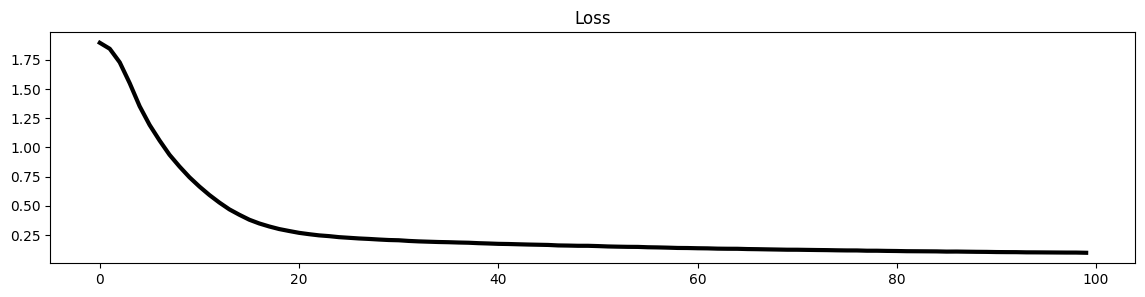

In [ ]:
# Visualizing the loss function
plt.figure(figsize=(14, 3))
plt.plot(loss_history, 'k', lw=3)
plt.title('Loss');

In [ ]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im.permute(1, 2, 0), interpolation='none')
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [ ]:
# Set the model to eval state
model.eval()

Autoencoder(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
)

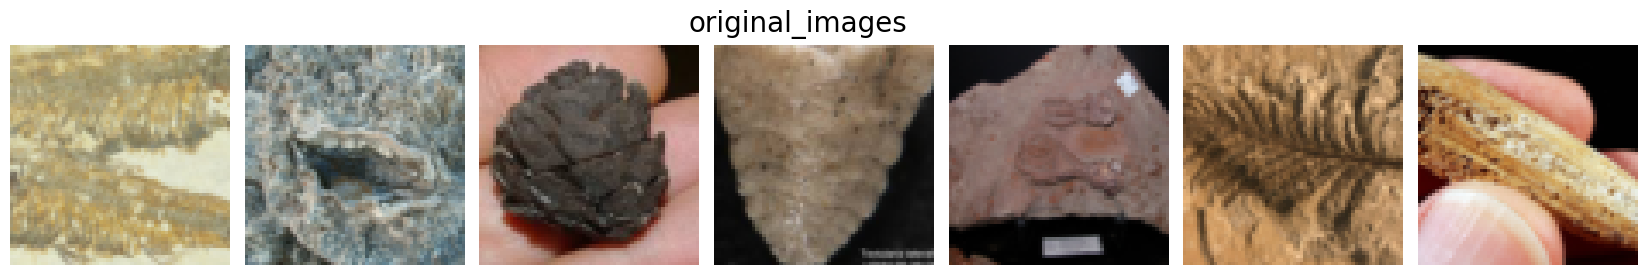

torch.Size([7, 3, 64, 64])


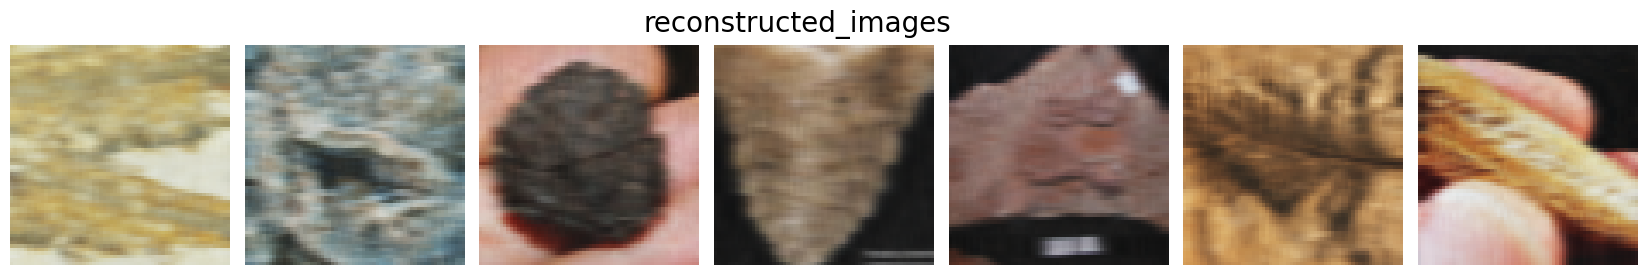

In [ ]:
# Display some sample images and there reconstruction through auto encoders

images = []
cols, rows = 7, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, _ = training_data[sample_idx]
    images.append(img)
display_image_grid(images, rows, cols, "original_images")
with torch.no_grad():
    reconstructed_images = model(torch.stack(images).to(device)).cpu()
display_image_grid(reconstructed_images.squeeze(1), rows, cols, "reconstructed_images")


# What's next ..
As we're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.